In [1]:
!pip install umap-learn

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import h5py
import s3fs
import traceback
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import gc
from tensorflow.keras import backend as K
import umap
from tensorflow.keras.callbacks import Callback
from sklearn.metrics.pairwise import euclidean_distances
import glob
from scipy.spatial.distance import pdist, cdist, squareform

2025-10-15 15:11:52.968317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-15 15:11:53.219326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-15 15:11:53.221130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-15 15:11:53.653238: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 15:11:55.492044: W tensorflow/com

In [3]:
S3_PREPROCESSED_FILE_PATHS = [
    's3://representatiohorarum/Datasets/Fragmentos/SLOVO_5gloss.h5',
    's3://representatiohorarum/Datasets/Fragmentos/ISL_5gloss.h5',
    's3://representatiohorarum/Datasets/Fragmentos/WLSL_5gloss.h5'
]

# --- [NUEVO] Hiperparámetro para limitar secuencias por glosa ---
MAX_SEQUENCES_PER_GLOSS = 9

SPECIFIC_GLOSSES_TO_PROCESS = ["brother", "cold","man"]
RANDOM_STATE = 42
TEST_SIZE = 0.2
LEARNING_RATE = 0.00005 # ANTES: 0.0001 - Reducir LR inicial
EPOCHS = 100 # Mantener, EarlyStopping decidirá
BATCH_SIZE = 16

# --- Nuevos Parámetros de Redimensionamiento ---
RESIZE_INPUT = True # Poner en True para activar redimensionamiento
TARGET_H = 80 # Nueva altura (reducida)
TARGET_W = 60 # Nueva anchura (reducida)

# --- Dimensiones Latentes ---
LATENT_DIM = 256 # Dimensión del vector latente final agregado

# --- Pesos y Márgenes de Loss (AJUSTADOS - Forzar Separación Inv/Perm) ---
W_RECON = 0.3 # Mantener
W_INTER_GLOSS = 0.6 # Mantener
W_TEMPORAL_STRUCTURE = 1.0 # Mantener (Peso Orig vs Inv/Perm)
W_TEMPO_INV_PERM = 1.5 # ANTES: 1.0 - Aumentar peso específico Inv vs Perm
W_KL = 0.0 # Mantener en 0

MARGIN_TEMPORAL_STRUCTURE = 10.0 # ANTES: 8.0 - Aumentar margen para triplets temporales
MARGIN_INTER_GLOSS = 5.0 # Mantener como estaba

# --- Configuración Callbacks ---
EARLY_STOPPING_PATIENCE = 30 # Más paciencia
REDUCE_LR_PATIENCE = 15    # Más paciencia

# --- Directorio de salida para visualizaciones ---
OUTPUT_VIZ_DIR = 'visualizations_refactored_v2'

LANGUAGE_COLOR_MAP = {
    'SLOVO': 'red',
    'ISL': 'blue',
    'WLSL': 'green'
}

In [4]:
def triplet_loss_simple(anchor, positive, negative, margin=1.0):
    """Calcula la pérdida triplet simple."""
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(positive_distance - negative_distance + margin, 0.0)
    return tf.reduce_mean(loss)

def prepare_triplet_data(X, glosses, gloss_map=None):
    """Prepara los datos en formato (anchor, positive_shifted, negative_gloss, inverted, permuted)."""
    print(f"Preparando 5 variantes para {len(X)} secuencias...")
    X_variants = []
    gloss_to_indices = {gloss: [i for i, g in enumerate(glosses) if g == gloss]
                        for gloss in set(glosses)} if gloss_map is None else gloss_map

    possible_glosses = list(gloss_to_indices.keys())

    for i, x_anchor in enumerate(X):
        current_gloss = glosses[i]
        T = x_anchor.shape[0] # Longitud temporal

        # 1. Original
        original = x_anchor[np.newaxis, ...] # Añadir dimensión batch

        # 2. Positive Shifted (Desplazado)
        shift_amount = 1
        shifted = np.roll(x_anchor, shift_amount, axis=0) if T > 1 else x_anchor
        positive_shifted = shifted[np.newaxis, ...]

        # 3. Negative Gloss (Glosario Diferente - Aleatorio)
        possible_neg_glosses = [g for g in possible_glosses if g != current_gloss]
        if not possible_neg_glosses:
            # Si solo hay un glosario, usar permutado como negativo (caso extremo)
            neg_gloss_seq = x_anchor[np.random.permutation(T), ...][np.newaxis, ...]
            if i == 0: print("Advertencia: No hay glosarios diferentes. Usando permutados como negativos de glosario.")
        else:
            neg_gloss_label = np.random.choice(possible_neg_glosses)
            neg_indices = gloss_to_indices[neg_gloss_label]
            neg_idx = np.random.choice(neg_indices)
            # Asegurarse que X global está disponible o pasar X completo como argumento
            negative_gloss_seq = X[neg_idx:neg_idx+1] # Mantiene dim batch (1, T, H, W, C)
            
            # ¡CORRECCIÓN! AÑADIR ESTA VERIFICACIÓN Y REDIMENSIONAMIENTO
            if negative_gloss_seq.shape[1] != T:
                # Redimensionar el negativo para que coincida con la longitud del ancla
                # Esto es una simplificación; podrías necesitar un método más sofisticado
                # como un recorte o relleno inteligente.
                # Para este ejemplo, usaremos tf.image.resize
                
                # Para usar tf.image.resize, necesitamos que los datos estén en formato (batch, height, width, channels)
                # así que lo aplicamos frame a frame.
                
                neg_video = negative_gloss_seq[0] # Quitar la dimensión de batch
                
                # Redimensionar cada frame y apilarlos
                resized_frames = tf.image.resize(neg_video, [x_anchor.shape[1], x_anchor.shape[2]])
                
                # Si la longitud temporal es diferente, puedes truncar o rellenar. Aquí truncamos.
                if resized_frames.shape[0] > T:
                    resized_frames = resized_frames[:T, :, :, :]
                elif resized_frames.shape[0] < T:
                    # Rellenar con ceros si es más corto
                    padding = [[0, T - resized_frames.shape[0]], [0, 0], [0, 0], [0, 0]]
                    resized_frames = tf.pad(resized_frames, padding, "CONSTANT")
                
                negative_gloss_seq = resized_frames[np.newaxis, ...] # Añadir la dimensión de batch de nuevo
                

        # 4. Inverted (Invertido Temporalmente)
        inverted = x_anchor[::-1, ...][np.newaxis, ...] if T > 1 else x_anchor[np.newaxis, ...]

        # 5. Permuted (Permutado Temporalmente)
        permuted_idx = np.random.permutation(T) if T > 1 else np.arange(T)
        permuted = x_anchor[permuted_idx, ...][np.newaxis, ...]

        # Apilar las 5 variantes
        try:
            variant_sample = np.stack([original[0], positive_shifted[0], negative_gloss_seq[0], inverted[0], permuted[0]], axis=0)
            X_variants.append(variant_sample)
        except ValueError as e:
            print(f"Error apilando variantes para muestra {i} (gloss {current_gloss}): {e}")
            print(f"Shapes: orig={original.shape}, shifted={positive_shifted.shape}, neg_gloss={negative_gloss_seq.shape}, inv={inverted.shape}, perm={permuted.shape}")
            # Omitir esta muestra si hay error de forma
            continue


    return np.stack(X_variants, axis=0) if X_variants else np.array([])

In [5]:
def build_temporal_autoencoder(input_shape_original, target_h=None, target_w=None):
    """
    Construye el autoencoder Conv3D base con MÁS FILTROS y opción de resizing.
    """
    timesteps, height, width, channels = input_shape_original

    # Define la forma de entrada real después del posible resizing
    if RESIZE_INPUT and target_h is not None and target_w is not None:
        current_input_shape = (timesteps, target_h, target_w, channels)
        print(f"Construyendo modelo Conv3D (más filtros) con resizing a: {current_input_shape}")
    else:
        current_input_shape = input_shape_original
        print(f"Construyendo modelo Conv3D (más filtros) con input_shape original: {current_input_shape}")

    if None in current_input_shape:
        raise ValueError(f"Input shape contiene None: {current_input_shape}. Asegúrate de tamaño fijo (o maneja variable).")

    T, H, W, C = current_input_shape
    inputs = layers.Input(shape=input_shape_original, name="original_input") # Input original

    # --- Capa de Resizing (si está activada) ---
    if RESIZE_INPUT and target_h is not None and target_w is not None:
        x = layers.TimeDistributed(layers.Resizing(target_h, target_w), name="resizing")(inputs)
    else:
        x = inputs

    # --- Encoder (Conv3D - MÁS FILTROS) ---
    # Aumentamos el número de filtros (originalmente 8 -> 16 -> 16)
    x = layers.Conv3D(16, (3, 3, 3), padding='same', activation='relu', name="conv3d_1")(x) # Filtros: 8 -> 16
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2), name="maxpool3d_1")(x) # Reduce H, W

    x = layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu', name="conv3d_2")(x) # Filtros: 16 -> 32
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2), name="maxpool3d_2")(x) # Reduce H, W más

    # Capa intermedia antes del bottleneck
    encoded_sequence = layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu', name='bottleneck_sequence')(x) # Filtros: 16 -> 32
    # La salida aquí es (Batch, T', H'', W'', Filters)

    # --- Decoder (Conv3DTranspose - MÁS FILTROS) ---
    x = layers.Conv3DTranspose(32, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu', name="conv3dt_1")(encoded_sequence) # Filtros: 16 -> 32
    x = layers.BatchNormalization()(x)

    x = layers.Conv3DTranspose(16, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu', name="conv3dt_2")(x) # Filtros: 8 -> 16
    x = layers.BatchNormalization()(x)

    # Capa final para ajustar canales y asegurar forma de salida (redimensionada)
    decoded_resized = layers.Conv3D(C, (3, 3, 3), activation='sigmoid', padding='same', name='decoded_resized')(x)

    # --- Capa de Upsampling final (si se hizo resizing inicial) ---
    if RESIZE_INPUT and target_h is not None and target_w is not None:
        # Upsample de vuelta a la dimensión original H, W
        reconstruction = layers.TimeDistributed(layers.Resizing(height, width), name="reconstruction_upsampled")(decoded_resized)
    else:
        reconstruction = decoded_resized # Ya tiene la forma correcta

    # El modelo retorna la reconstrucción (tamaño original) y la secuencia del bottleneck
    model = models.Model(inputs, [reconstruction, encoded_sequence], name='conv3d_ae_more_filters') # Nombre cambiado
    print(f"Forma de entrada Autoencoder: {model.input_shape}")
    print(f"Formas de salida Autoencoder: {[o.shape for o in model.outputs]}")
    return model

In [6]:
print("\n[Paso Adicional CORREGIDO] Definiendo una arquitectura de autoencoder más simple para el baseline...")

def build_simple_autoencoder(input_shape_original, target_h=None, target_w=None):
    """
    [CORREGIDO] Construye una versión SIMPLIFICADA del autoencoder Conv3D base.
    Esta versión asegura que las dimensiones de la reconstrucción final coincidan
    exactamente con las de la entrada original para evitar errores de tamaño.
    """
    timesteps, original_height, original_width, channels = input_shape_original

    # Define la forma de entrada que usará el modelo internamente
    if RESIZE_INPUT and target_h is not None and target_w is not None:
        current_input_shape = (timesteps, target_h, target_w, channels)
        print(f"  Construyendo modelo Conv3D (simple) con resizing a: {current_input_shape}")
    else:
        current_input_shape = input_shape_original
        print(f"  Construyendo modelo Conv3D (simple) con input_shape original: {current_input_shape}")

    T, H, W, C = current_input_shape
    inputs = layers.Input(shape=input_shape_original, name="original_input_simple")

    # --- Capa de Resizing (si aplica) ---
    if RESIZE_INPUT and target_h is not None and target_w is not None:
        x = layers.TimeDistributed(layers.Resizing(target_h, target_w), name="resizing_simple")(inputs)
    else:
        x = inputs

    # --- Encoder (Simplificado: 8 -> 16 filtros) ---
    x = layers.Conv3D(8, (3, 3, 3), padding='same', activation='relu', name="conv3d_1_simple")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2), name="maxpool3d_1_simple")(x) # Dim: H/2, W/2

    encoded_sequence = layers.Conv3D(16, (3, 3, 3), padding='same', activation='relu', name='bottleneck_sequence_simple')(x)

    # --- Decoder (Simplificado: 16 -> 8 filtros) ---
    # Se asegura de duplicar las dimensiones de vuelta a H, W
    x = layers.Conv3DTranspose(8, (3, 3, 3), strides=(1, 2, 2), padding='same', activation='relu', name="conv3dt_1_simple")(encoded_sequence)
    x = layers.BatchNormalization()(x)

    decoded_resized = layers.Conv3D(C, (3, 3, 3), activation='sigmoid', padding='same', name='decoded_resized_simple')(x)

    # --- Capa de Upsampling final [PUNTO CLAVE DE LA CORRECCIÓN] ---
    # Se asegura de que la salida final tenga las dimensiones ORIGINALES (original_height, original_width)
    if RESIZE_INPUT and target_h is not None and target_w is not None:
        reconstruction = layers.TimeDistributed(layers.Resizing(original_height, original_width), name="reconstruction_upsampled_simple")(decoded_resized)
    else:
        reconstruction = decoded_resized

    model = models.Model(inputs, [reconstruction, encoded_sequence], name='conv3d_ae_simple')
    return model

print("  Función 'build_simple_autoencoder' corregida y definida.")


[Paso Adicional CORREGIDO] Definiendo una arquitectura de autoencoder más simple para el baseline...
  Función 'build_simple_autoencoder' corregida y definida.


In [7]:
class TemporalTripletAutoencoder(models.Model):
    """Modelo wrapper - Corregido sin la pérdida inv_perm incorrecta."""

    # El __init__ ahora no necesita w_tempo_inv_perm
    def __init__(self, autoencoder, w_recon, w_inter, w_tempo_struct,
                 w_kl, margin_inter, margin_tempo_struct, latent_dim=LATENT_DIM):
        super(TemporalTripletAutoencoder, self).__init__()
        self.autoencoder = autoencoder
        self.latent_dim = latent_dim

        # Pesos y Márgenes (sin w_tempo_inv_perm)
        self.w_recon = w_recon
        self.w_inter = w_inter
        self.w_tempo_struct = w_tempo_struct # Este se usará para ambas pérdidas temporales
        self.w_kl = w_kl
        self.margin_inter = margin_inter
        self.margin_tempo_struct = margin_tempo_struct

        # --- Capas (sin cambios) ---
        self.spatial_pooling = layers.TimeDistributed(layers.GlobalAveragePooling2D(), name='spatial_pooling')
        self.temporal_aggregator_gru = layers.Bidirectional(
            layers.GRU(self.latent_dim // 2, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
            name='temporal_aggregator_bidir_gru'
        )
        self.temporal_final_pooling = layers.GlobalAveragePooling1D(name='temporal_final_pooling')
        self.latent_norm = layers.LayerNormalization(name='latent_norm', epsilon=1e-6)

        # --- Métricas (eliminamos la de inv_perm_loss) ---
        self.loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.inter_gloss_loss_tracker = tf.keras.metrics.Mean(name="inter_gloss_triplet_loss")
        self.temporal_inv_triplet_loss_tracker = tf.keras.metrics.Mean(name="temporal_inv_triplet_loss")
        self.temporal_perm_triplet_loss_tracker = tf.keras.metrics.Mean(name="temporal_perm_triplet_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")


    def get_final_latent(self, input_sequence, training=False):
        # ... (sin cambios aquí) ...
        input_sequence = tf.cast(input_sequence, tf.float32)
        _, latent_sequence = self.autoencoder(input_sequence, training=training)
        spatially_pooled = self.spatial_pooling(latent_sequence, training=training)
        temporally_aggregated_seq = self.temporal_aggregator_gru(spatially_pooled, training=training)
        pooled_latent = self.temporal_final_pooling(temporally_aggregated_seq, training=training)
        return self.latent_norm(pooled_latent, training=training)

    def train_step(self, data):
        # ... (código de desempaquetado de datos sin cambios) ...
        if isinstance(data, tuple):
            X_variants_batch, recon_target = data[:2]
        else:
            X_variants_batch = data
            recon_target = X_variants_batch[:, 0, ...]
        
        X_variants_batch = tf.cast(X_variants_batch, tf.float32)
        recon_target = tf.cast(recon_target, tf.float32)

        anchor_input = X_variants_batch[:, 0, ...]
        positive_shifted_input = X_variants_batch[:, 1, ...]
        negative_gloss_input = X_variants_batch[:, 2, ...]
        inverted_input = X_variants_batch[:, 3, ...]
        permuted_input = X_variants_batch[:, 4, ...];

        with tf.GradientTape() as tape:
            # --- Reconstrucción y Latentes (sin cambios) ---
            recon_orig, _ = self.autoencoder(anchor_input, training=True)
            recon_loss = tf.keras.losses.MeanSquaredError()(recon_target, recon_orig)
            
            latent_orig_final = self.get_final_latent(anchor_input, training=True)
            latent_shifted_final = self.get_final_latent(positive_shifted_input, training=True)
            latent_neg_gloss_final = self.get_final_latent(negative_gloss_input, training=True)
            latent_inv_final = self.get_final_latent(inverted_input, training=True)
            latent_perm_final = self.get_final_latent(permuted_input, training=True)

            # --- Pérdidas (corregidas) ---
            inter_gloss_loss = triplet_loss_simple(latent_orig_final, latent_shifted_final, latent_neg_gloss_final, self.margin_inter)
            temporal_inv_triplet_loss = triplet_loss_simple(latent_orig_final, latent_shifted_final, latent_inv_final, self.margin_tempo_struct)
            temporal_perm_triplet_loss = triplet_loss_simple(latent_orig_final, latent_shifted_final, latent_perm_final, self.margin_tempo_struct)
            kl_loss = tf.constant(0.0, dtype=tf.float32)
            
            # --- ¡CORRECCIÓN! Pérdida Total sin el término incorrecto ---
            total_loss = (
                self.w_recon * recon_loss +
                self.w_inter * inter_gloss_loss +
                self.w_tempo_struct * (temporal_inv_triplet_loss + temporal_perm_triplet_loss) + # Sumamos ambas pérdidas temporales
                self.w_kl * kl_loss
            )
            total_loss = tf.where(tf.math.is_nan(total_loss), tf.zeros_like(total_loss), total_loss)

        # --- Optimización (sin cambios) ---
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        valid_gradients_vars = [(g, v) for g, v in zip(gradients, trainable_vars) if g is not None]
        if not valid_gradients_vars:
             return {m.name: m.result() for m in self.metrics}
        self.optimizer.apply_gradients(zip([g for g, v in valid_gradients_vars], [v for g, v in valid_gradients_vars]))
        
        # --- Actualizar Métricas (sin la de inv_perm_loss) ---
        self.loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.inter_gloss_loss_tracker.update_state(inter_gloss_loss)
        self.temporal_inv_triplet_loss_tracker.update_state(temporal_inv_triplet_loss)
        self.temporal_perm_triplet_loss_tracker.update_state(temporal_perm_triplet_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {m.name: m.result() for m in self.metrics}

    # Debes aplicar la misma corrección a `test_step`
    def test_step(self, data):
        # ... (código de desempaquetado de datos sin cambios) ...
        if isinstance(data, tuple):
            X_variants_batch, recon_target = data[:2]
        else:
            X_variants_batch = data
            recon_target = X_variants_batch[:, 0, ...]

        X_variants_batch = tf.cast(X_variants_batch, tf.float32)
        recon_target = tf.cast(recon_target, tf.float32)

        anchor_input = X_variants_batch[:, 0, ...]
        positive_shifted_input = X_variants_batch[:, 1, ...]
        negative_gloss_input = X_variants_batch[:, 2, ...]
        inverted_input = X_variants_batch[:, 3, ...]
        permuted_input = X_variants_batch[:, 4, ...];
        
        # --- Reconstrucción y Latentes (sin cambios) ---
        recon_orig, _ = self.autoencoder(anchor_input, training=False)
        recon_loss = tf.keras.losses.MeanSquaredError()(recon_target, recon_orig)

        latent_orig_final = self.get_final_latent(anchor_input, training=False)
        latent_shifted_final = self.get_final_latent(positive_shifted_input, training=False)
        latent_neg_gloss_final = self.get_final_latent(negative_gloss_input, training=False)
        latent_inv_final = self.get_final_latent(inverted_input, training=False)
        latent_perm_final = self.get_final_latent(permuted_input, training=False)
        
        # --- Pérdidas (corregidas) ---
        inter_gloss_loss = triplet_loss_simple(latent_orig_final, latent_shifted_final, latent_neg_gloss_final, self.margin_inter)
        temporal_inv_triplet_loss = triplet_loss_simple(latent_orig_final, latent_shifted_final, latent_inv_final, self.margin_tempo_struct)
        temporal_perm_triplet_loss = triplet_loss_simple(latent_orig_final, latent_shifted_final, latent_perm_final, self.margin_tempo_struct)
        kl_loss = tf.constant(0.0, dtype=tf.float32)
        
        # --- ¡CORRECCIÓN! Pérdida Total sin el término incorrecto ---
        total_loss = (
            self.w_recon * recon_loss +
            self.w_inter * inter_gloss_loss +
            self.w_tempo_struct * (temporal_inv_triplet_loss + temporal_perm_triplet_loss) +
            self.w_kl * kl_loss
        )
        total_loss = tf.where(tf.math.is_nan(total_loss), tf.zeros_like(total_loss), total_loss)
        
        # --- Actualizar Métricas (sin la de inv_perm_loss) ---
        self.loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.inter_gloss_loss_tracker.update_state(inter_gloss_loss)
        self.temporal_inv_triplet_loss_tracker.update_state(temporal_inv_triplet_loss)
        self.temporal_perm_triplet_loss_tracker.update_state(temporal_perm_triplet_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {m.name: m.result() for m in self.metrics}


    @property
    def metrics(self):
        # --- Lista de métricas (eliminamos la de inv_perm_loss) ---
        return [
            self.loss_tracker,
            self.recon_loss_tracker,
            self.inter_gloss_loss_tracker,
            self.temporal_inv_triplet_loss_tracker,
            self.temporal_perm_triplet_loss_tracker,
            self.kl_loss_tracker
        ]

In [8]:
def evaluate_temporal_sensitivity(wrapper_model, X, n_samples=10):
    """Evalúa si Shifted está más cerca de Original que Inverted y Permuted."""
    from sklearn.metrics.pairwise import cosine_distances # Necesaria aquí
    n_samples_to_eval = min(n_samples, len(X))
    print(f"\n--- Evaluando Sensibilidad Temporal en {n_samples_to_eval} muestras ---")
    if not isinstance(wrapper_model, TemporalTripletAutoencoder):
        print("Error: Se esperaba 'TemporalTripletAutoencoder'.")
        return
    # Ajustar la verificación de ndim si la entrada original a esta función cambia
    if X.ndim != 5 or X.shape[0] == 0:
        print(f"Error: Forma de X inesperada para evaluar sensibilidad: {X.shape}")
        return
    if n_samples_to_eval == 0:
        print("No hay muestras para evaluar sensibilidad.")
        return

    dists_os = [] # Distancia Original - Shifted
    dists_oi = [] # Distancia Original - Inverted
    dists_op = [] # Distancia Original - Permuted
    cos_dists_os = []
    cos_dists_oi = []
    cos_dists_op = []

    X_eval = X[:n_samples_to_eval].astype(np.float32) # Usar las secuencias originales

    # Procesar en batches pequeños si n_samples es grande
    batch_size_eval = 16 # Puede ajustarse
    for i in range(0, n_samples_to_eval, batch_size_eval):
        batch_x_orig = X_eval[i:min(i + batch_size_eval, n_samples_to_eval)]
        T_batch = batch_x_orig.shape[1] # Longitud temporal del batch
        
        # Crear variantes Inverted, Permuted, Shifted on-the-fly
        batch_x_inv_list = [seq[::-1, ...] if T_batch > 1 else seq for seq in batch_x_orig]
        batch_x_perm_list = []
        batch_x_shift_list = []
        for seq in batch_x_orig:
             T_seq = seq.shape[0] # Longitud de esta secuencia
             perm_idx = np.random.permutation(T_seq) if T_seq > 1 else np.arange(T_seq)
             batch_x_perm_list.append(seq[perm_idx, ...])
             batch_x_shift_list.append(np.roll(seq, 1, axis=0) if T_seq > 1 else seq)
             
        batch_x_inv = np.stack(batch_x_inv_list, axis=0)
        batch_x_perm = np.stack(batch_x_perm_list, axis=0)
        batch_x_shift = np.stack(batch_x_shift_list, axis=0)

        # Obtener latentes en batch
        latent_orig = wrapper_model.get_final_latent(tf.constant(batch_x_orig), training=False).numpy()
        latent_shift = wrapper_model.get_final_latent(tf.constant(batch_x_shift), training=False).numpy()
        latent_inv = wrapper_model.get_final_latent(tf.constant(batch_x_inv), training=False).numpy()
        latent_perm = wrapper_model.get_final_latent(tf.constant(batch_x_perm), training=False).numpy()

        # Calcular distancias L2 al cuadrado
        batch_dists_os = np.sum(np.square(latent_orig - latent_shift), axis=1)
        batch_dists_oi = np.sum(np.square(latent_orig - latent_inv), axis=1)
        batch_dists_op = np.sum(np.square(latent_orig - latent_perm), axis=1)
        dists_os.extend(batch_dists_os)
        dists_oi.extend(batch_dists_oi)
        dists_op.extend(batch_dists_op)

        # Calcular distancias coseno
        for k in range(latent_orig.shape[0]):
            lo, ls, li, lp = latent_orig[k:k+1], latent_shift[k:k+1], latent_inv[k:k+1], latent_perm[k:k+1]
            # Evitar división por cero si un vector latente es cero
            norm_o = np.linalg.norm(lo)
            norm_s = np.linalg.norm(ls)
            norm_i = np.linalg.norm(li)
            norm_p = np.linalg.norm(lp)
            
            cos_dists_os.append(1.0 if norm_o == 0 or norm_s == 0 else cosine_distances(lo, ls)[0, 0])
            cos_dists_oi.append(1.0 if norm_o == 0 or norm_i == 0 else cosine_distances(lo, li)[0, 0])
            cos_dists_op.append(1.0 if norm_o == 0 or norm_p == 0 else cosine_distances(lo, lp)[0, 0])


    if not dists_os:
        print("No se procesaron muestras para sensibilidad.")
        return

    # Calcular promedios
    avg_dist_os = np.mean(dists_os)
    avg_dist_oi = np.mean(dists_oi)
    avg_dist_op = np.mean(dists_op)
    avg_cos_os = np.mean(cos_dists_os)
    avg_cos_oi = np.mean(cos_dists_oi)
    avg_cos_op = np.mean(cos_dists_op)

    print(f"  Resultados Promedio ({n_samples_to_eval} muestras):")
    print(f"    Distancia L2^2 - Shift: {avg_dist_os:.4f}, Inv: {avg_dist_oi:.4f}, Perm: {avg_dist_op:.4f}")
    print(f"    Distancia Coseno - Shift: {avg_cos_os:.4f}, Inv: {avg_cos_oi:.4f}, Perm: {avg_cos_op:.4f}")
    # La expectativa es que Shifted sea el más cercano (menor distancia) a Original
    print("  (Esperado: Dist Shift < Dist Inv y Dist Shift < Dist Perm)")
    l2_ok = avg_dist_os < avg_dist_oi and avg_dist_os < avg_dist_op
    cos_ok = avg_cos_os < avg_cos_oi and avg_cos_os < avg_cos_op
    print(f"  >> Relación de distancia L2^2 esperada {'se cumple' if l2_ok else 'NO se cumple'}{'!' if l2_ok else '.'}")
    print(f"  >> Relación de distancia Coseno esperada {'se cumple' if cos_ok else 'NO se cumple'}{'!' if cos_ok else '.'}")

In [9]:
class LatentSpaceEvaluator(Callback):
    """
    Callback para evaluar la separación temporal y semántica del espacio latente
    al final de cada época usando el conjunto de validación.
    """
    def __init__(self, validation_data, glosses_val, gloss_map):
        super().__init__()
        # Desempaquetar los datos de validación
        self.X_val = validation_data[0] # X_val_variants
        self.glosses_val = glosses_val
        self.gloss_map = gloss_map
        
        # Diccionarios para guardar el historial de las métricas
        self.history = {
            'dist_orig_shifted': [],
            'dist_orig_inverted': [],
            'dist_orig_permuted': [],
            'dist_intra_class': [],
            'dist_inter_class': [],
            'semantic_ratio': []
        }

    def on_epoch_end(self, epoch, logs=None):
        print(f"\\nFin de la Época {epoch + 1}. Evaluando espacio latente...")

        # --- 1. Evaluación de Sensibilidad Temporal ---
        anchor_input = self.X_val[:, 0, ...]
        shifted_input = self.X_val[:, 1, ...]
        inverted_input = self.X_val[:, 3, ...]
        permuted_input = self.X_val[:, 4, ...]

        # Obtener embeddings
        latent_orig = self.model.get_final_latent(anchor_input, training=False)
        latent_shifted = self.model.get_final_latent(shifted_input, training=False)
        latent_inverted = self.model.get_final_latent(inverted_input, training=False)
        latent_permuted = self.model.get_final_latent(permuted_input, training=False)

        # Calcular distancias euclidianas
        dist_os = np.mean(np.sqrt(np.sum((latent_orig - latent_shifted)**2, axis=1)))
        dist_oi = np.mean(np.sqrt(np.sum((latent_orig - latent_inverted)**2, axis=1)))
        dist_op = np.mean(np.sqrt(np.sum((latent_orig - latent_permuted)**2, axis=1)))
        
        self.history['dist_orig_shifted'].append(dist_os)
        self.history['dist_orig_inverted'].append(dist_oi)
        self.history['dist_orig_permuted'].append(dist_op)

        print(f"  Distancia Temporal: Orig-Shift={dist_os:.4f}, Orig-Inv={dist_oi:.4f}, Orig-Perm={dist_op:.4f}")

        # --- 2. Evaluación de Separación Semántica ---
        unique_glosses = list(self.gloss_map.keys())
        intra_class_dists = []
        inter_class_dists = []

        # Usaremos solo los embeddings originales para la evaluación semántica
        embeddings = latent_orig.numpy()

        for i, gloss1 in enumerate(unique_glosses):
            indices1 = self.gloss_map[gloss1]
            
            # Distancias Intra-Clase
            if len(indices1) > 1:
                class_embeddings = embeddings[indices1]
                intra_dists = euclidean_distances(class_embeddings)
                # Tomar solo la parte triangular superior para no contar pares dos veces
                intra_class_dists.extend(intra_dists[np.triu_indices(len(indices1), k=1)])

            # Distancias Inter-Clase
            for j in range(i + 1, len(unique_glosses)):
                gloss2 = unique_glosses[j]
                indices2 = self.gloss_map[gloss2]
                
                embeddings1 = embeddings[indices1]
                embeddings2 = embeddings[indices2]
                
                inter_dists = euclidean_distances(embeddings1, embeddings2)
                inter_class_dists.extend(inter_dists.flatten())
        
        mean_intra_dist = np.mean(intra_class_dists) if intra_class_dists else 0
        mean_inter_dist = np.mean(inter_class_dists) if inter_class_dists else 0
        semantic_ratio = mean_inter_dist / mean_intra_dist if mean_intra_dist > 0 else 0

        self.history['dist_intra_class'].append(mean_intra_dist)
        self.history['dist_inter_class'].append(mean_inter_dist)
        self.history['semantic_ratio'].append(semantic_ratio)

        print(f"  Distancia Semántica: Intra-Clase={mean_intra_dist:.4f}, Inter-Clase={mean_inter_dist:.4f}, Ratio={semantic_ratio:.4f}")

In [10]:
# --- [Paso 1] Carga y Procesamiento de Datos (Versión con Filtro de Glosas y Registros Detallados) ---

print(f"\\n[Paso 1] Cargando datos desde: {S3_PREPROCESSED_FILE_PATHS}")

def load_and_process_data(file_paths, max_sequences_per_gloss=None, specific_glosses=None):
    """
    Carga datos, aplicando filtros por número de glosas y por secuencias por glosa,
    y muestra registros detallados del proceso.
    """
    s3 = s3fs.S3FileSystem()
    X_list, glosses_list, language_list = [], [], []
    sequence_lengths = []
    
    if specific_glosses:
        print("-" * 60)
        print(f"--> Glosas ESPECÍFICAS a procesar: {specific_glosses}")
        print("-" * 60)
        selected_glosses = set(specific_glosses)
    else:
        print("\nNo se especificaron glosas. Se procesarán todas las encontradas.")
        selected_glosses = None

    # --- Inicia el proceso de carga de datos solo para las glosas seleccionadas ---
    load_stats = {}
    print("-" * 60)
    print(f"Parámetro MAX_SEQUENCES_PER_GLOSS = {max_sequences_per_gloss}")
    print("-" * 60)

    for file_path in file_paths:
        language_name = os.path.basename(file_path).split('_')[0].upper()
        print(f"\\n--- Procesando Archivo: {file_path} (Idioma: {language_name}) ---")
        load_stats[language_name] = {}
        
        try:
            with s3.open(file_path, 'rb') as s3_file:
                with h5py.File(s3_file, 'r') as f:
                    # Contamos secuencias disponibles SOLO de las glosas que nos interesan
                    available_gloss_counts = {}
                    for vid in f.keys():
                        if 'gloss' in f[vid].attrs:
                            gloss = f[vid].attrs.get('gloss', 'N/A')
                            if selected_glosses and gloss not in selected_glosses:
                                continue
                            available_gloss_counts[gloss] = available_gloss_counts.get(gloss, 0) + 1
                    
                    print(" Glosas y secuencias DISPONIBLES (de las seleccionadas) en este archivo:")
                    for gloss, count in sorted(available_gloss_counts.items()):
                        print(f" - '{gloss}': {count} secuencias")
                        load_stats[language_name][gloss] = {'disponible': count, 'cargada': 0}

                    # Cargamos los datos aplicando filtros
                    kept_gloss_counts = {}
                    for vid in f.keys():
                        group = f[vid]
                        if 'frames' not in group or 'gloss' not in group.attrs:
                            continue
                        gloss = group.attrs.get('gloss', 'N/A')
                        
                        if selected_glosses and gloss not in selected_glosses:
                            continue
                        
                        if max_sequences_per_gloss is not None:
                            current_kept_count = kept_gloss_counts.get(gloss, 0)
                            if current_kept_count >= max_sequences_per_gloss:
                                continue
                            kept_gloss_counts[gloss] = current_kept_count + 1

                        frames_data = group['frames'][:]
                        if frames_data.ndim == 3:
                            frames_data = np.expand_dims(frames_data, axis=-1)
                        
                        X_list.append(frames_data)
                        glosses_list.append(gloss)
                        language_list.append(language_name)
                        sequence_lengths.append(frames_data.shape[0])
                        load_stats[language_name][gloss]['cargada'] += 1

        except Exception as e:
            print(f"Error cargando {file_path}: {e}")

    if not sequence_lengths:
        print("Advertencia: No se cargaron secuencias.")
        return np.array([]), np.array([]), np.array([]), 0
        
    avg_len = int(np.mean(sequence_lengths))
    print(f"\\nDuración promedio de secuencias calculada (global): {avg_len} frames.")
    
    X_padded = []
    for seq in X_list:
        if seq.shape[0] > avg_len: X_padded.append(seq[:avg_len, ...])
        else: X_padded.append(np.pad(seq, [[0, avg_len - seq.shape[0]], [0, 0], [0, 0], [0, 0]], 'constant'))

    return np.stack(X_padded, axis=0), np.array(glosses_list), np.array(language_list), avg_len


# --- [CORRECCIÓN] Llamada a la función actualizada, pasando NUM_GLOSSES_TO_PROCESS ---
X_all, glosses_all, language_all, avg_sequence_length = load_and_process_data(
    S3_PREPROCESSED_FILE_PATHS,
    MAX_SEQUENCES_PER_GLOSS,
    SPECIFIC_GLOSSES_TO_PROCESS
)

# --- Ajuste de la forma de entrada ---
# Se añade una comprobación para evitar errores si no se cargan datos
if X_all.size > 0:
    input_shape_original = (avg_sequence_length, X_all.shape[2], X_all.shape[3], X_all.shape[4])
    print(f"Forma de entrada unificada: {input_shape_original}")

    # División y Normalización (ahora incluye 'language_all')
    X_train, X_val, glosses_train, glosses_val, lang_train, lang_val = train_test_split(
        X_all, glosses_all, language_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=glosses_all
    )

    print("  Glosses Entrenamiento:", {g: count for g, count in zip(*np.unique(glosses_train, return_counts=True))})
    print("  Glosses Validación:", {g: count for g, count in zip(*np.unique(glosses_val, return_counts=True))})
    print(f"  Tamaño Entrenamiento: {len(X_train)}, Validación: {len(X_val)}")

    # Normalización (0 a 1 basado en entrenamiento)
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)

    X_train_min = np.min(X_train)
    X_train_max = np.max(X_train)
    if X_train_max > X_train_min:
        X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
        X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
        X_val = np.clip(X_val, 0.0, 1.0)
        print("  Normalización MinMax completada (basada en entrenamiento).")
    else:
        print("  Advertencia: Datos de entrenamiento constantes. No se realizó normalización.")

    gloss_map_train = {g: [i for i, gl in enumerate(glosses_train) if gl == g] for g in set(glosses_train)}
    gloss_map_val = {g: [i for i, gl in enumerate(glosses_val) if gl == g] for g in set(glosses_val)}

    del X_all, glosses_all, language_all # Liberar memoria
    gc.collect()
else:
    print("Error fatal: No se cargaron datos. Revisa las rutas S3 y los archivos.")
    # Asignar valores vacíos para evitar más errores en el cuaderno
    X_train, X_val, glosses_train, glosses_val, lang_train, lang_val = [np.array([])]*6
    input_shape_original = None

# --- [Paso Adicional] Baseline de Reducción de Dimensionalidad con PCA ---
print("\n--- [Paso Adicional] Iniciando Baseline con PCA ---")

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, cdist, squareform

# 1. Aplanar los datos de video para que PCA pueda procesarlos
n_samples, timesteps, h, w, c = X_train.shape
X_train_flat = X_train.reshape((n_samples, timesteps * h * w * c))

n_samples_val, _, _, _, _ = X_val.shape
X_val_flat = X_val.reshape((n_samples_val, timesteps * h * w * c))

print(f"  Datos aplanados para PCA: train_shape={X_train_flat.shape}, val_shape={X_val_flat.shape}")

# --- CORRECCIÓN APLICADA AQUÍ ---
# 2. Ajustar dinámicamente n_components para PCA
# No podemos extraer más componentes que el número de muestras disponibles.
n_samples_train = X_train_flat.shape[0]
pca_n_components = min(LATENT_DIM, n_samples_train)

if pca_n_components < LATENT_DIM:
    print(f"  ADVERTENCIA: LATENT_DIM ({LATENT_DIM}) es mayor que las muestras de entrenamiento ({n_samples_train}).")
    print(f"  Ajustando n_components para PCA a {pca_n_components}.")

# 3. Entrenar PCA y transformar los datos de validación
pca = PCA(n_components=pca_n_components) # Usamos la variable ajustada
pca.fit(X_train_flat)
embeddings_pca_val = pca.transform(X_val_flat)
print(f"  Embeddings generados con PCA: embeddings_shape={embeddings_pca_val.shape}")

# 4. Calcular las métricas semánticas con estos embeddings
unique_glosses_val = list(gloss_map_val.keys())
intra_class_dists_pca = []
inter_class_dists_pca = []

# Calcular distancias intra-clase
for gloss in unique_glosses_val:
    indices = gloss_map_val[gloss]
    if len(indices) > 1:
        class_embeddings = embeddings_pca_val[indices]
        distances = pdist(class_embeddings, metric='euclidean')
        intra_class_dists_pca.extend(distances)

# Calcular distancias inter-clase
class_means = {
    gloss: np.mean(embeddings_pca_val[gloss_map_val[gloss]], axis=0)
    for gloss in unique_glosses_val if len(gloss_map_val[gloss]) > 0
}
gloss_list_for_means = list(class_means.keys())
mean_vectors = np.array([class_means[g] for g in gloss_list_for_means])
if len(mean_vectors) > 1:
    inter_class_dists_pca = pdist(mean_vectors, metric='euclidean')

# 5. Calcular el ratio semántico para el baseline de PCA
if intra_class_dists_pca and inter_class_dists_pca.size > 0:
    mean_intra_dist_pca = np.mean(intra_class_dists_pca)
    mean_inter_dist_pca = np.mean(inter_class_dists_pca)
    semantic_ratio_pca = mean_inter_dist_pca / mean_intra_dist_pca if mean_intra_dist_pca > 0 else 0
else:
    mean_intra_dist_pca = 0
    mean_inter_dist_pca = 0
    semantic_ratio_pca = 0

print(f"\n  Distancia Intra-Clase Media (PCA): {mean_intra_dist_pca:.4f}")
print(f"  Distancia Inter-Clase Media (PCA): {mean_inter_dist_pca:.4f}")
print(f"  Ratio Semántico (Baseline PCA): {semantic_ratio_pca:.4f}")
print("--- Baseline con PCA Finalizado ---")

# --- [Paso 3] Preparación de Datos de Variantes ---
print("\n[Paso 3] Preparando Datos con Variantes")
try:
    # Pasar X_train/X_val completos para que pueda seleccionar negativos
    X_train_variants = prepare_triplet_data(X_train, glosses_train, gloss_map=gloss_map_train)
    X_val_variants = prepare_triplet_data(X_val, glosses_val, gloss_map=gloss_map_val)

    print(f"  Forma X_train_variants: {X_train_variants.shape if X_train_variants.size > 0 else 'Vacío'}")
    print(f"  Forma X_val_variants: {X_val_variants.shape if X_val_variants.size > 0 else 'Vacío'}")
    if X_train_variants.size == 0 or X_val_variants.size == 0:
        raise ValueError("La preparación de variantes resultó en datos vacíos.")

    # Target para la reconstrucción es el anchor original (variante 0)
    y_train_recon = X_train_variants[:, 0, ...].astype(np.float32)
    y_val_recon = X_val_variants[:, 0, ...].astype(np.float32)
except Exception as e:
    print(f"Error Fatal durante la preparación de variantes: {e}")
    traceback.print_exc()

# --- [Paso 4] Construcción y Compilación del Modelo ---
print(f"\n[Paso 4] Construyendo y Compilando Modelo")
if input_shape_original is None:
    print("Error Fatal: input_shape_original no definido.")

try:
    # Pasar dimensiones objetivo si se activa resizing
    target_h_model = TARGET_H if RESIZE_INPUT else None
    target_w_model = TARGET_W if RESIZE_INPUT else None

    base_autoencoder = build_temporal_autoencoder(input_shape_original, target_h=target_h_model, target_w=target_w_model)
    print("\n  Estructura Autoencoder Base:")
    base_autoencoder.summary(line_length=110)

    # Crear el modelo wrapper con parámetros ajustados
    temporal_ae_wrapper = TemporalTripletAutoencoder(
        autoencoder=base_autoencoder,
        w_recon=W_RECON,
        w_inter=W_INTER_GLOSS,
        w_tempo_struct=W_TEMPORAL_STRUCTURE,
        w_kl=W_KL,
        margin_inter=MARGIN_INTER_GLOSS,
        margin_tempo_struct=MARGIN_TEMPORAL_STRUCTURE,
        latent_dim=LATENT_DIM
    )
    
    # Compilar
    temporal_ae_wrapper.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE))
    print("\n  Modelo compilado.")

except Exception as e:
    print(f"Error Fatal durante la construcción/compilación del modelo: {e}")
    traceback.print_exc()

# Después de crear y compilar tu modelo principal...
print("\n[Paso Adicional] Creando un modelo baseline no entrenado...")

# Se crea una nueva instancia del autoencoder base
base_autoencoder_baseline = build_temporal_autoencoder(input_shape_original, target_h=target_h_model, target_w=target_w_model)

# Se crea la instancia del modelo "sombra" o baseline
baseline_model = TemporalTripletAutoencoder(
    autoencoder=base_autoencoder_baseline,
    w_recon=W_RECON,
    w_inter=W_INTER_GLOSS,
    w_tempo_struct=W_TEMPORAL_STRUCTURE,
    w_kl=W_KL,
    margin_inter=MARGIN_INTER_GLOSS,
    margin_tempo_struct=MARGIN_TEMPORAL_STRUCTURE,
    latent_dim=LATENT_DIM
)

# ¡Importante! No se compila ni se entrena este modelo.
print("  Modelo baseline no entrenado creado exitosamente.")

# --- [Paso 5] Configuración de Callbacks ---
print("\n[Paso 5] Configurando Callbacks")

# *** NUEVO: Directorio para guardar los checkpoints del modelo ***
checkpoint_dir = 'model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"  Directorio de checkpoints creado en: {checkpoint_dir}")

# *** NUEVO: Callback para guardar el MEJOR modelo basado en val_total_loss ***
model_checkpoint_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.weights.h5'),
    monitor='val_total_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
    mode='min'
)

# *** NUEVO: Callback para guardar el modelo periódicamente (aprox. cada 10 épocas) ***
# save_freq se mide en batches, por eso calculamos el equivalente a 10 épocas
batches_per_epoch = len(X_train_variants) // BATCH_SIZE
save_period_batches = 10 * batches_per_epoch

model_checkpoint_periodic = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq= 'epoch' # 'epoch' como fallback
)

# *** NUEVO: Callback para evaluación del espacio latente en cada época ***
# Primero, creamos un mapa de glosarios a índices para los datos de validación
gloss_to_indices_val = {gloss: [i for i, g in enumerate(glosses_val) if g == gloss] for gloss in set(glosses_val)}

# Instanciamos el callback personalizado
latent_evaluator_callback = LatentSpaceEvaluator(
    validation_data=(X_val_variants, y_val_recon), # Pasamos los datos de validación
    glosses_val=glosses_val,
    gloss_map=gloss_to_indices_val
)

# --- Lista final de Callbacks ---
# Combinamos tus callbacks originales con los nuevos
log_dir = './logs_temporal_ae_refactored'
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_total_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1,
        restore_best_weights=True, mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_total_loss', factor=0.5, patience=REDUCE_LR_PATIENCE,
        min_lr=1e-7, verbose=1, mode='min'
    ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    model_checkpoint_best,      # <-- AÑADIDO
    model_checkpoint_periodic,  # <-- AÑADIDO
    latent_evaluator_callback   # <-- AÑADIDO
]

print(f"  Callbacks configurados exitosamente.")

# --- [Paso 6] Entrenamiento ---
print("\n[Paso 6] Iniciando Entrenamiento")

# Definimos AUTOTUNE aquí para que siempre esté disponible
# La versión moderna de TensorFlow no necesita 'experimental'
AUTOTUNE = tf.data.AUTOTUNE

history = None  # Inicializamos history como None

if X_train_variants.size > 0:
    BUFFER_SIZE = len(X_train_variants)

    # Dataset: entrada son las 5 variantes, target es la original (para recon loss)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_variants, y_train_recon))
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_variants, y_val_recon))
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    print(f"  Dataset Entrenamiento: {train_dataset}")
    print(f"  Dataset Validación: {val_dataset}")
    print(f"  Iniciando fit por {EPOCHS} épocas...")

    try:
        # Aquí es donde 'history' recibe su valor si todo va bien
        history = temporal_ae_wrapper.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=val_dataset,
            callbacks=callbacks_list,
            verbose=1 
        )
        print("\n  Entrenamiento finalizado exitosamente.")

    except Exception as e:
        print(f"\n[!] ERROR FATAL DURANTE EL ENTRENAMIENTO: {e}")
        traceback.print_exc()
        
else:
    print("[!] ERROR FATAL: No se puede entrenar (datos de entrenamiento vacíos).")

# --- [Paso Adicional] Entrenando un Modelo Baseline Más Simple ---
print("\n\n--- [Paso Adicional] Iniciando Entrenamiento del Modelo Baseline Simple ---")

try:
    # 1. Construir el autoencoder simple
    simple_ae_baseline = build_simple_autoencoder(input_shape_original, target_h=target_h_model, target_w=target_w_model)

    # 2. Crear el modelo wrapper para el autoencoder simple
    simple_wrapper = TemporalTripletAutoencoder(
        autoencoder=simple_ae_baseline,
        w_recon=W_RECON,
        w_inter=W_INTER_GLOSS,
        w_tempo_struct=W_TEMPORAL_STRUCTURE,
        w_kl=W_KL,
        margin_inter=MARGIN_INTER_GLOSS,
        margin_tempo_struct=MARGIN_TEMPORAL_STRUCTURE,
        latent_dim=LATENT_DIM
    )

    # 3. Compilar el modelo simple
    simple_wrapper.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE))
    print("\n  Modelo baseline simple compilado.")

    # --- CORRECCIÓN APLICADA AQUÍ ---
    # Se crea una nueva lista de callbacks para el modelo simple.
    # Esto evita reutilizar el historial de los callbacks del modelo principal.
    print("  Creando callbacks específicos para el entrenamiento del modelo simple...")
    callbacks_list_simple = [
        tf.keras.callbacks.ModelCheckpoint(
            # Usamos la variable correcta 'checkpoint_dir' que definiste antes
            filepath=os.path.join(checkpoint_dir, 'simple_model_best.keras'),
            monitor='val_total_loss',
            save_best_only=True,
            verbose=0  # Menos verboso para el segundo entrenamiento
        ),
        # Corregido el nombre de EarlyStopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_total_loss',
            patience=15,
            verbose=1,
            restore_best_weights=True
        )
    ]

    # 4. Entrenar el modelo simple
    print("  Iniciando fit para el modelo simple...")
    history_simple = simple_wrapper.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_list_simple, # Usamos la nueva lista de callbacks
        verbose=1
    )
    print("\n  Entrenamiento del modelo baseline simple finalizado exitosamente.")

except Exception as e:
    print(f"\n[!] ERROR FATAL DURANTE EL ENTRENAMIENTO DEL MODELO SIMPLE: {e}")
    traceback.print_exc()
    history_simple = None # Asegurarse de que no falle más adelante

# Imprimir resumen final solo si el entrenamiento fue exitoso
if history and history.history and 'val_total_loss' in history.history:
    best_epoch_idx = np.argmin(history.history['val_total_loss'])
    print(f"\n  Resumen del Entrenamiento:")
    print(f"    Mejor Época (según val_total_loss): {best_epoch_idx + 1}")
    print("    Métricas en la mejor época:")
    for metric, value in history.history.items():
        if best_epoch_idx < len(value):
            print(f"      - {metric}: {value[best_epoch_idx]:.4f}")

# --- [Paso 7] Evaluación Post-Entrenamiento ---
print("\n[Paso 7] Evaluación Post-Entrenamiento")
if history is not None and X_val_variants.size > 0:
    print("  Evaluando en conjunto de validación completo...")
    val_dataset_eval = tf.data.Dataset.from_tensor_slices((X_val_variants, y_val_recon))
    val_dataset_eval = val_dataset_eval.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    try:
        eval_results = temporal_ae_wrapper.evaluate(val_dataset_eval, verbose=0)
        print("  Resultados de Evaluación (con pesos de la mejor época si EarlyStopping activó):")
        metric_names = [m.name for m in temporal_ae_wrapper.metrics]
        for metric_name, value in zip(metric_names, eval_results):
             print(f"    - {metric_name}: {value:.4f}")

        # Evaluar sensibilidad temporal
        if 'X_val' in locals() and X_val.size > 0:
             evaluate_temporal_sensitivity(temporal_ae_wrapper, X_val, n_samples=len(X_val))
        else:
             print("  No se puede evaluar sensibilidad: faltan datos X_val originales.")
    except Exception as e:
         print(f"Error durante la evaluación: {e}")
         traceback.print_exc()
else:
    print("  No se realizó evaluación (entrenamiento no completado o datos de validación no disponibles).")

# Al final de tu script, después del entrenamiento y evaluación del modelo principal
print("\n--- Evaluando Baseline No Entrenado en Espacio Latente ---")

# Usamos el callback que ya tienes para obtener las métricas
latent_evaluator_callback_baseline = LatentSpaceEvaluator(
    validation_data=(X_val_variants, y_val_recon),
    glosses_val=glosses_val,
    gloss_map=gloss_to_indices_val
)

# ¡Asignamos el modelo no entrenado al callback!
latent_evaluator_callback_baseline.model = baseline_model

# Ejecutamos la evaluación una sola vez (la época es un parámetro dummy)
latent_evaluator_callback_baseline.on_epoch_end(0)

# Guardamos las métricas obtenidas
baseline_metrics = latent_evaluator_callback_baseline.history

print("  Evaluación del baseline completada.")

print("\n--- Script Finalizado ---")

\n[Paso 1] Cargando datos desde: ['s3://representatiohorarum/Datasets/Fragmentos/SLOVO_5gloss.h5', 's3://representatiohorarum/Datasets/Fragmentos/ISL_5gloss.h5', 's3://representatiohorarum/Datasets/Fragmentos/WLSL_5gloss.h5']
------------------------------------------------------------
--> Glosas ESPECÍFICAS a procesar: ['brother', 'cold', 'man']
------------------------------------------------------------
------------------------------------------------------------
Parámetro MAX_SEQUENCES_PER_GLOSS = 9
------------------------------------------------------------
\n--- Procesando Archivo: s3://representatiohorarum/Datasets/Fragmentos/SLOVO_5gloss.h5 (Idioma: SLOVO) ---
 Glosas y secuencias DISPONIBLES (de las seleccionadas) en este archivo:
 - 'brother': 20 secuencias
 - 'cold': 20 secuencias
 - 'man': 20 secuencias
\n--- Procesando Archivo: s3://representatiohorarum/Datasets/Fragmentos/ISL_5gloss.h5 (Idioma: ISL) ---
 Glosas y secuencias DISPONIBLES (de las seleccionadas) en este arch

2025-10-15 15:12:15.400715: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



  Modelo compilado.

[Paso Adicional] Creando un modelo baseline no entrenado...
Construyendo modelo Conv3D (más filtros) con resizing a: (7, 80, 60, 1)
Forma de entrada Autoencoder: (None, 7, 224, 224, 1)
Formas de salida Autoencoder: [TensorShape([None, 7, 224, 224, 1]), TensorShape([None, 7, 20, 15, 32])]
  Modelo baseline no entrenado creado exitosamente.

[Paso 5] Configurando Callbacks
  Callbacks configurados exitosamente.

[Paso 6] Iniciando Entrenamiento
  Dataset Entrenamiento: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5, 7, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7, 224, 224, 1), dtype=tf.float32, name=None))>
  Dataset Validación: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5, 7, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7, 224, 224, 1), dtype=tf.float32, name=None))>
  Iniciando fit por 100 épocas...
Epoch 1/100
4/4 [==============================] - ETA: 0s - total_loss: 22.5047 - recon_loss:

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


4/4 [==============================] - 12s 3s/step - total_loss: 23.4855 - recon_loss: 0.1510 - inter_gloss_triplet_loss: 3.3470 - temporal_inv_triplet_loss: 11.0771 - temporal_perm_triplet_loss: 10.3550 - kl_loss: 0.0000e+00 - val_total_loss: 21.3581 - val_recon_loss: 0.1425 - val_inter_gloss_triplet_loss: 2.0065 - val_temporal_inv_triplet_loss: 9.9599 - val_temporal_perm_triplet_loss: 10.1515 - val_kl_loss: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 12s 3s/step - total_loss: 25.0364 - recon_loss: 0.1481 - inter_gloss_triplet_loss: 2.8017 - temporal_inv_triplet_loss: 10.3420 - temporal_perm_triplet_loss: 12.9689 - kl_loss: 0.0000e+00 - val_total_loss: 20.9985 - val_recon_loss: 0.1421 - val_inter_gloss_triplet_loss: 1.3597 - val_temporal_inv_triplet_loss: 9.9550 - val_temporal_perm_triplet_loss: 10.1850 - val_kl_loss: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 12s 3s/step - total_loss: 22.1335 - recon_loss: 0.1453 - inter_gloss_triplet_loss: 2.8809

\n[Paso Adicional] Generando gráficas de las métricas de entrenamiento...


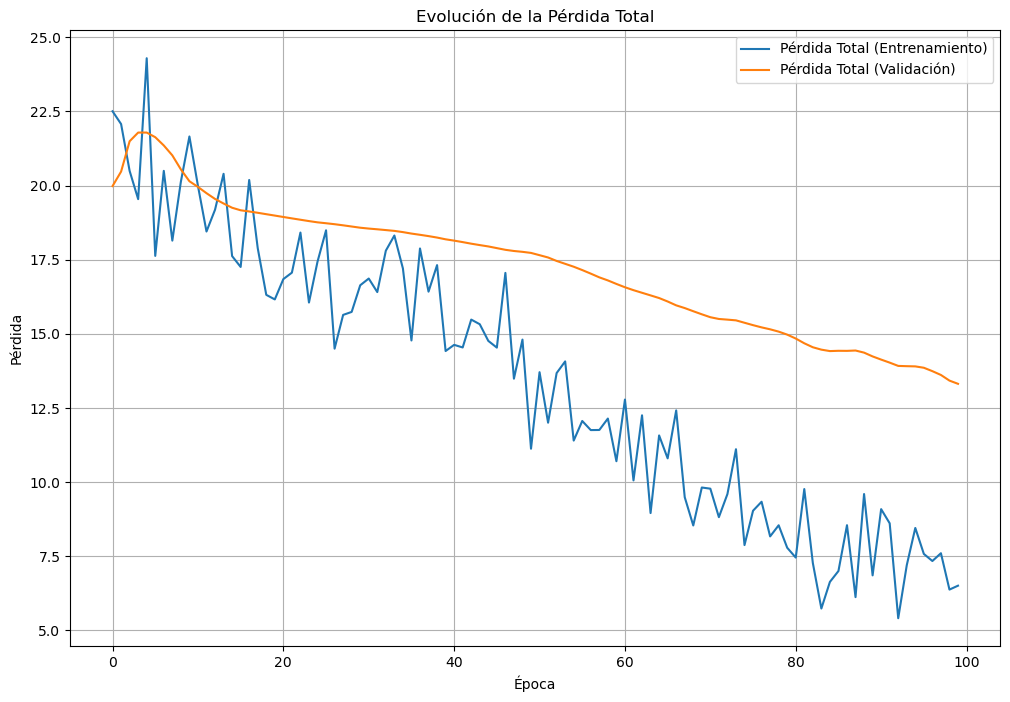

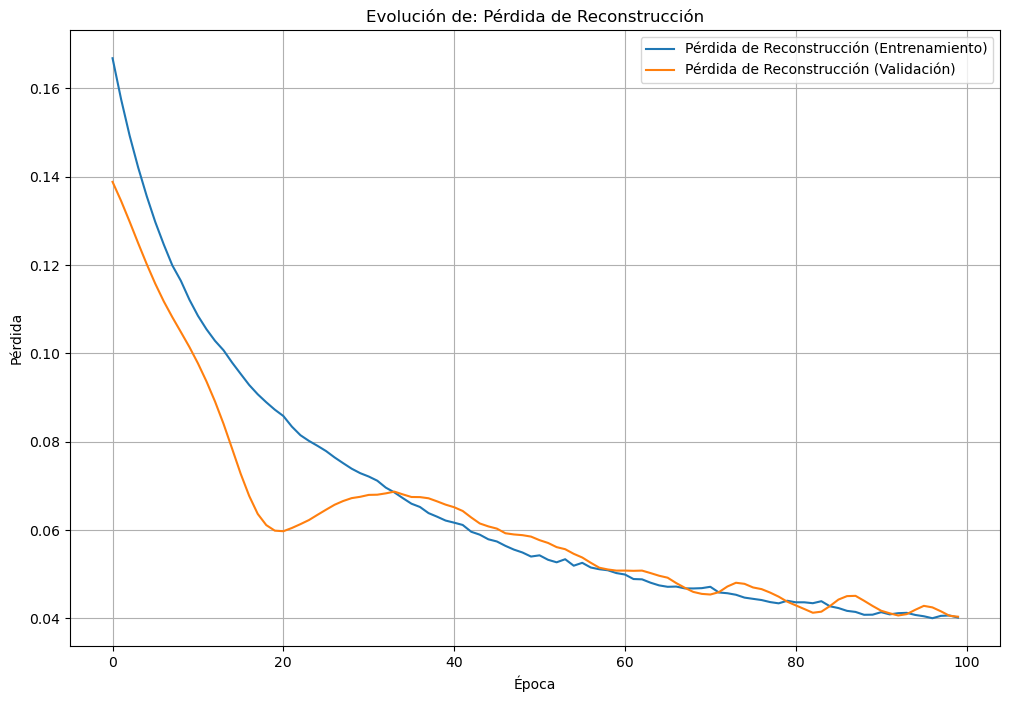

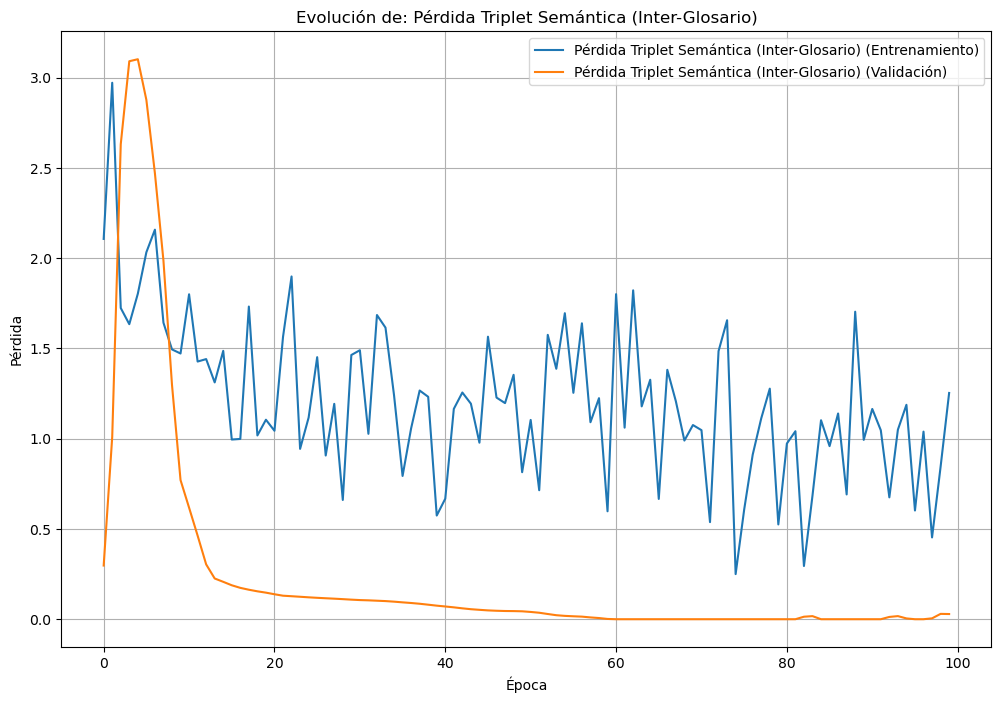

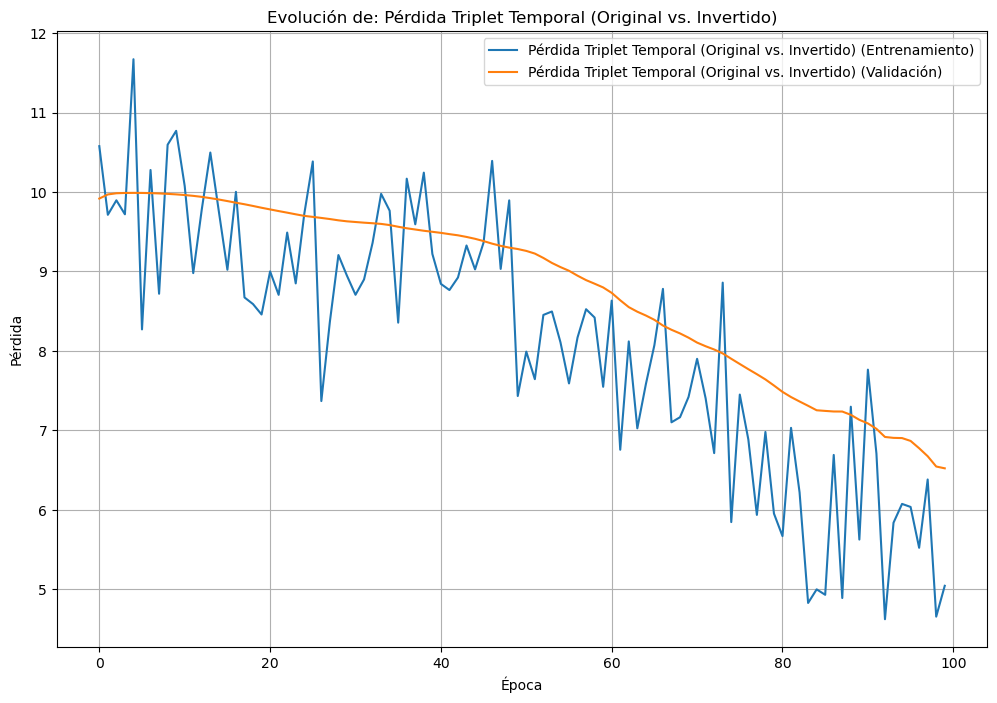

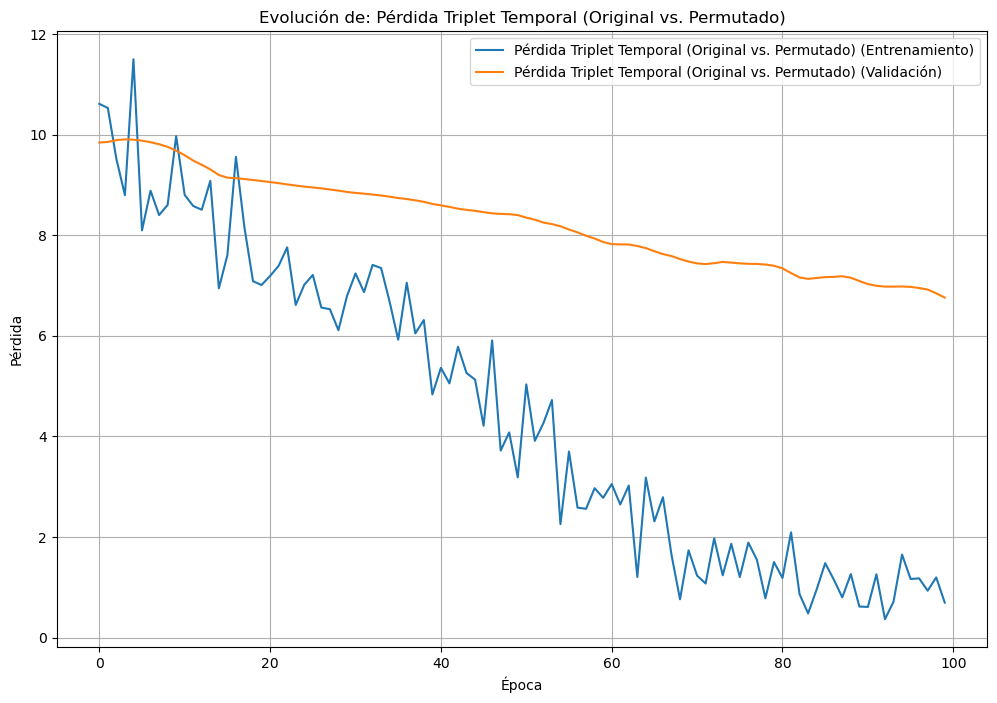

In [11]:
def plot_training_metrics(history, output_dir):
    """
    Genera y guarda las gráficas de las métricas de entrenamiento y validación.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # --- 1. Gráfica de Pérdida Total ---
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['total_loss'], label='Pérdida Total (Entrenamiento)')
    plt.plot(history.history['val_total_loss'], label='Pérdida Total (Validación)')
    plt.title('Evolución de la Pérdida Total')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, '1_total_loss_evolution.png'))
    plt.show()

    # --- 2. Gráficas de Componentes de Pérdida ---
    # Diccionario corregido
    loss_components = {
        'recon_loss': 'Pérdida de Reconstrucción',
        'inter_gloss_triplet_loss': 'Pérdida Triplet Semántica (Inter-Glosario)',
        'temporal_inv_triplet_loss': 'Pérdida Triplet Temporal (Original vs. Invertido)',
        'temporal_perm_triplet_loss': 'Pérdida Triplet Temporal (Original vs. Permutado)',
    }

    for key, title in loss_components.items():
        plt.figure(figsize=(12, 8))
        plt.plot(history.history[key], label=f'{title} (Entrenamiento)')
        plt.plot(history.history[f'val_{key}'], label=f'{title} (Validación)')
        plt.title(f'Evolución de: {title}')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'2_{key}_evolution.png'))
        plt.show()

# --- Llamada a la función ---
# Asegúrate de que la variable "history" exista de la celda de entrenamiento anterior
print("\\n[Paso Adicional] Generando gráficas de las métricas de entrenamiento...")
plot_training_metrics(history, OUTPUT_VIZ_DIR)

\n[Paso Adicional] Generando gráficas de la evolución del espacio latente...


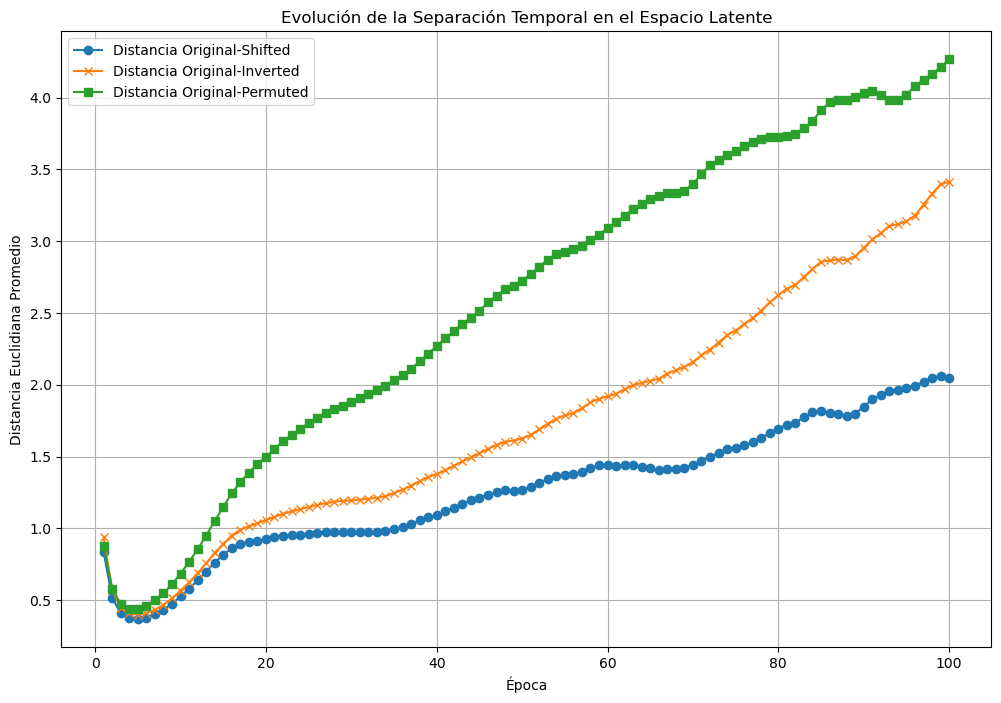

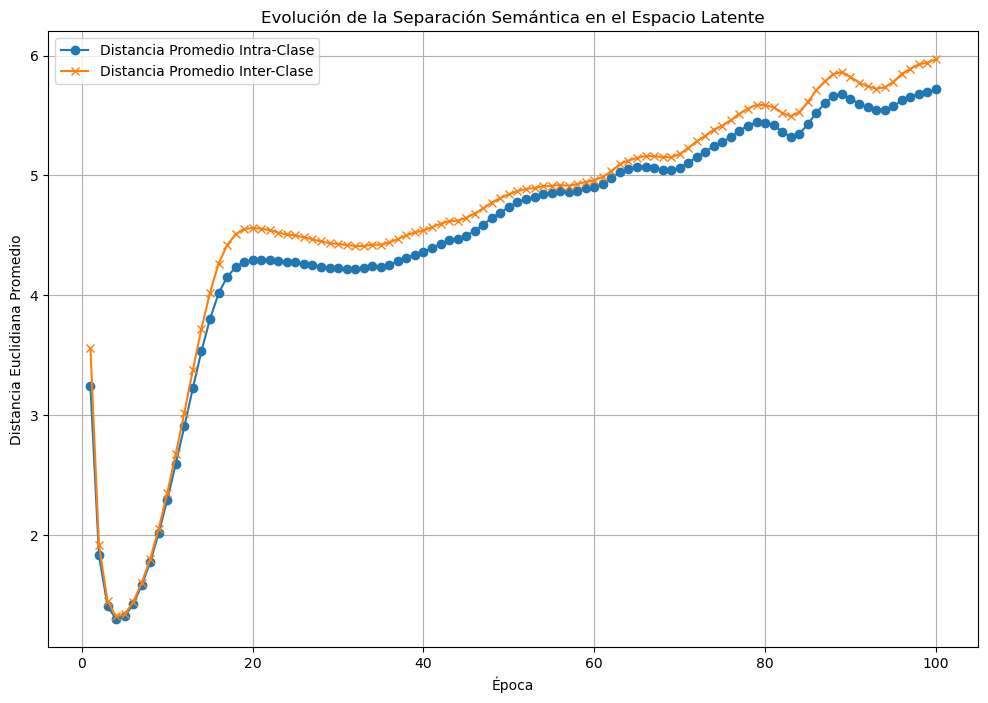

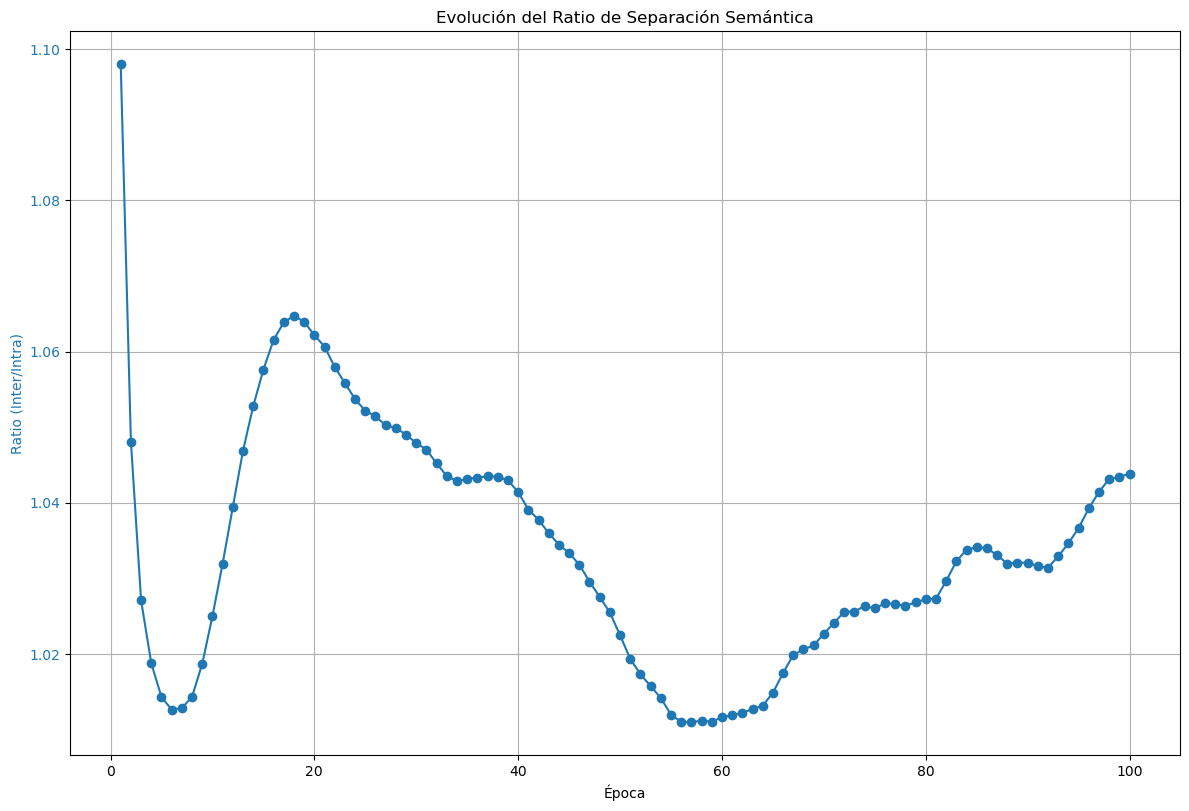

In [12]:
def plot_latent_space_evolution(evaluator_callback, output_dir):
    """
    Genera y guarda las gráficas de la evolución de las métricas del espacio latente.
    """
    history = evaluator_callback.history
    epochs = range(1, len(history['dist_orig_shifted']) + 1)

    # --- 1. Gráfica de Separación Temporal ---
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['dist_orig_shifted'], label='Distancia Original-Shifted', marker='o')
    plt.plot(epochs, history['dist_orig_inverted'], label='Distancia Original-Inverted', marker='x')
    plt.plot(epochs, history['dist_orig_permuted'], label='Distancia Original-Permuted', marker='s')
    plt.title('Evolución de la Separación Temporal en el Espacio Latente')
    plt.xlabel('Época')
    plt.ylabel('Distancia Euclidiana Promedio')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, '3_temporal_separation_evolution.png'))
    plt.show()
    
    # --- 2. Gráfica de Separación Semántica ---
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history['dist_intra_class'], label='Distancia Promedio Intra-Clase', marker='o')
    plt.plot(epochs, history['dist_inter_class'], label='Distancia Promedio Inter-Clase', marker='x')
    plt.title('Evolución de la Separación Semántica en el Espacio Latente')
    plt.xlabel('Época')
    plt.ylabel('Distancia Euclidiana Promedio')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, '4_semantic_separation_evolution.png'))
    plt.show()

    # --- 3. Gráfica del Ratio Semántico ---
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Ratio (Inter/Intra)', color='tab:blue')
    ax1.plot(epochs, history['semantic_ratio'], color='tab:blue', marker='o', label='Ratio Semántico')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    fig.tight_layout()
    plt.title('Evolución del Ratio de Separación Semántica')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, '5_semantic_ratio_evolution.png'))
    plt.show()


# --- Llamada a la función ---
print("\\n[Paso Adicional] Generando gráficas de la evolución del espacio latente...")
plot_latent_space_evolution(latent_evaluator_callback, OUTPUT_VIZ_DIR)


[Paso Adicional] Generando gráficas de las métricas de entrenamiento con baseline...


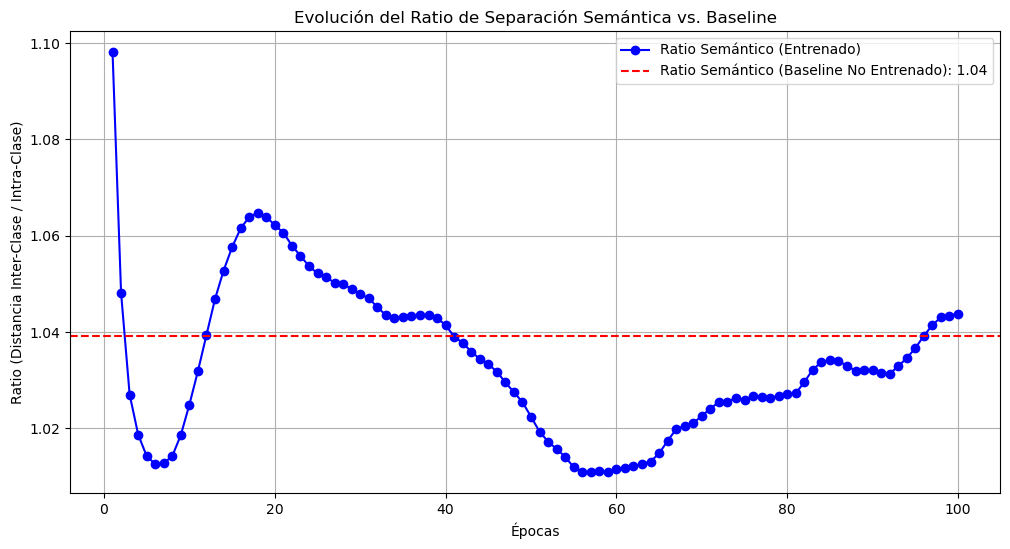

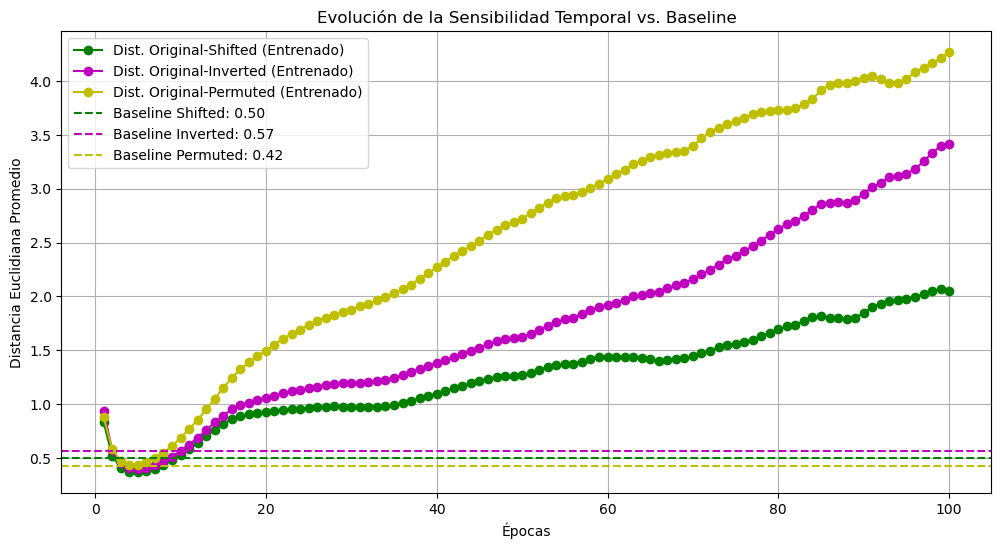

In [13]:
print("\n[Paso Adicional] Generando gráficas de las métricas de entrenamiento con baseline...")

def plot_semantic_separation_with_baseline(history_callback, baseline_metrics):
    """
    Genera una nueva gráfica para el Ratio de Separación Semántica
    comparando el modelo entrenado con el baseline no entrenado.
    """
    epochs = range(1, len(history_callback.history['semantic_ratio']) + 1)

    plt.figure(figsize=(12, 6))

    # Gráfica del modelo entrenado
    plt.plot(epochs, history_callback.history['semantic_ratio'], 'b-o', label='Ratio Semántico (Entrenado)')

    # Línea horizontal para el baseline
    baseline_value = baseline_metrics['semantic_ratio'][0]
    plt.axhline(y=baseline_value, color='r', linestyle='--', label=f"Ratio Semántico (Baseline No Entrenado): {baseline_value:.2f}")

    plt.title('Evolución del Ratio de Separación Semántica vs. Baseline')
    plt.xlabel('Épocas')
    plt.ylabel('Ratio (Distancia Inter-Clase / Intra-Clase)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_temporal_distance_with_baseline(history_callback, baseline_metrics):
    """
    Genera una nueva gráfica para la Distancia Temporal, mostrando cómo el modelo
    aprende a diferenciar secuencias temporalmente alteradas en comparación con el baseline.
    """
    epochs = range(1, len(history_callback.history['dist_orig_shifted']) + 1)

    plt.figure(figsize=(12, 6))

    # Gráficas del modelo entrenado
    plt.plot(epochs, history_callback.history['dist_orig_shifted'], 'g-o', label='Dist. Original-Shifted (Entrenado)')
    plt.plot(epochs, history_callback.history['dist_orig_inverted'], 'm-o', label='Dist. Original-Inverted (Entrenado)')
    plt.plot(epochs, history_callback.history['dist_orig_permuted'], 'y-o', label='Dist. Original-Permuted (Entrenado)')

    # Líneas horizontales para el baseline
    baseline_shifted = baseline_metrics['dist_orig_shifted'][0]
    baseline_inverted = baseline_metrics['dist_orig_inverted'][0]
    baseline_permuted = baseline_metrics['dist_orig_permuted'][0]

    plt.axhline(y=baseline_shifted, color='g', linestyle='--', label=f'Baseline Shifted: {baseline_shifted:.2f}')
    plt.axhline(y=baseline_inverted, color='m', linestyle='--', label=f'Baseline Inverted: {baseline_inverted:.2f}')
    plt.axhline(y=baseline_permuted, color='y', linestyle='--', label=f'Baseline Permuted: {baseline_permuted:.2f}')

    plt.title('Evolución de la Sensibilidad Temporal vs. Baseline')
    plt.xlabel('Épocas')
    plt.ylabel('Distancia Euclidiana Promedio')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Llamadas para generar las gráficas ---
# 'latent_evaluator_callback' es el callback de tu modelo entrenado que ya se ejecutó.
# 'baseline_metrics' es el diccionario que obtuvimos en el paso anterior.

plot_semantic_separation_with_baseline(latent_evaluator_callback, baseline_metrics)
plot_temporal_distance_with_baseline(latent_evaluator_callback, baseline_metrics)


--- [Paso Adicional] Generando Gráfica Comparativa de Pérdida Total ---


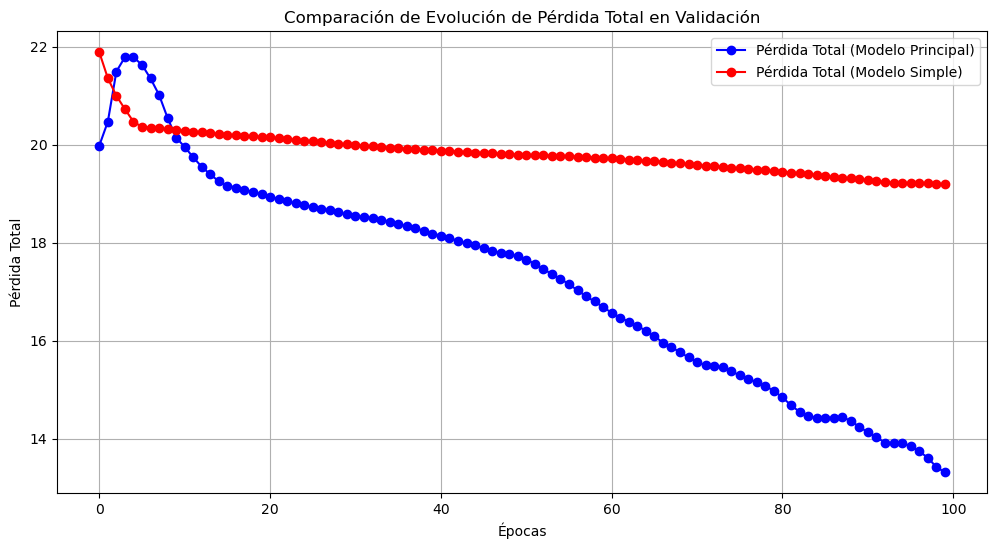

In [14]:
print("\n--- [Paso Adicional] Generando Gráfica Comparativa de Pérdida Total ---")

def plot_total_loss_comparison(history_main, history_simple):
    """
    Genera una nueva gráfica comparando la pérdida total en validación
    del modelo principal contra el modelo baseline (simple).
    """
    # Verificar que ambos historiales existen antes de graficar
    if not history_main or not hasattr(history_main, 'history') or 'val_total_loss' not in history_main.history:
        print("Advertencia: No se encontró el historial del modelo principal para graficar.")
        return
    if not history_simple or not hasattr(history_simple, 'history') or 'val_total_loss' not in history_simple.history:
        print("Advertencia: No se encontró el historial del modelo simple para graficar.")
        return

    plt.figure(figsize=(12, 6))

    # Pérdida del modelo principal
    plt.plot(history_main.history['val_total_loss'], 'b-o', label='Pérdida Total (Modelo Principal)')

    # Pérdida del modelo baseline (simple)
    plt.plot(history_simple.history['val_total_loss'], 'r-o', label='Pérdida Total (Modelo Simple)')

    plt.title('Comparación de Evolución de Pérdida Total en Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida Total')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Llamada para generar la gráfica ---
# 'history' es el historial de tu modelo principal.
# 'history_simple' es el del modelo simple que acabas de entrenar.
plot_total_loss_comparison(history, history_simple)

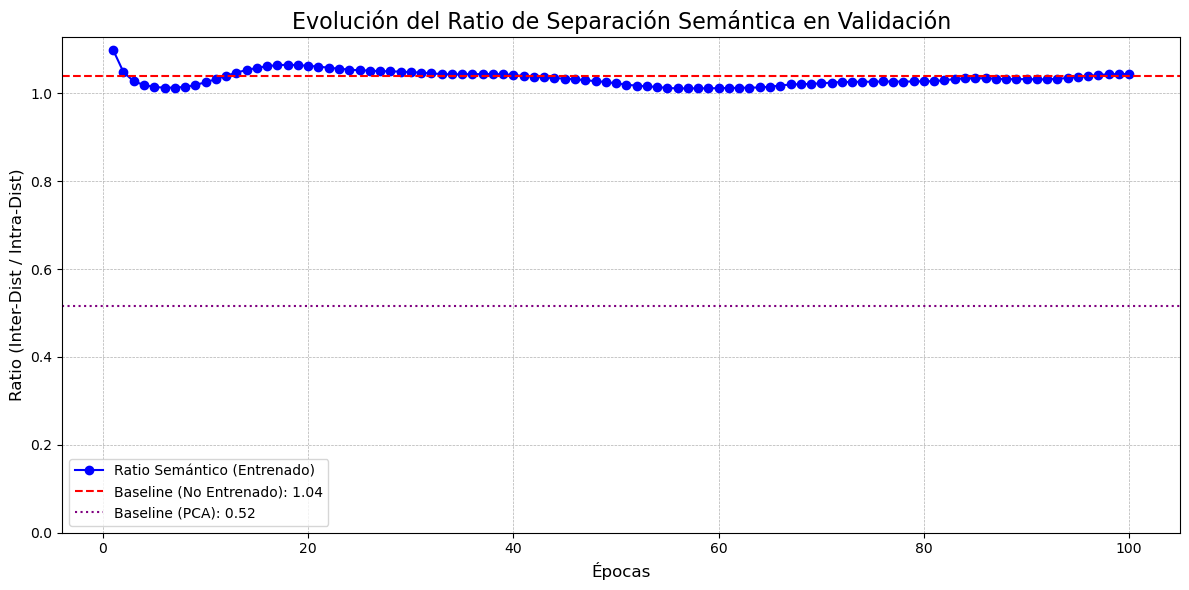

In [15]:
def plot_semantic_separation_ratio(history_callback, baseline_metrics, pca_ratio):
    # Extraemos el ratio del baseline no entrenado DEL DICCIONARIO
    untrained_ratio = baseline_metrics['semantic_ratio'][0]
    
    epochs = range(1, len(history_callback.history['semantic_ratio']) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history_callback.history['semantic_ratio'], 'b-o', label='Ratio Semántico (Entrenado)')
    
    # Ahora usamos la variable local 'untrained_ratio' que tiene el valor correcto
    plt.axhline(y=untrained_ratio, color='r', linestyle='--', label=f'Baseline (No Entrenado): {untrained_ratio:.2f}')
    plt.axhline(y=pca_ratio, color='purple', linestyle=':', label=f'Baseline (PCA): {pca_ratio:.2f}')
    
    plt.title('Evolución del Ratio de Separación Semántica en Validación', fontsize=16)
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Ratio (Inter-Dist / Intra-Dist)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

# --- Llamada para generar la gráfica (también actualizada) ---
plot_semantic_separation_ratio(
    latent_evaluator_callback,
    baseline_metrics, # Pasamos el diccionario completo con los resultados correctos
    semantic_ratio_pca
)


[Paso Final] Visualización del Espacio Latente en Diferentes Épocas
Se visualizarán las épocas: [5, 15, 25, 45, 65, 85]

--- Visualizando el MEJOR modelo (restaurado por EarlyStopping) ---

--- Visualizando Espacio Latente (Mejor Modelo) ---
Procesando 17 secuencias base para visualización...
Calculando vectores latentes...
Forma final de vectores latentes: (68, 256)
Reduciendo dimensionalidad con PCA...
Generando gráfico por Etiqueta y Transformación...


/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/best_model_restored/latent_space_by_gloss_pca.png


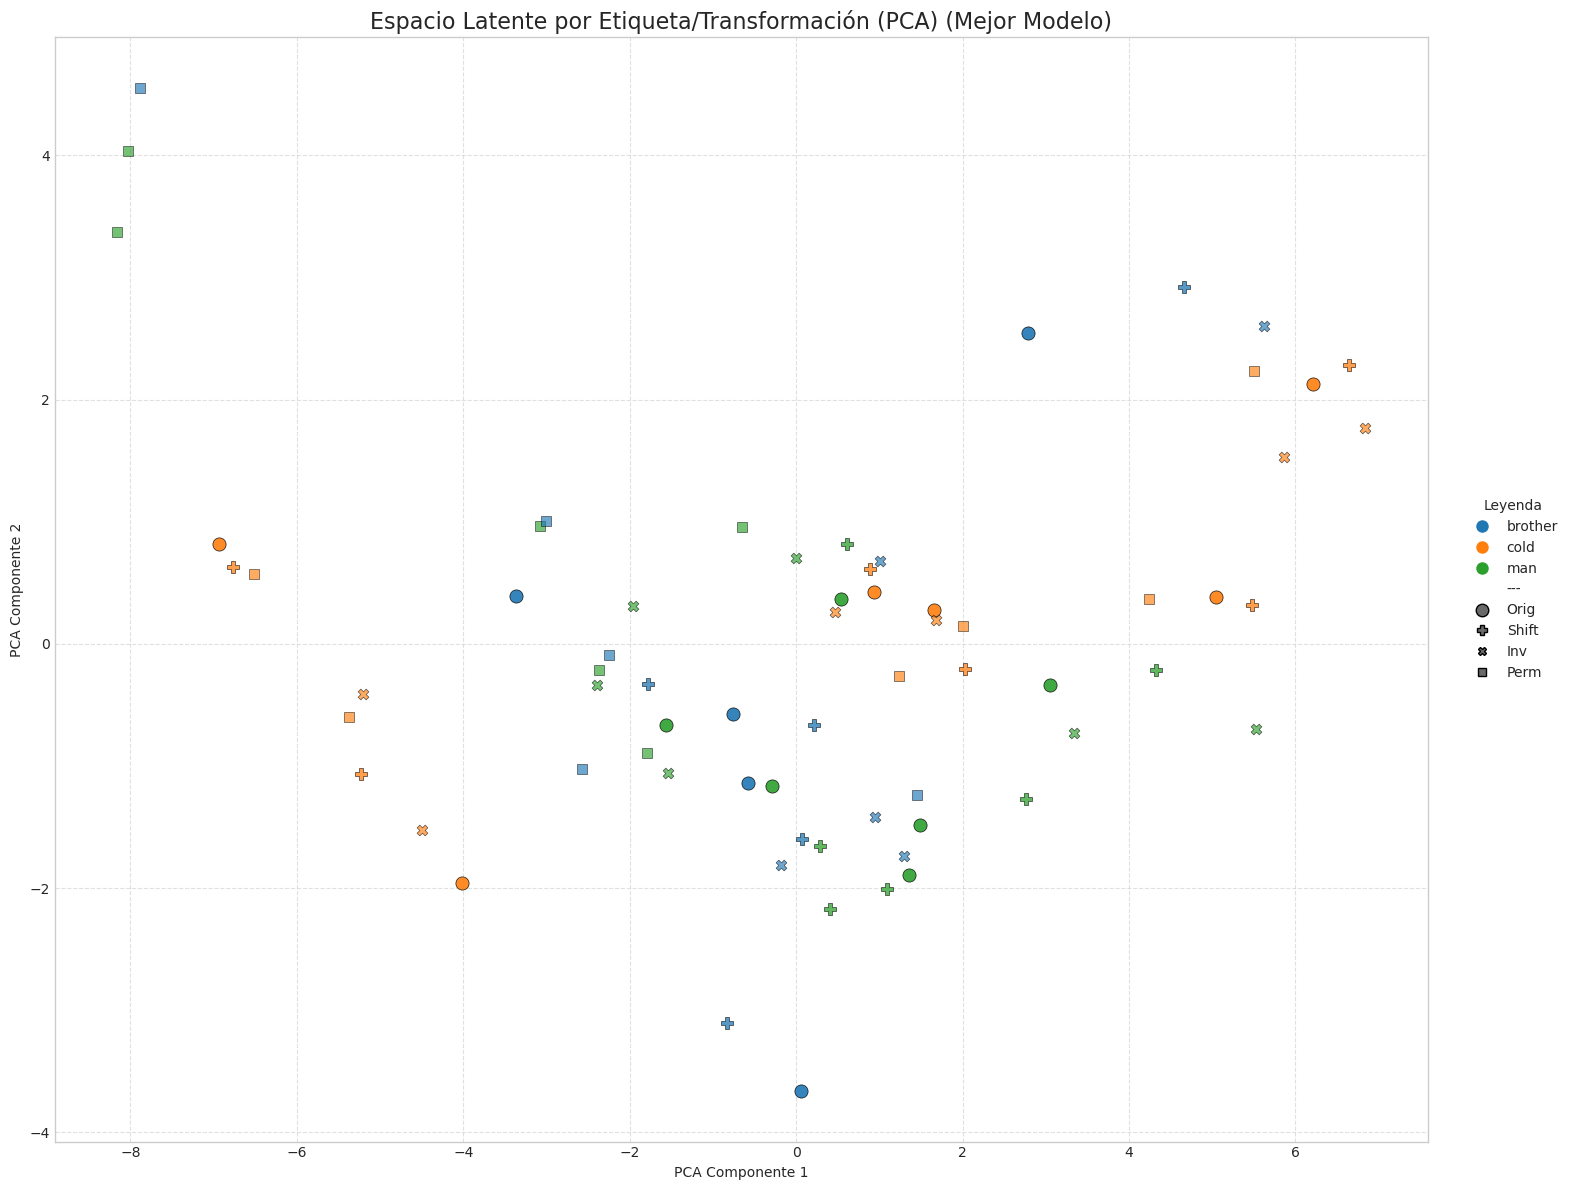

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/best_model_restored/latent_space_by_language_pca.png


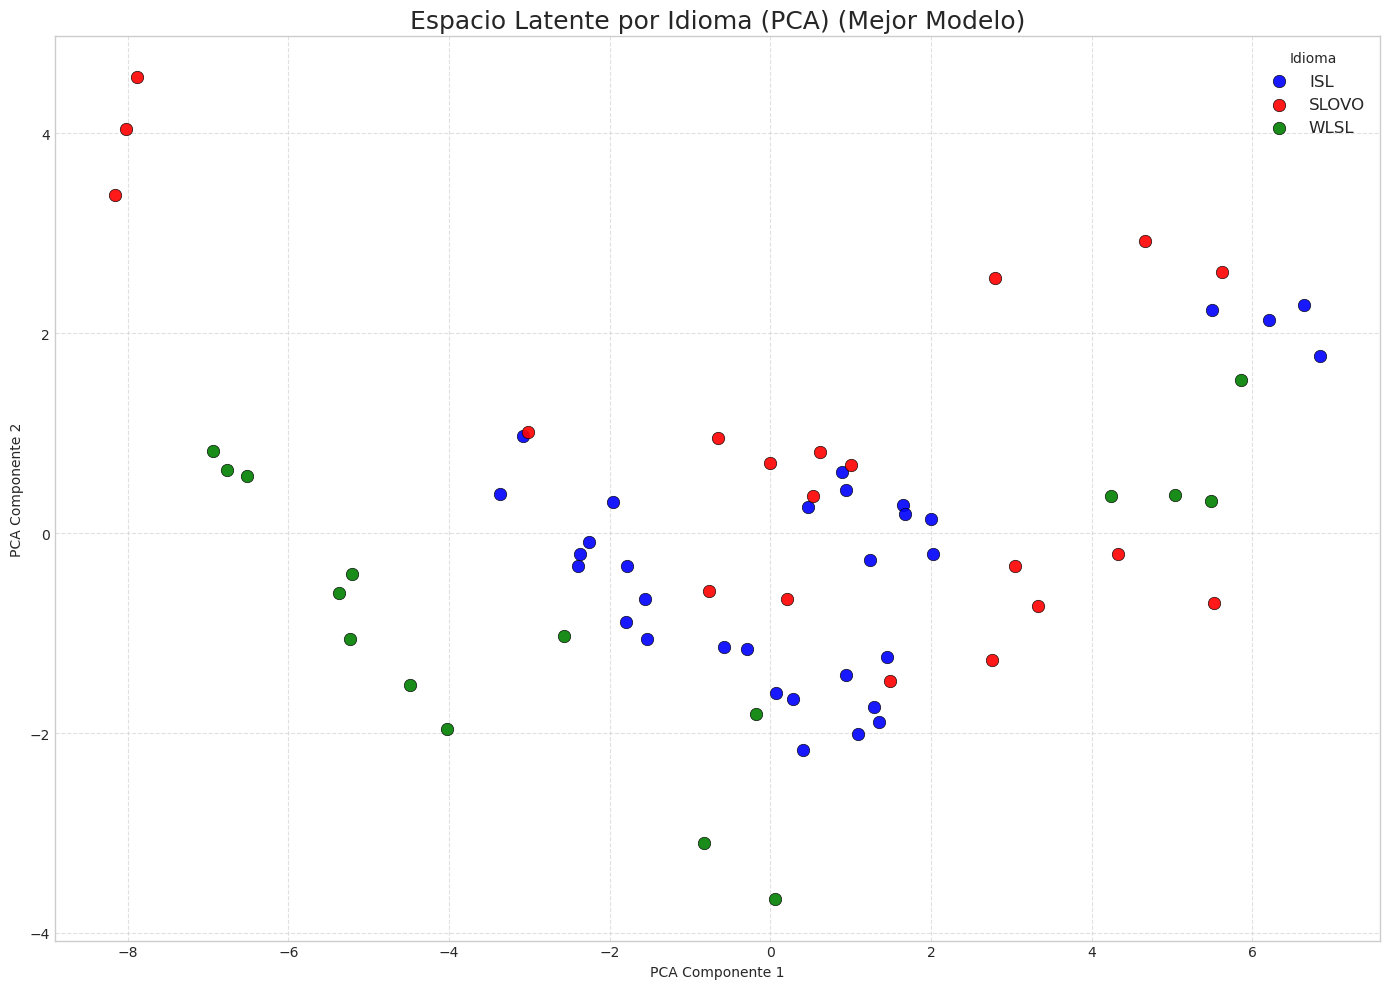

Reduciendo dimensionalidad con UMAP...


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Generando gráfico por Etiqueta y Transformación...


/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/best_model_restored/latent_space_by_gloss_umap.png


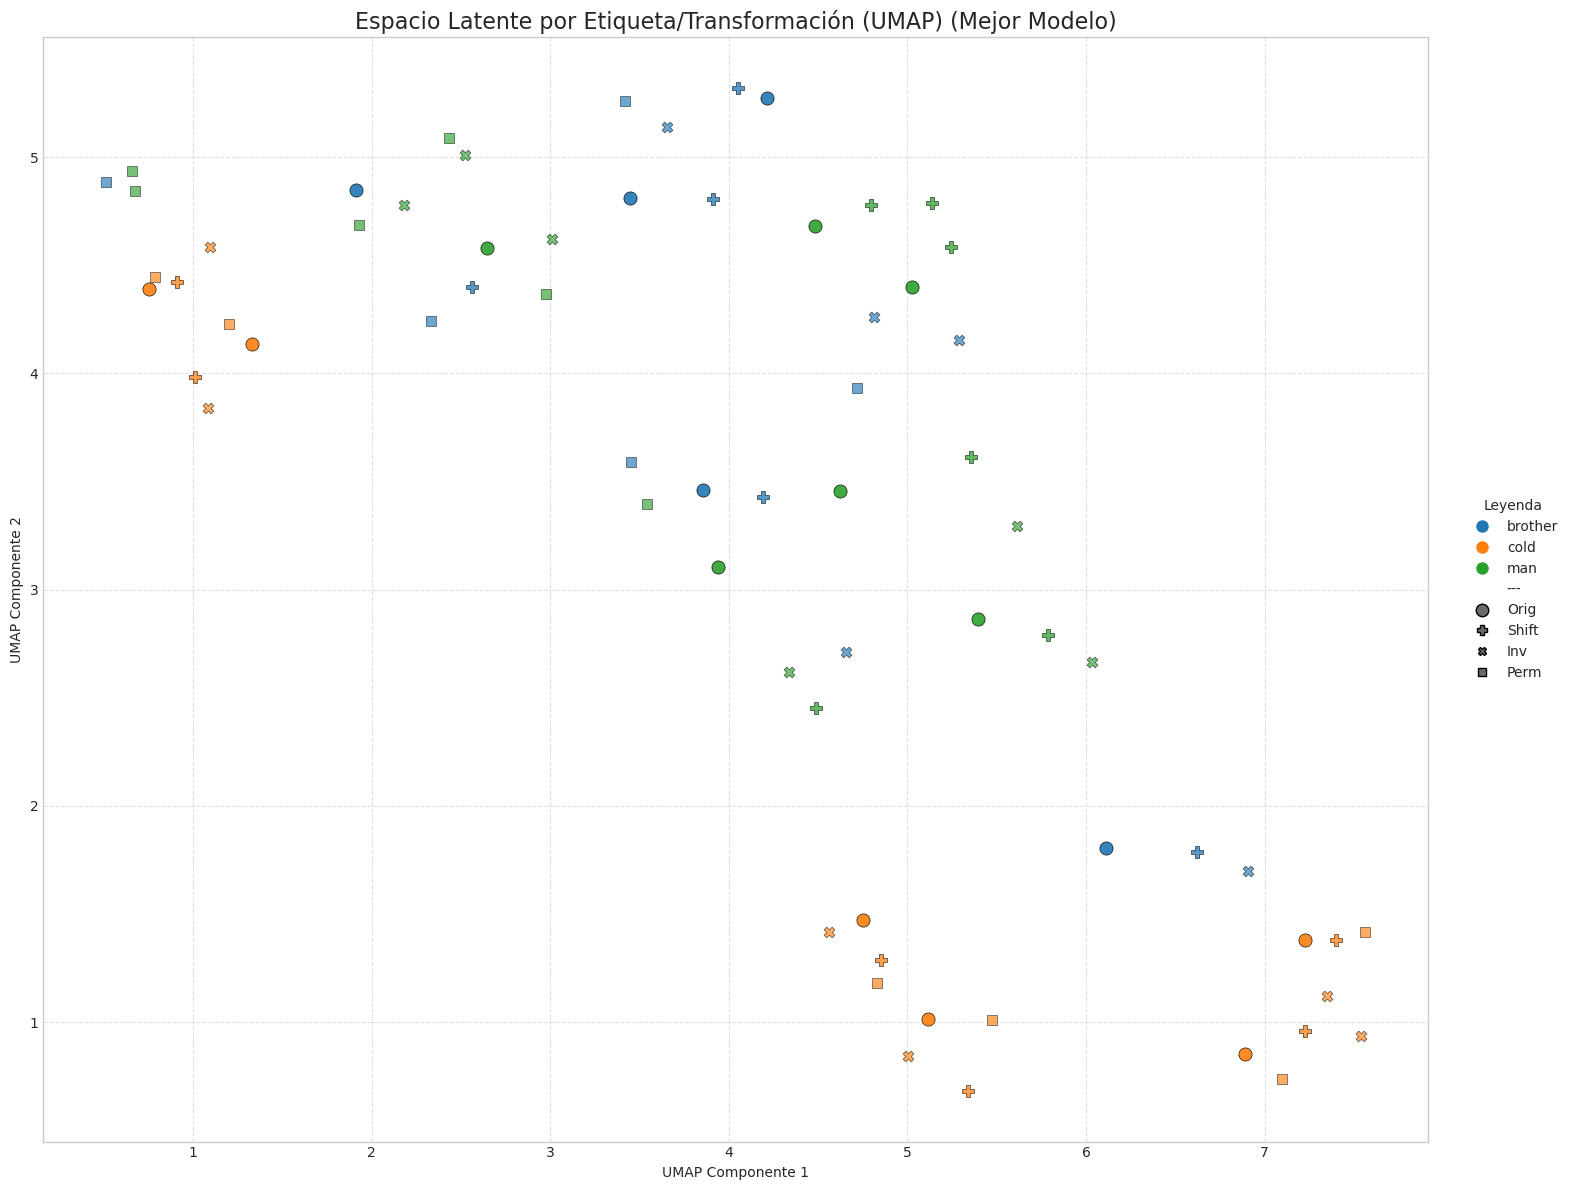

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/best_model_restored/latent_space_by_language_umap.png


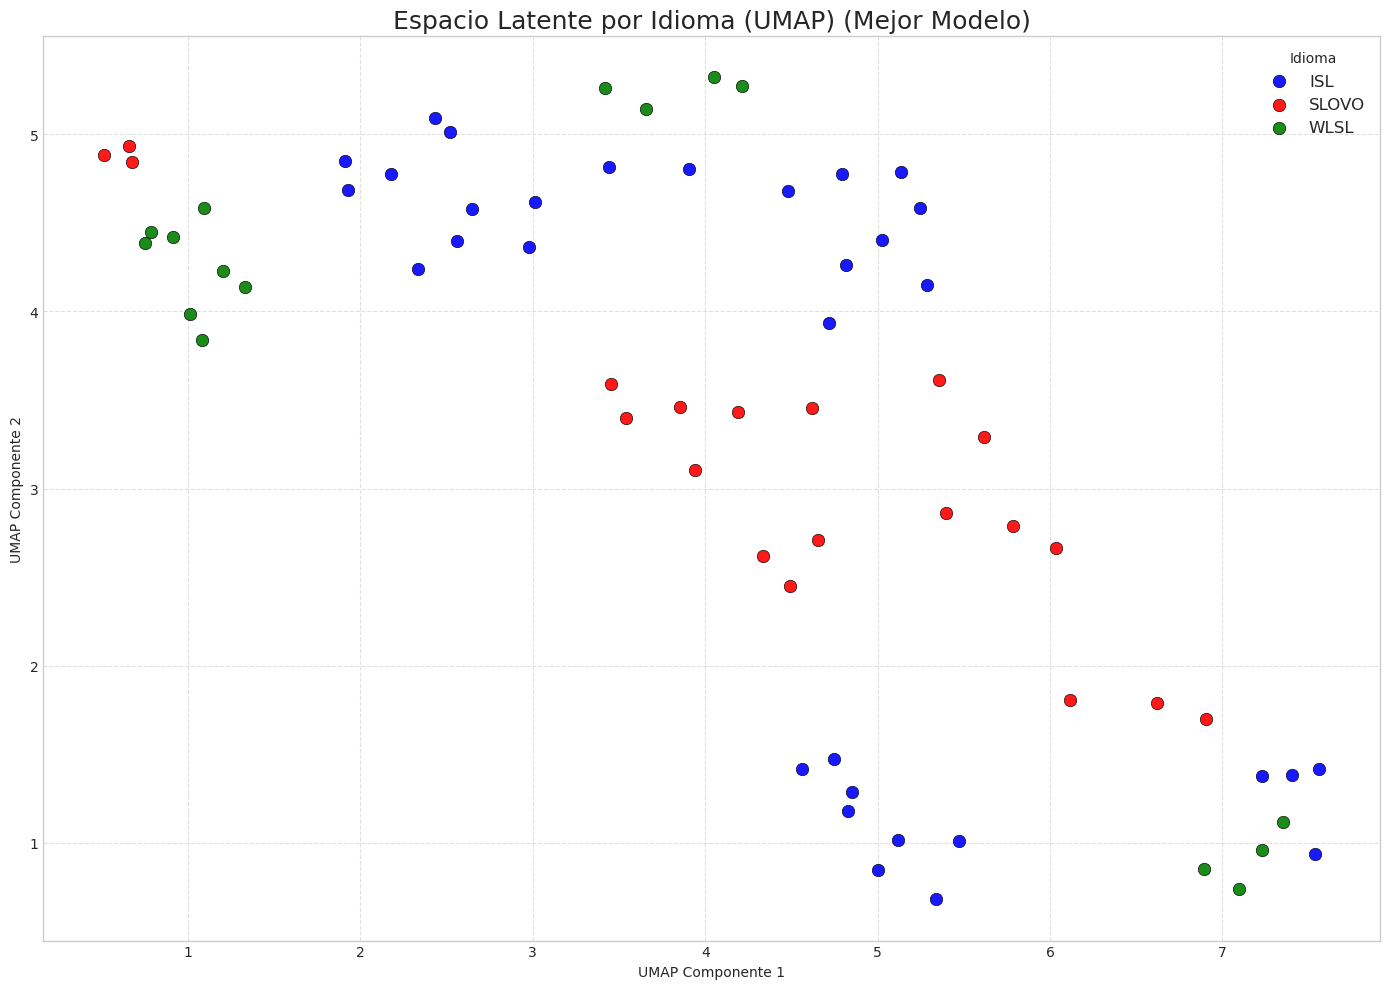


--- Visualizando checkpoints intermedios ---
Construyendo modelo Conv3D (más filtros) con resizing a: (7, 80, 60, 1)
Forma de entrada Autoencoder: (None, 7, 224, 224, 1)
Formas de salida Autoencoder: [TensorShape([None, 7, 224, 224, 1]), TensorShape([None, 7, 20, 15, 32])]

Procesando checkpoint de la época 5...

--- Visualizando Espacio Latente (Época 5) ---
Procesando 17 secuencias base para visualización...
Calculando vectores latentes...
Forma final de vectores latentes: (68, 256)
Reduciendo dimensionalidad con PCA...
Generando gráfico por Etiqueta y Transformación...


/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_05/latent_space_by_gloss_pca.png


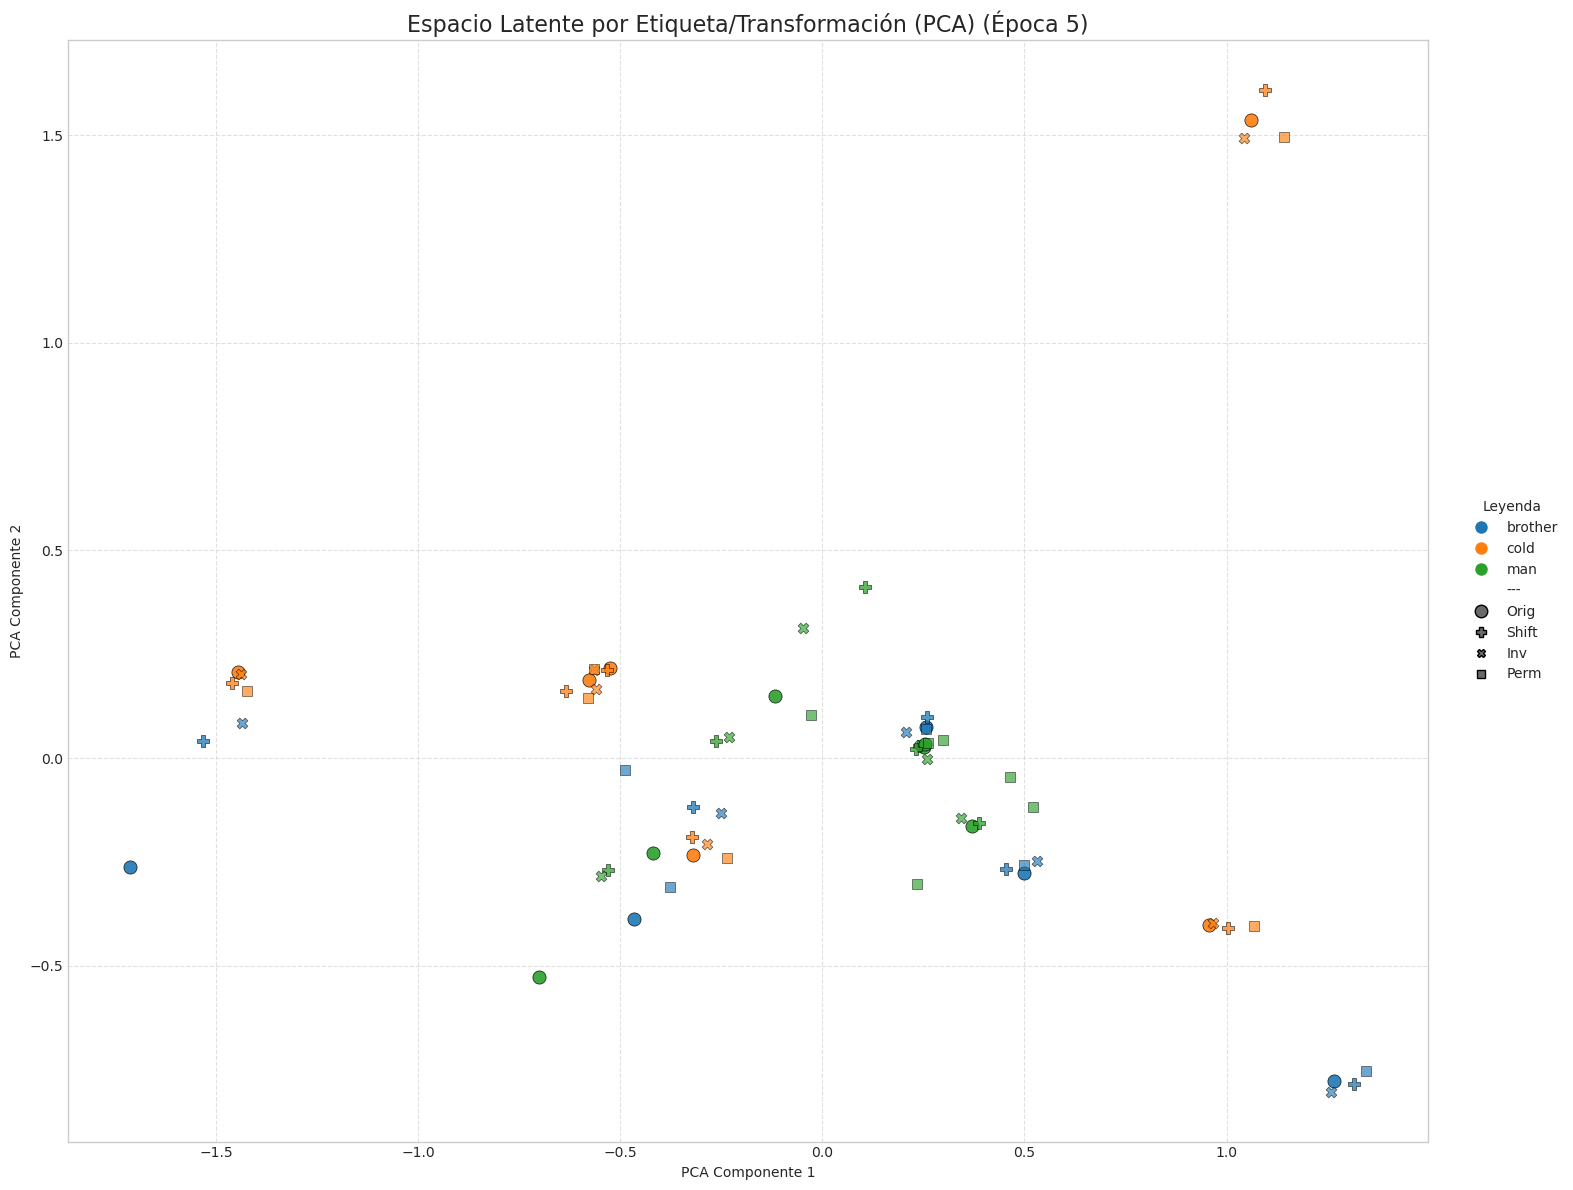

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_05/latent_space_by_language_pca.png


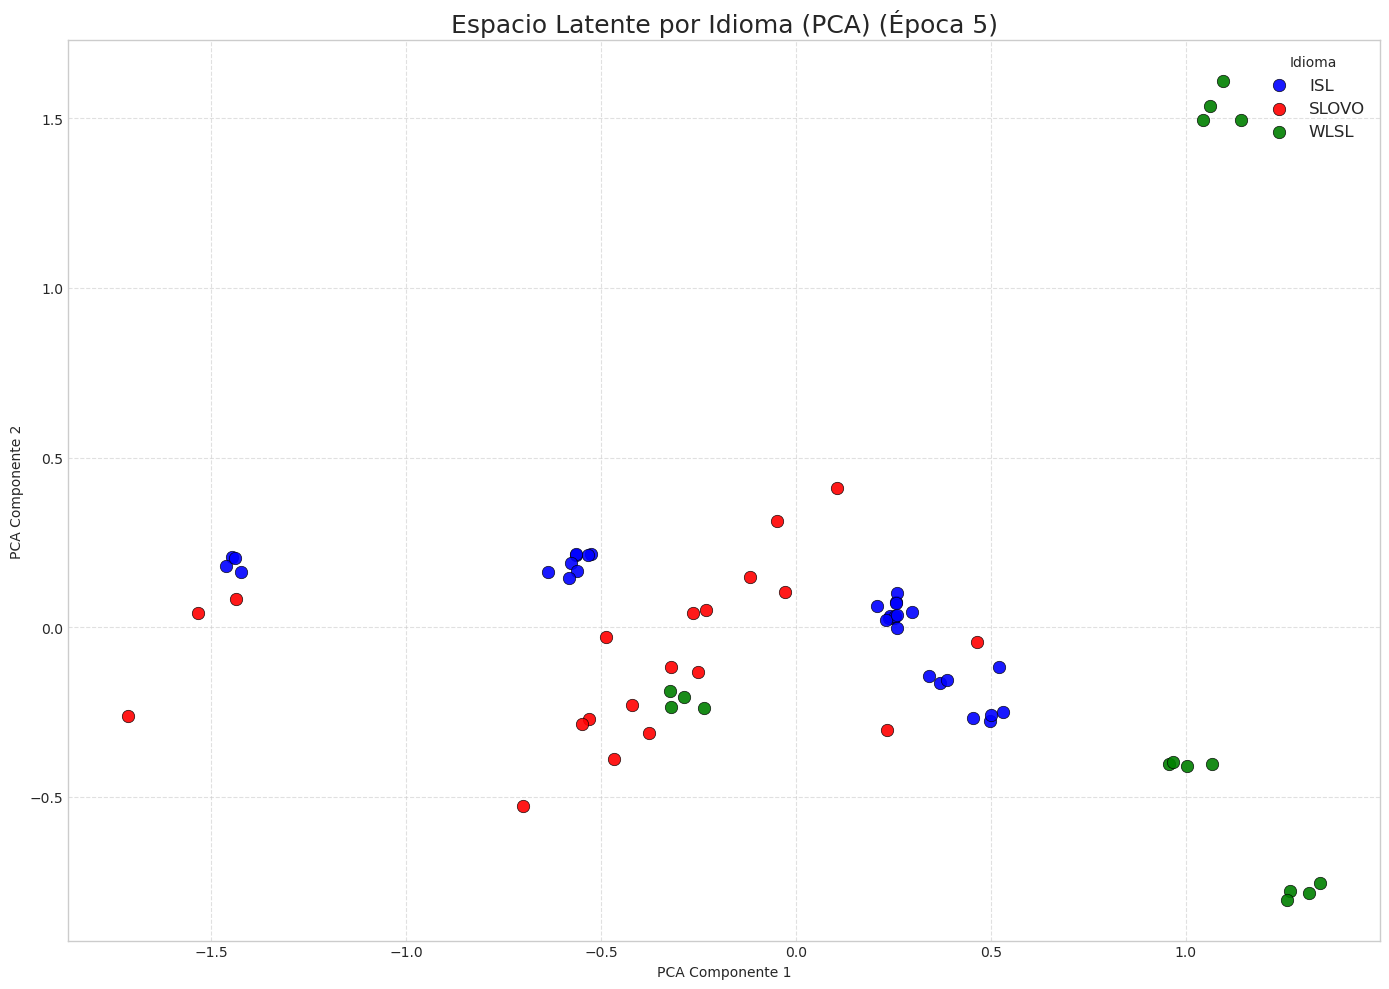

Reduciendo dimensionalidad con UMAP...
Generando gráfico por Etiqueta y Transformación...


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_05/latent_space_by_gloss_umap.png


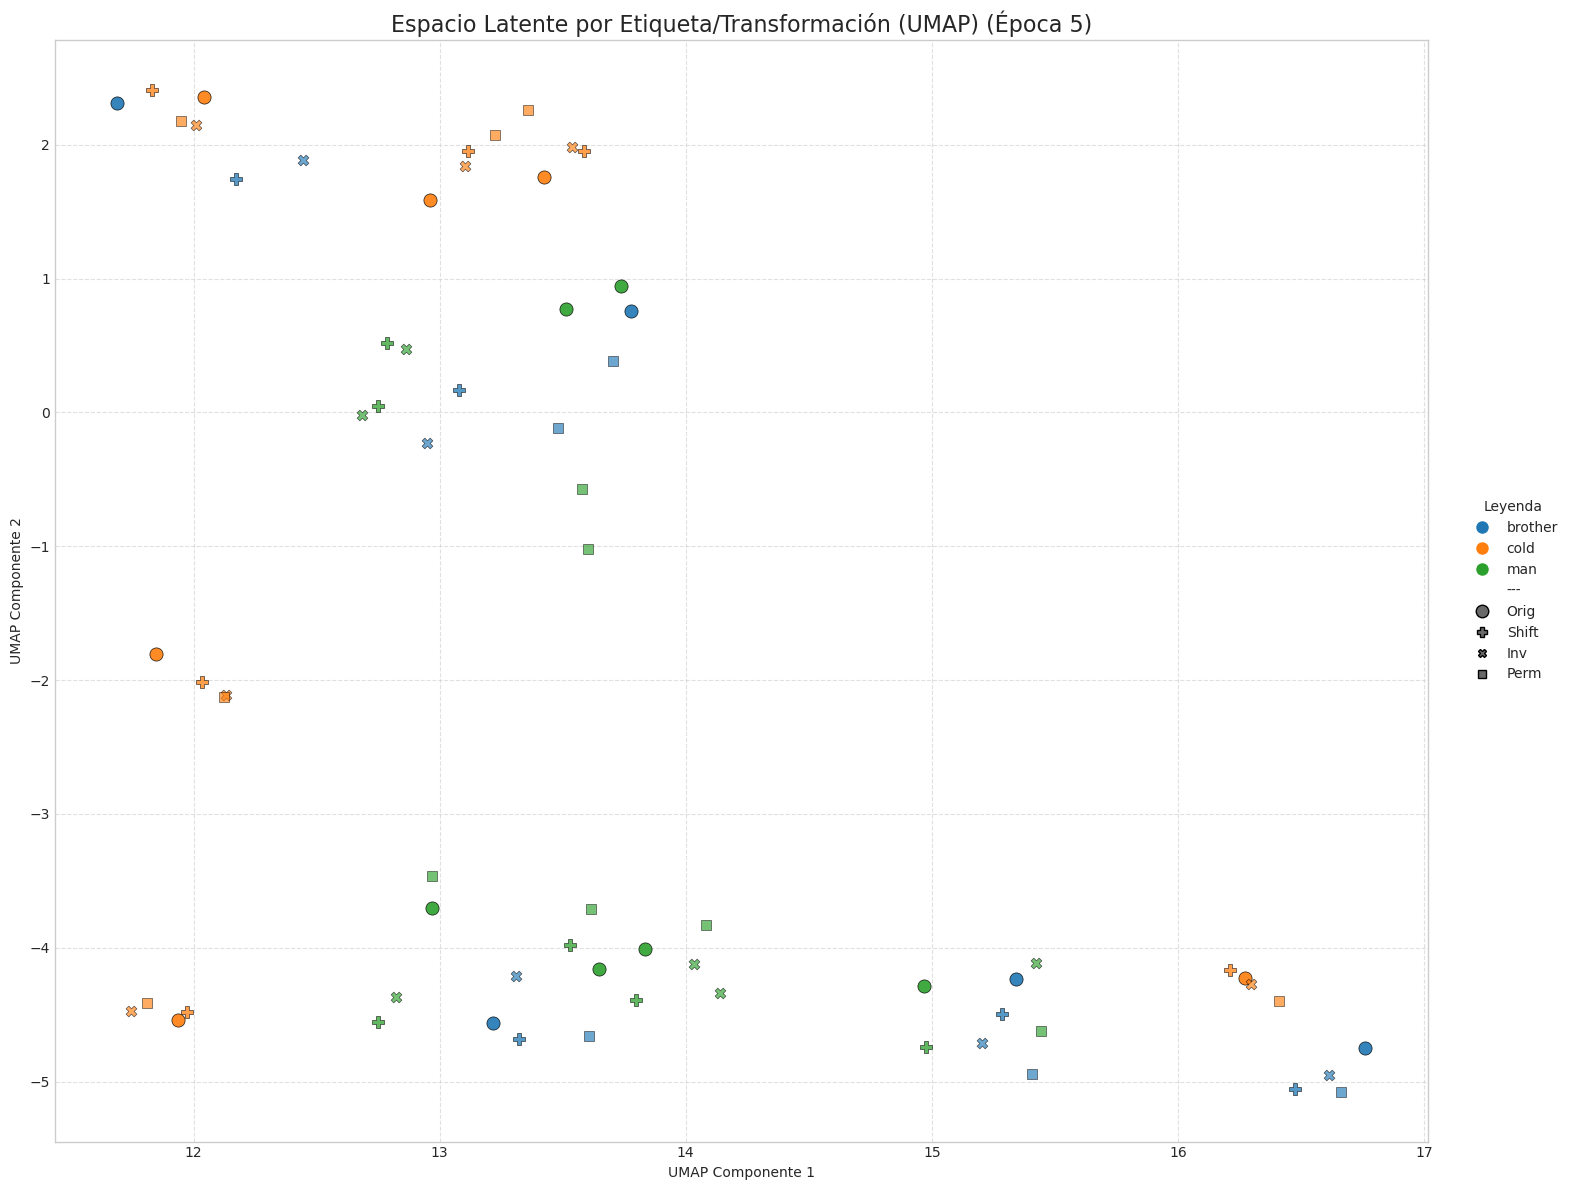

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_05/latent_space_by_language_umap.png


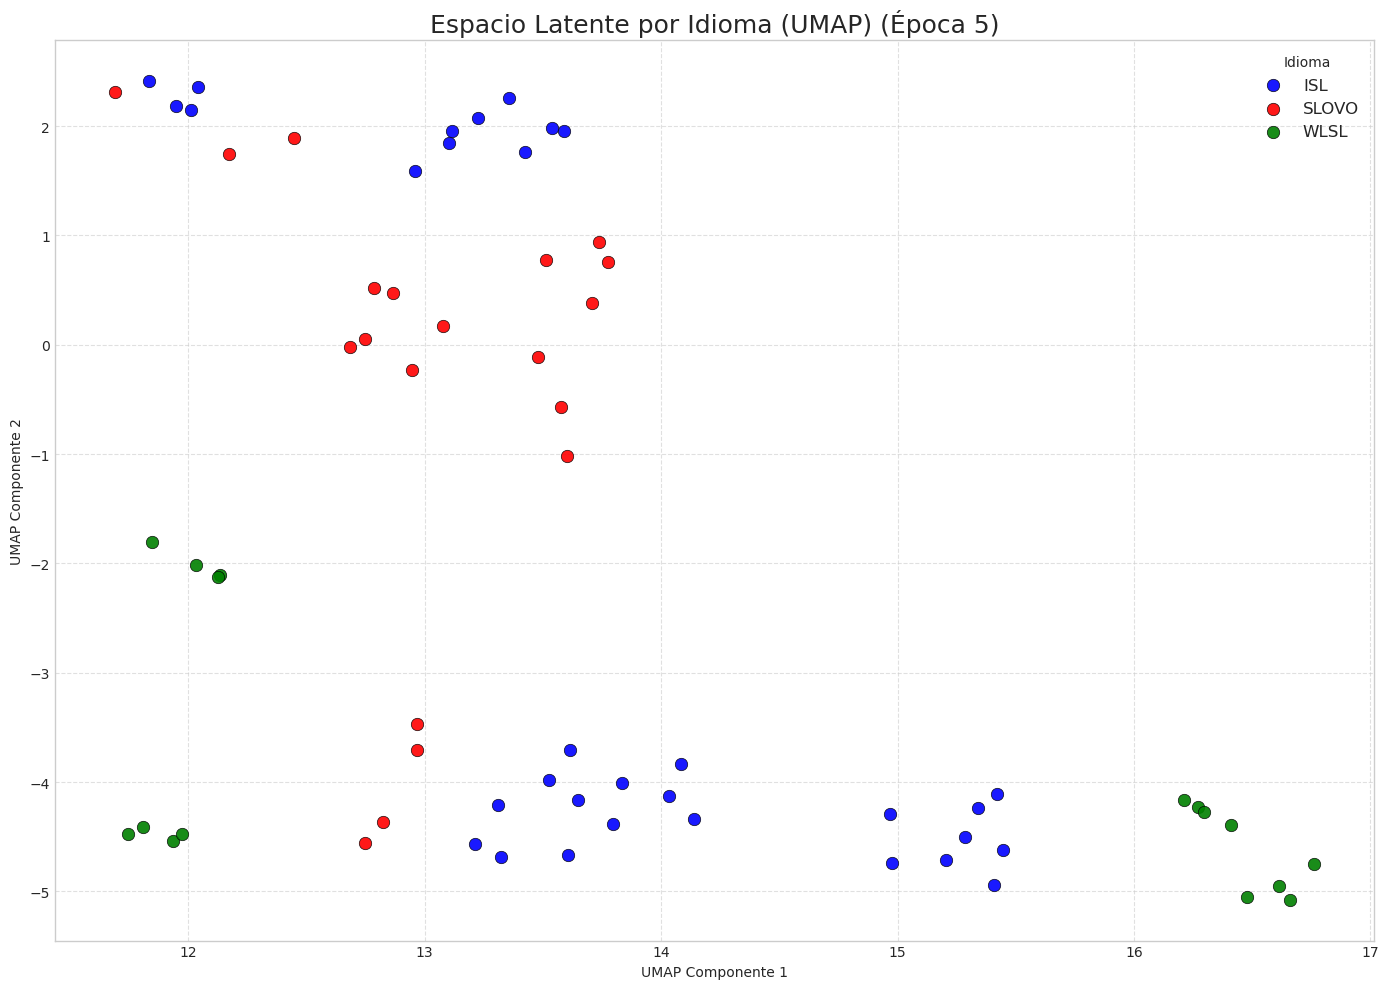


Procesando checkpoint de la época 15...

--- Visualizando Espacio Latente (Época 15) ---
Procesando 17 secuencias base para visualización...
Calculando vectores latentes...
Forma final de vectores latentes: (68, 256)
Reduciendo dimensionalidad con PCA...
Generando gráfico por Etiqueta y Transformación...


/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_15/latent_space_by_gloss_pca.png


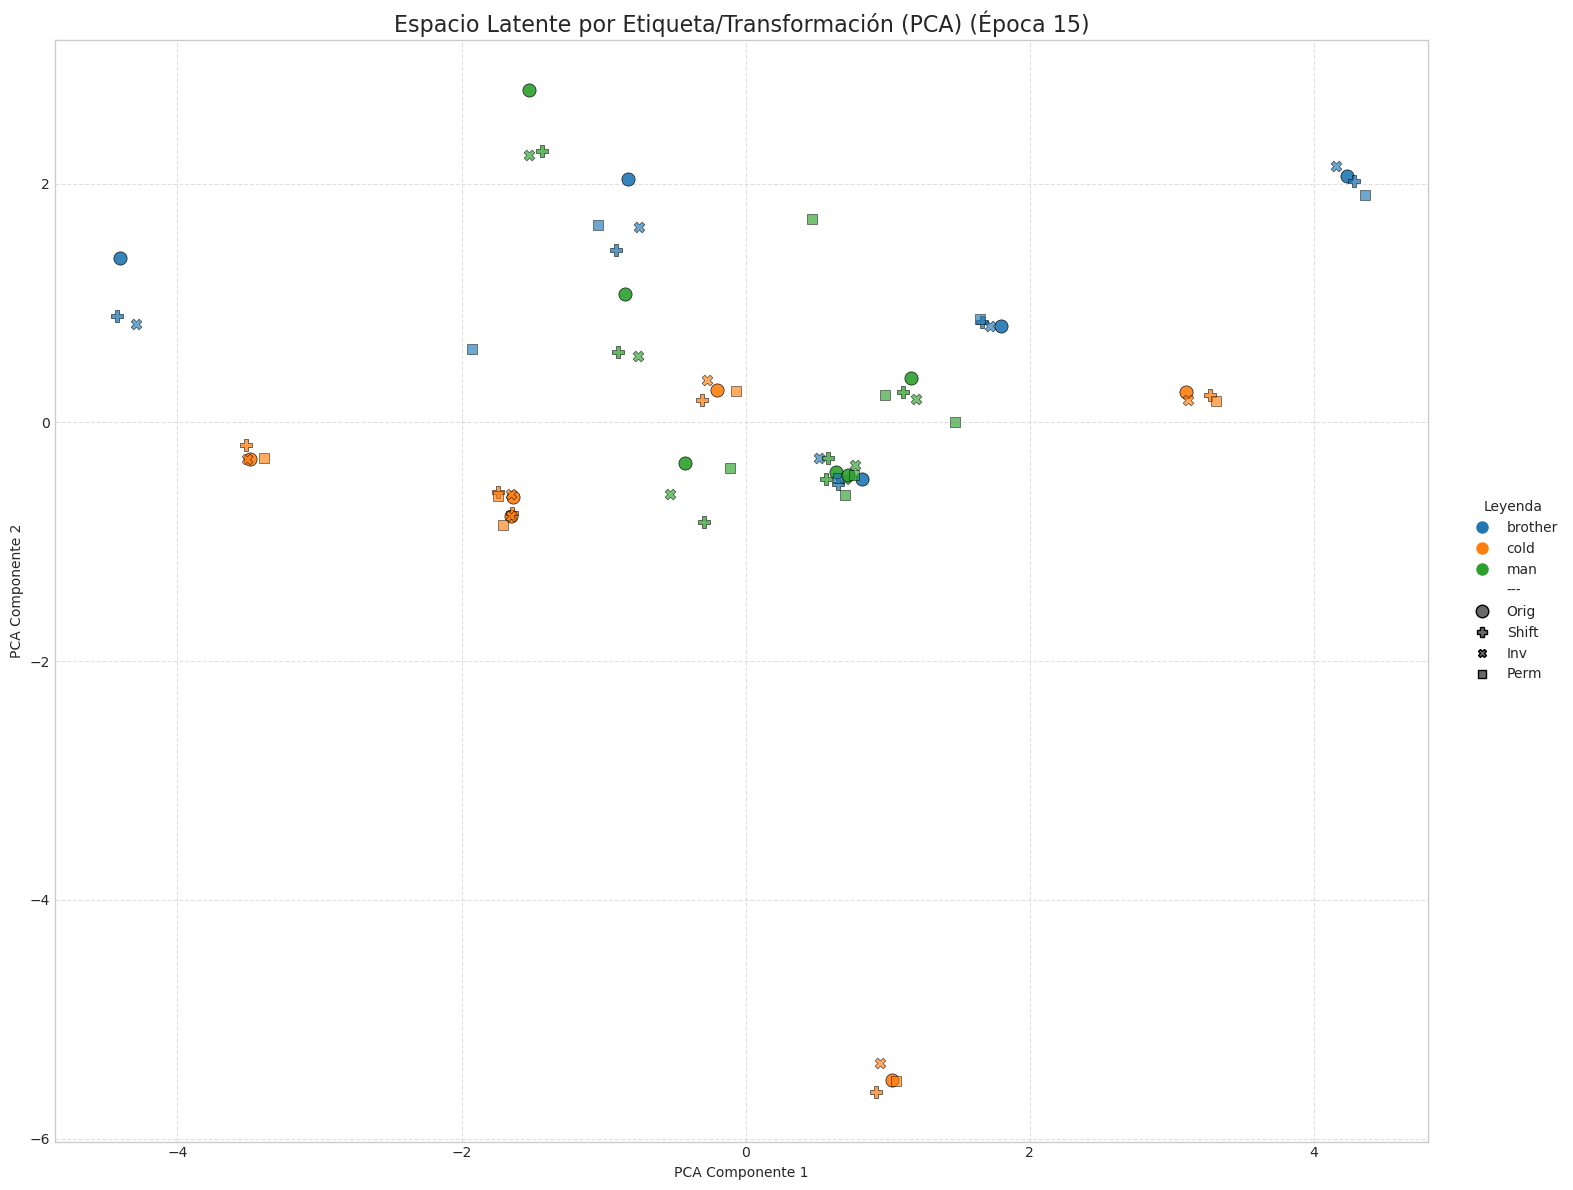

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_15/latent_space_by_language_pca.png


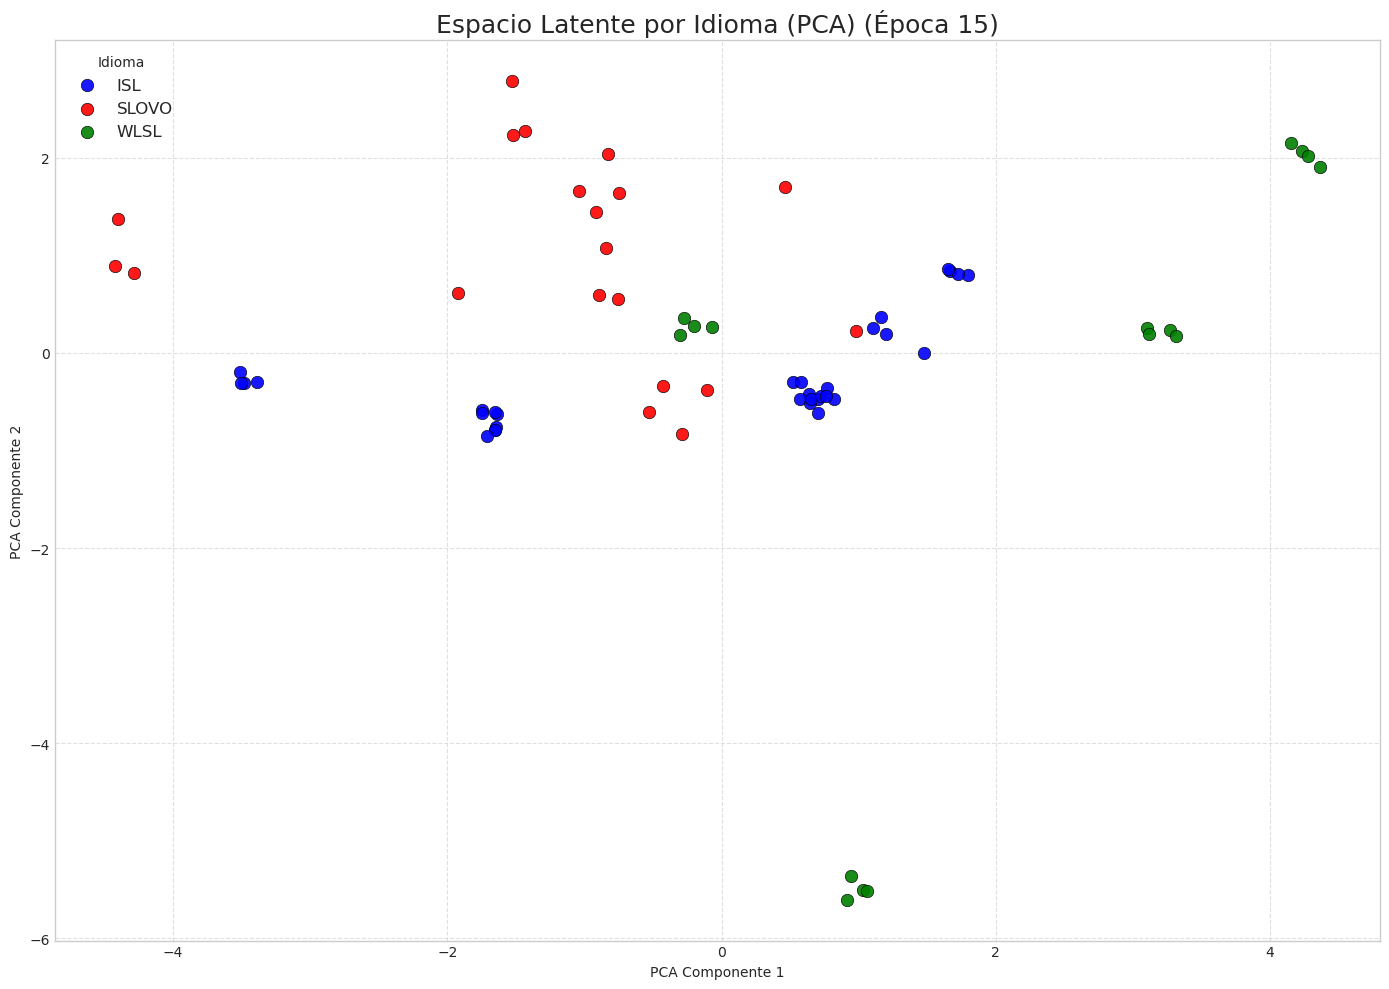

Reduciendo dimensionalidad con UMAP...
Generando gráfico por Etiqueta y Transformación...


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_15/latent_space_by_gloss_umap.png


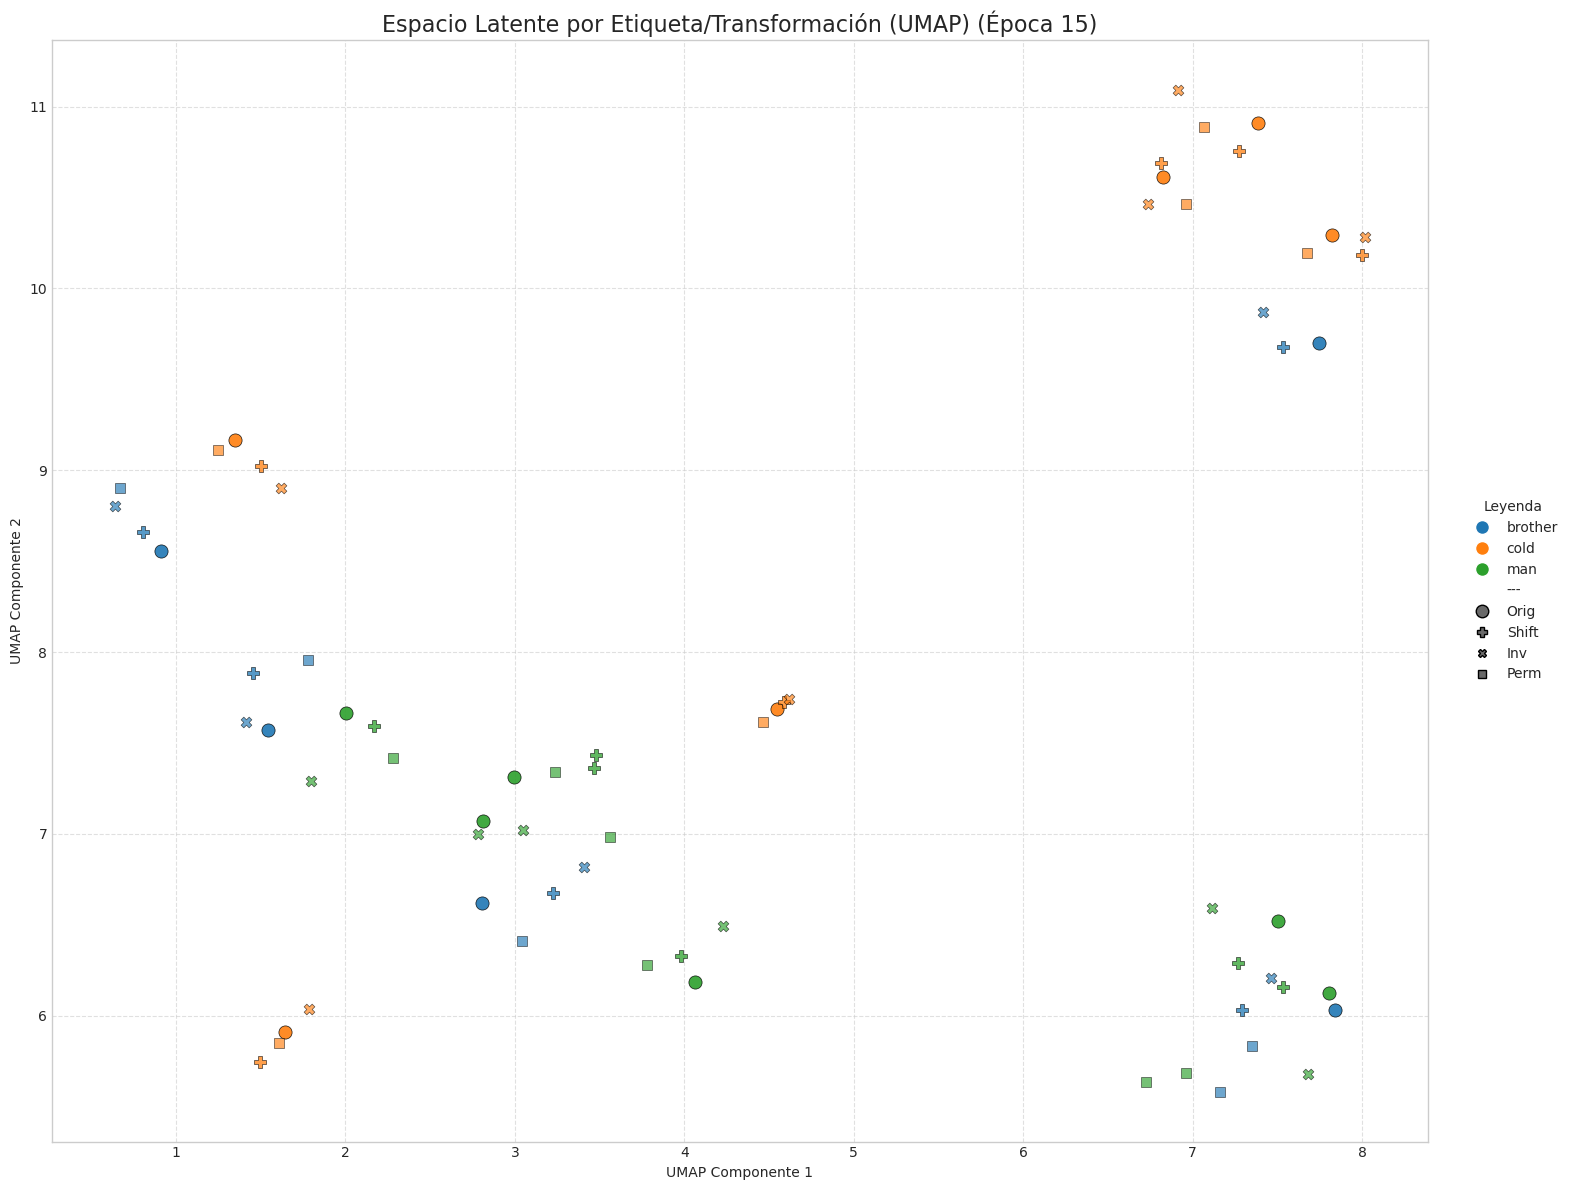

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_15/latent_space_by_language_umap.png


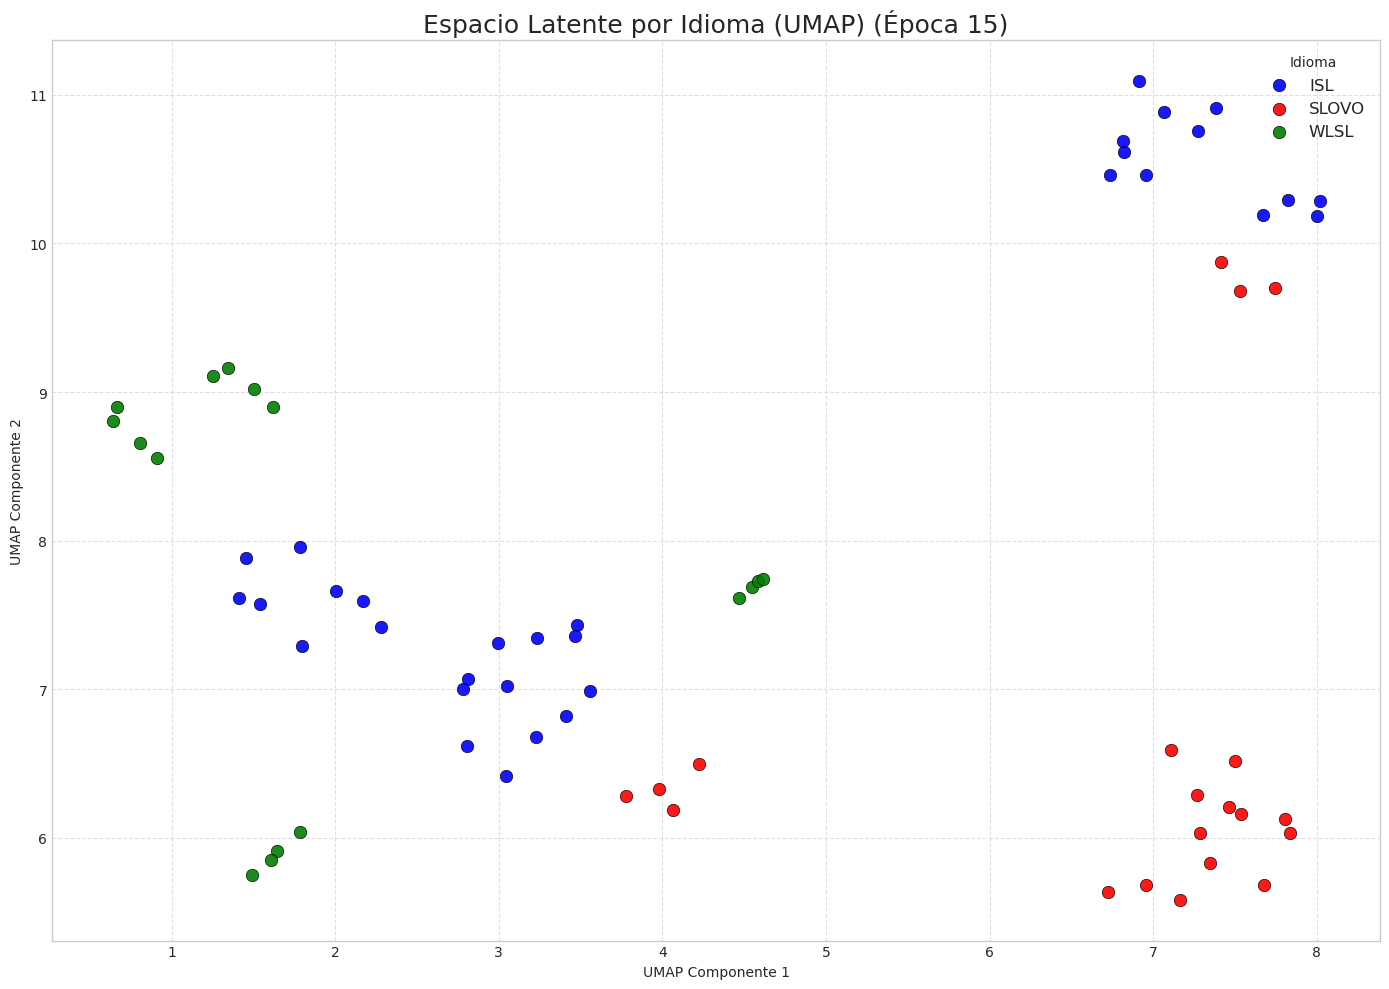


Procesando checkpoint de la época 25...

--- Visualizando Espacio Latente (Época 25) ---
Procesando 17 secuencias base para visualización...
Calculando vectores latentes...
Forma final de vectores latentes: (68, 256)
Reduciendo dimensionalidad con PCA...
Generando gráfico por Etiqueta y Transformación...


/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_25/latent_space_by_gloss_pca.png


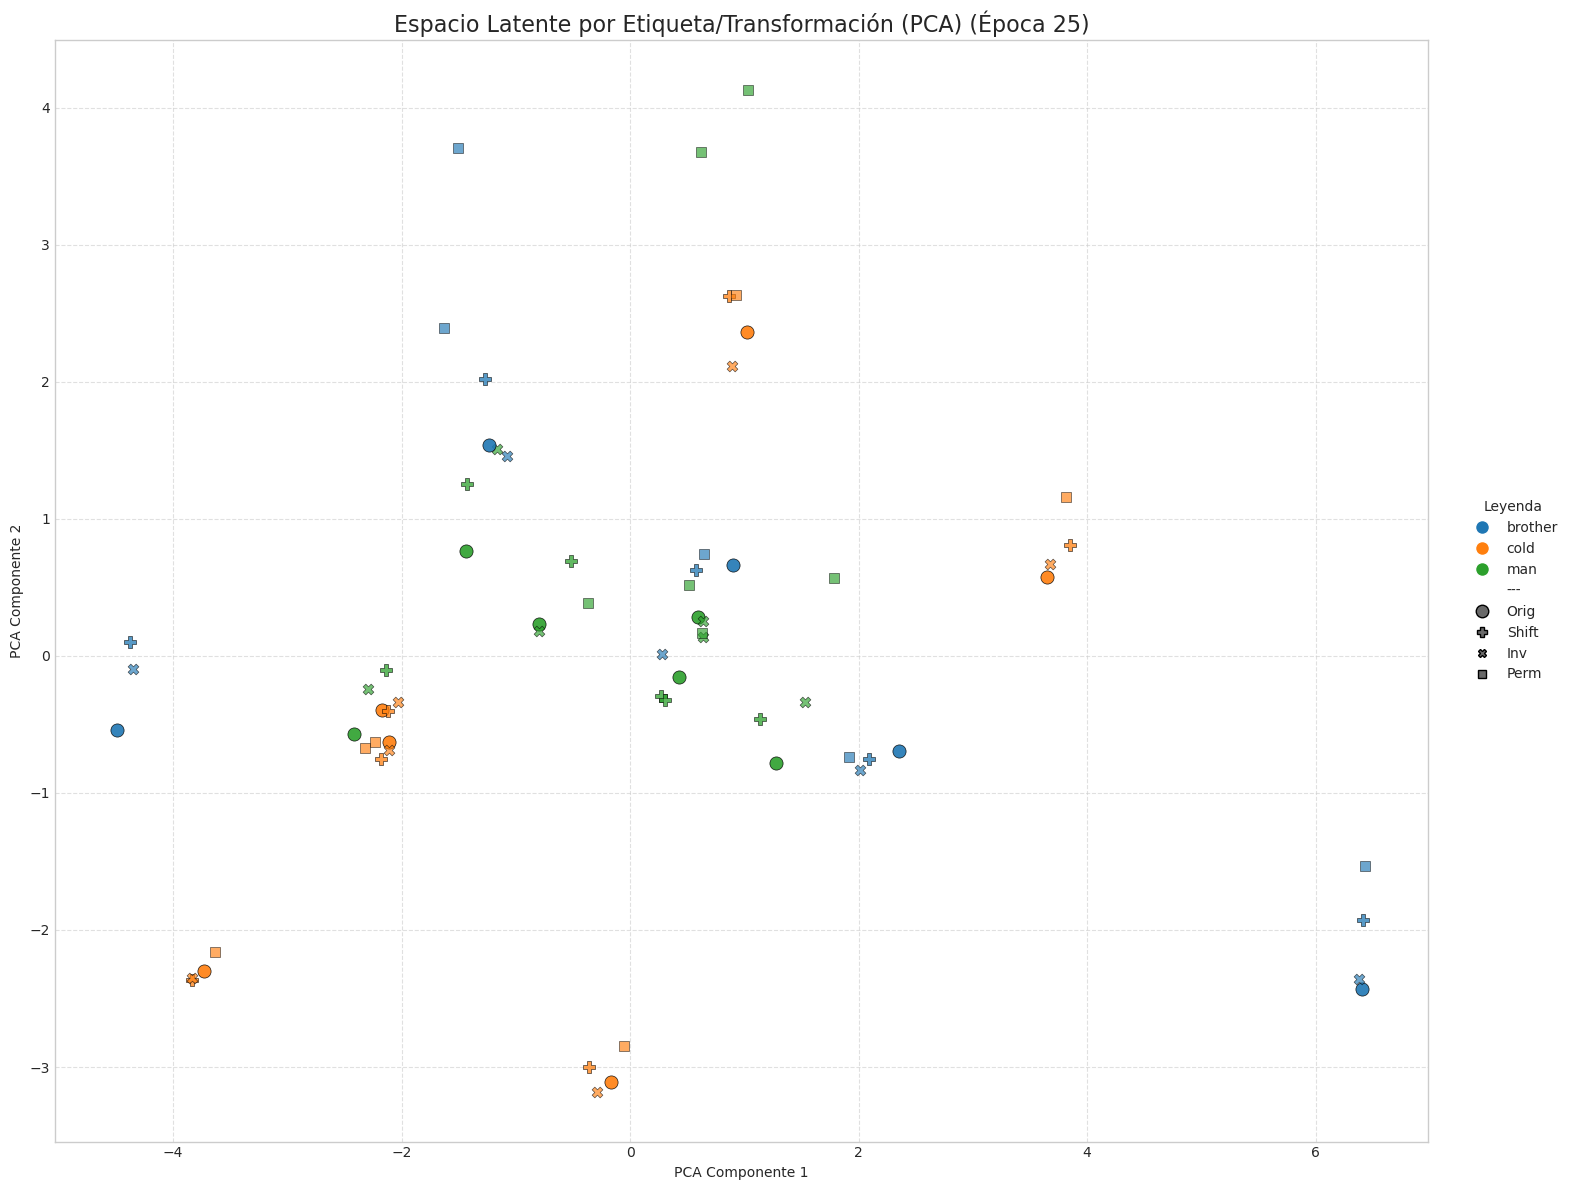

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_25/latent_space_by_language_pca.png


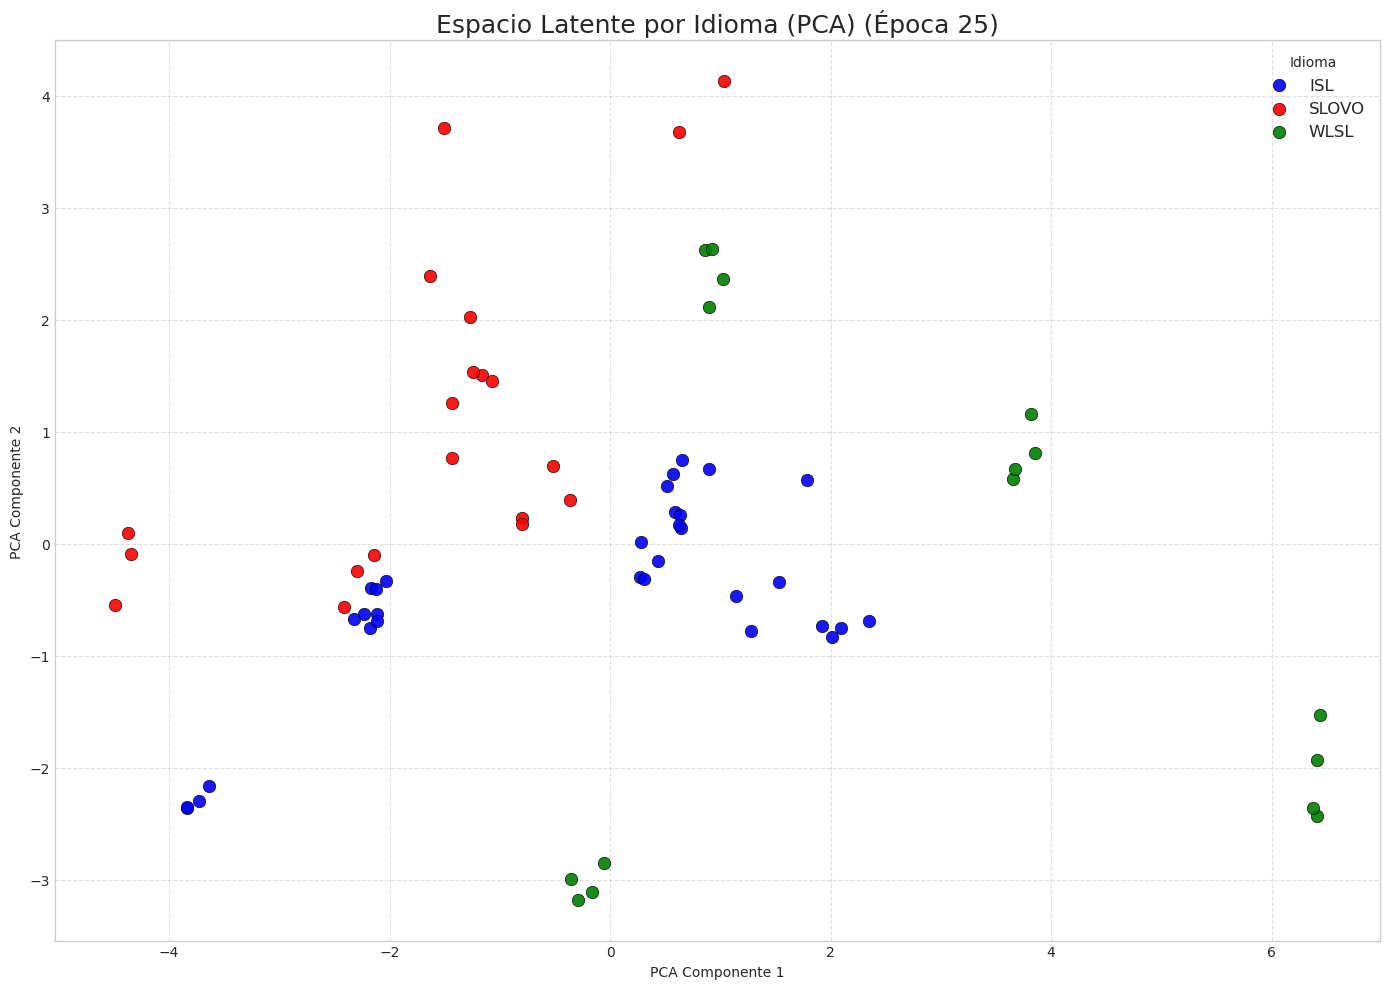

Reduciendo dimensionalidad con UMAP...
Generando gráfico por Etiqueta y Transformación...


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_25/latent_space_by_gloss_umap.png


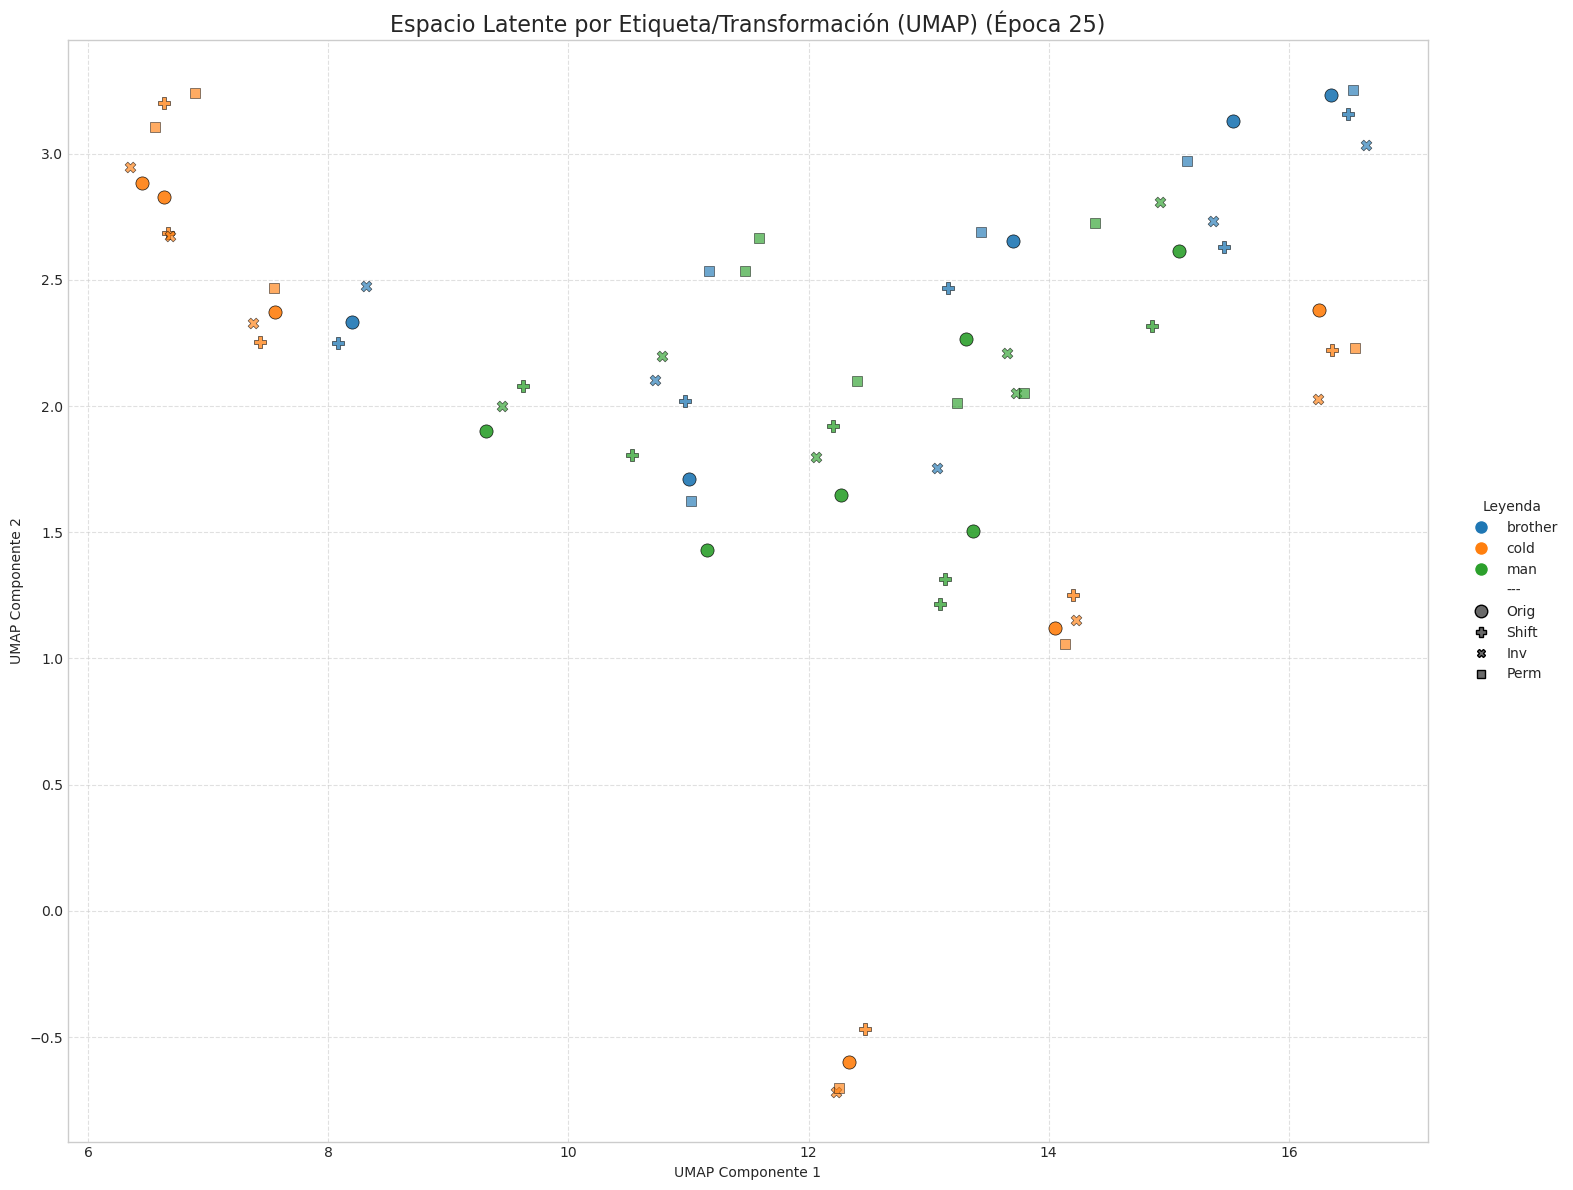

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_25/latent_space_by_language_umap.png


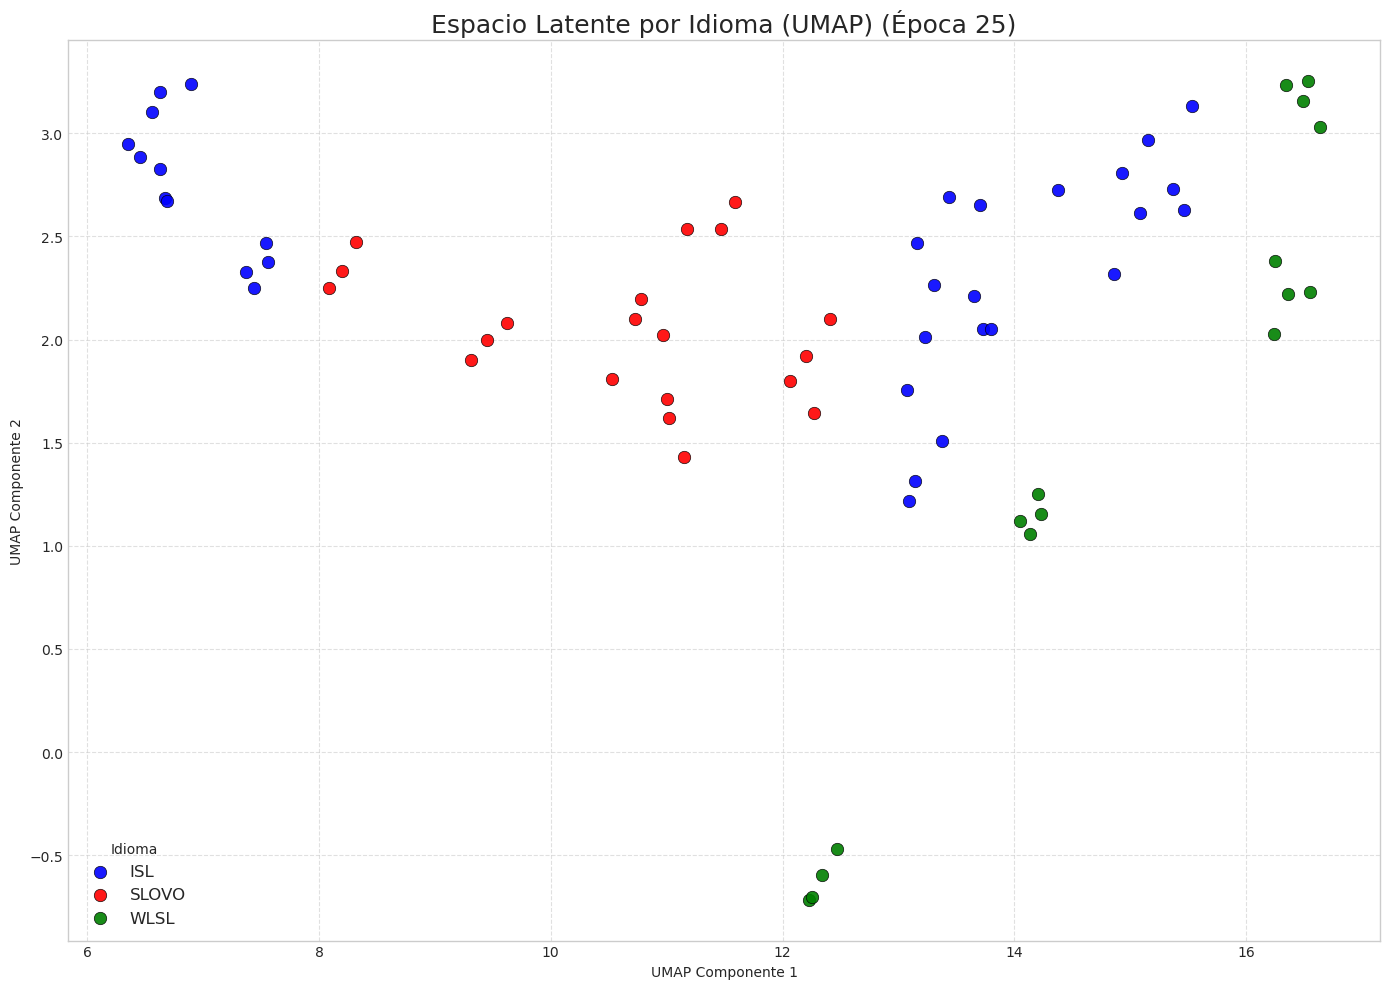


Procesando checkpoint de la época 45...

--- Visualizando Espacio Latente (Época 45) ---
Procesando 17 secuencias base para visualización...
Calculando vectores latentes...
Forma final de vectores latentes: (68, 256)
Reduciendo dimensionalidad con PCA...
Generando gráfico por Etiqueta y Transformación...


/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_45/latent_space_by_gloss_pca.png


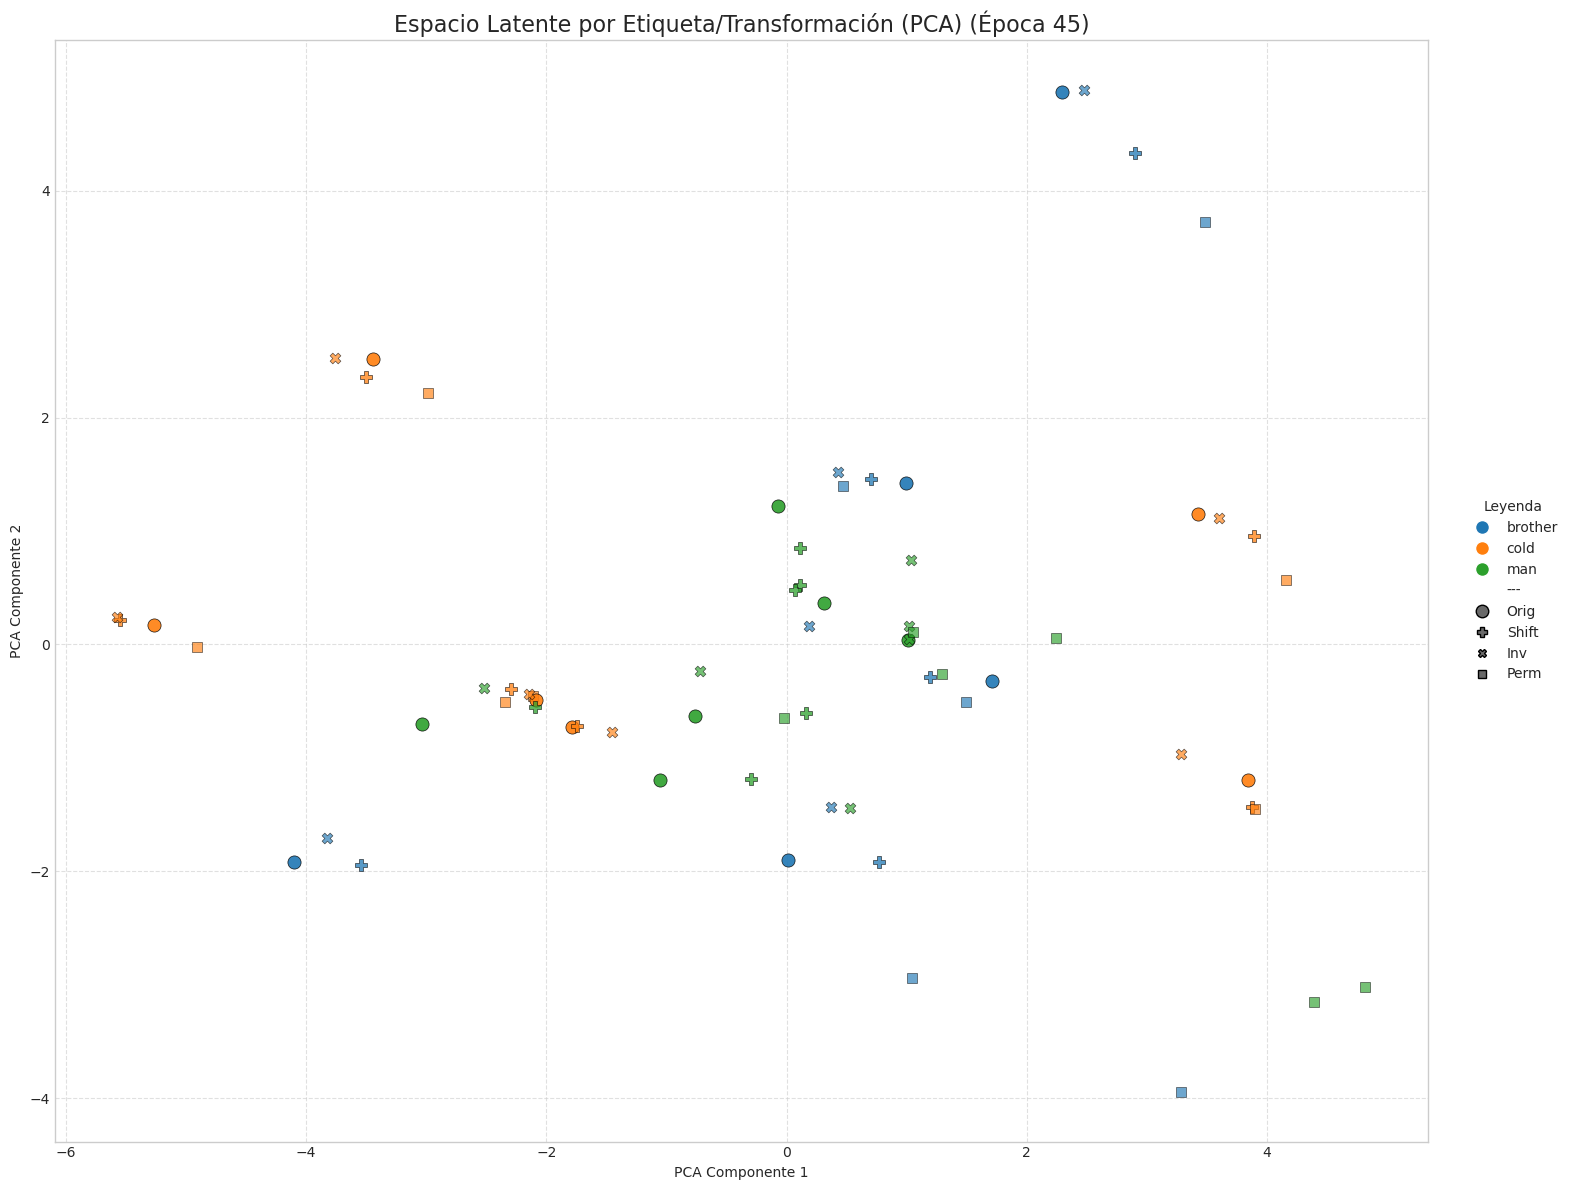

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_45/latent_space_by_language_pca.png


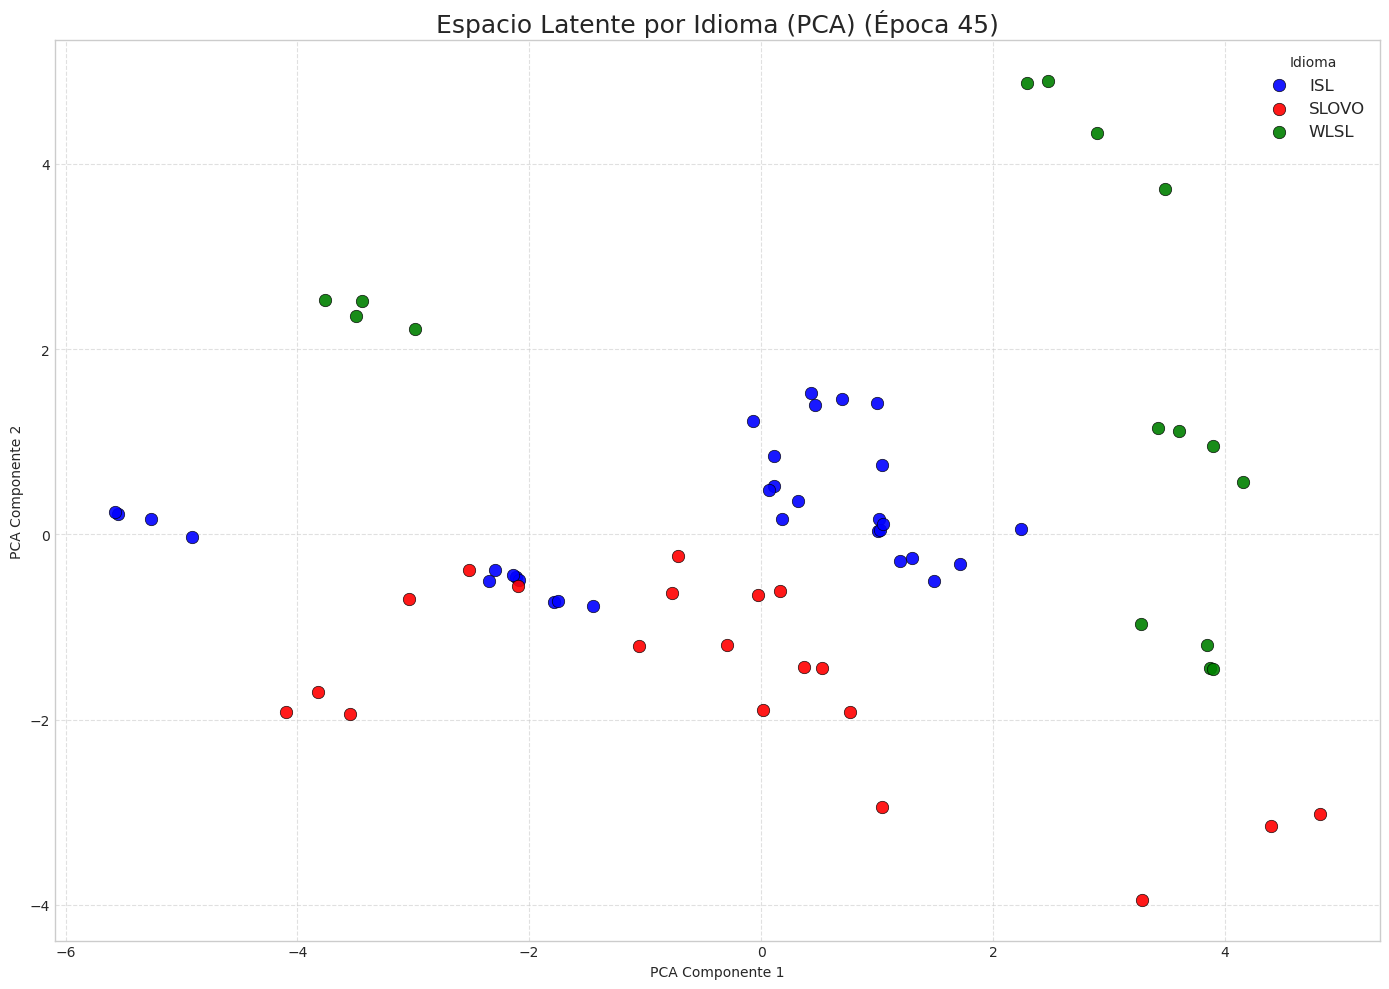

Reduciendo dimensionalidad con UMAP...
Generando gráfico por Etiqueta y Transformación...


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_45/latent_space_by_gloss_umap.png


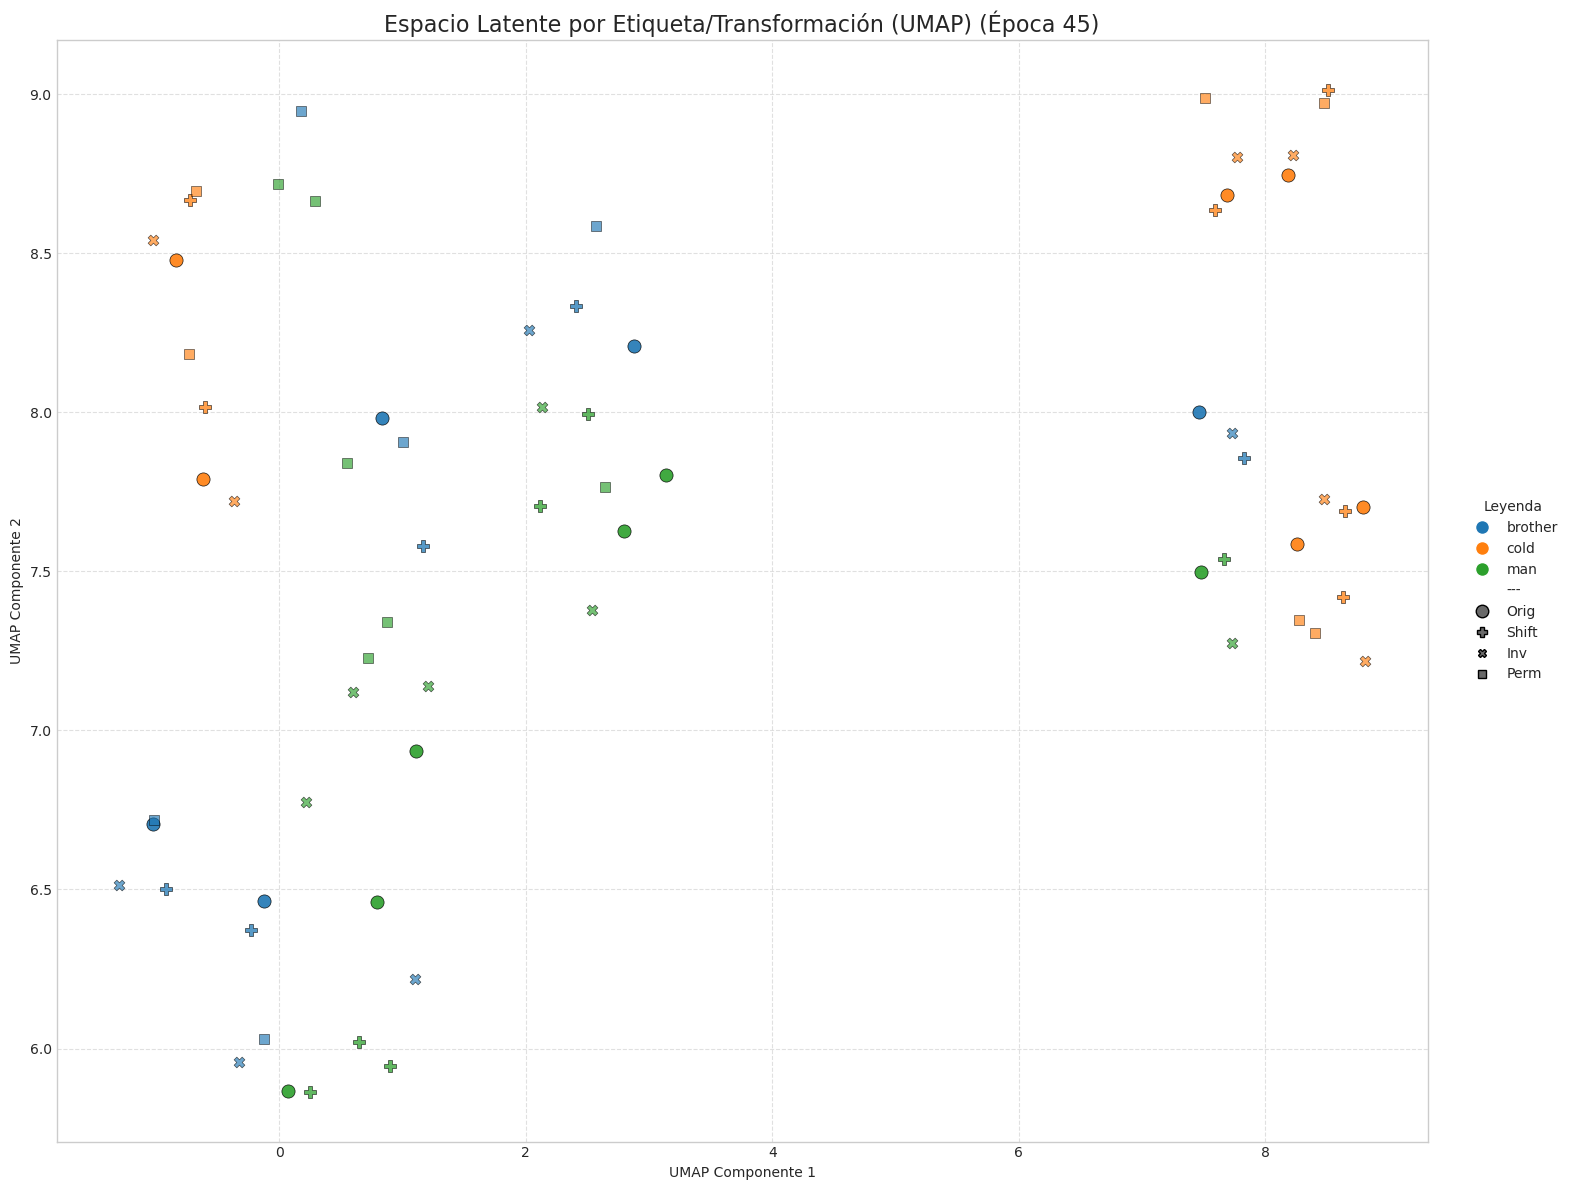

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_45/latent_space_by_language_umap.png


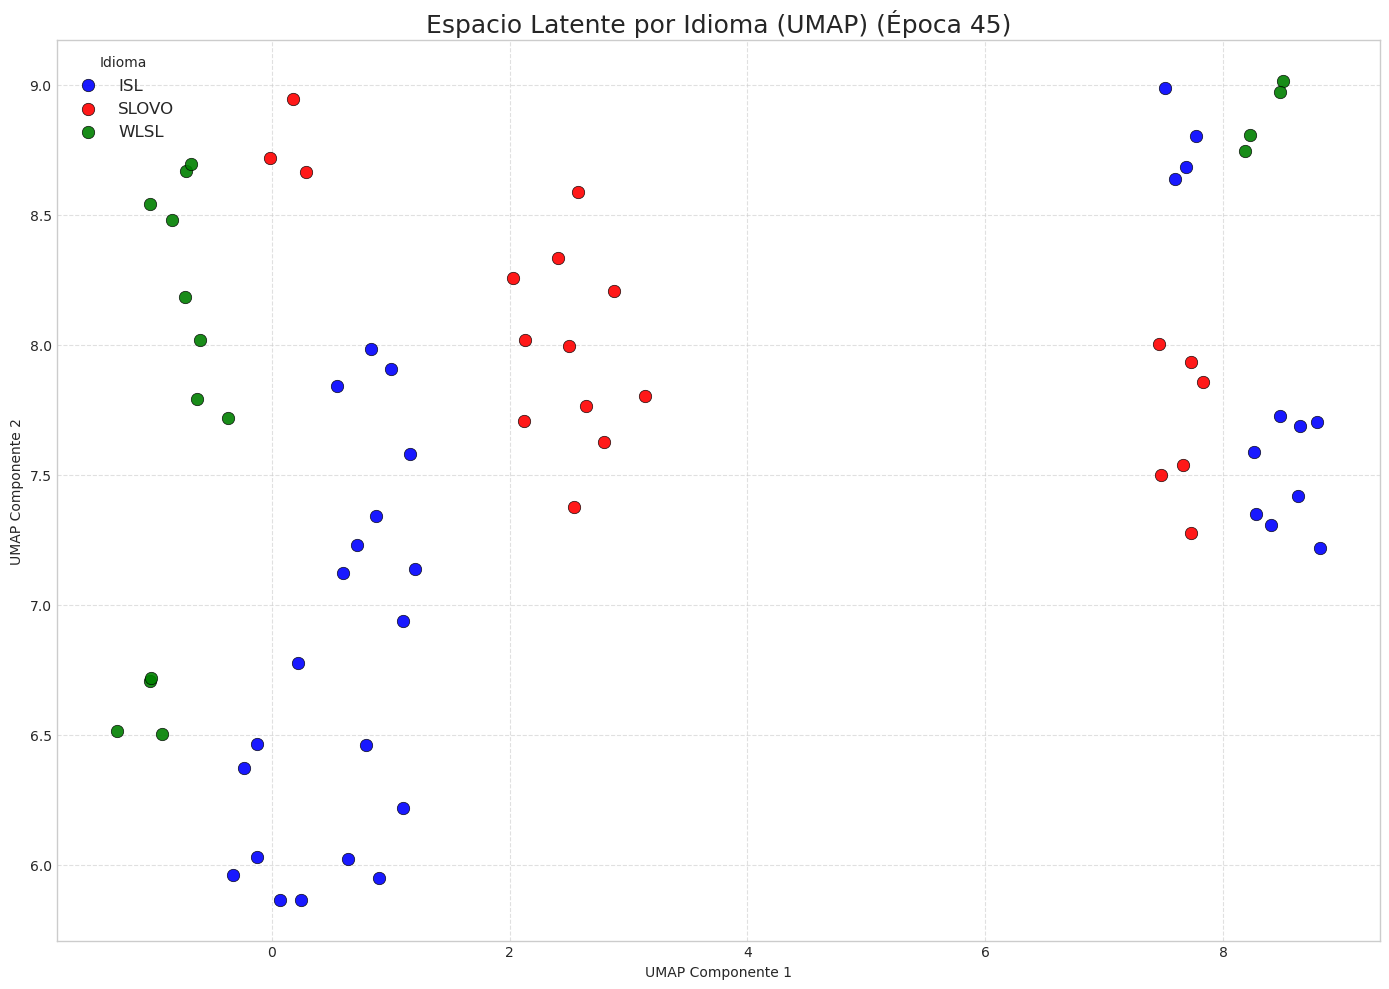


Procesando checkpoint de la época 65...

--- Visualizando Espacio Latente (Época 65) ---
Procesando 17 secuencias base para visualización...
Calculando vectores latentes...
Forma final de vectores latentes: (68, 256)
Reduciendo dimensionalidad con PCA...
Generando gráfico por Etiqueta y Transformación...


/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_65/latent_space_by_gloss_pca.png


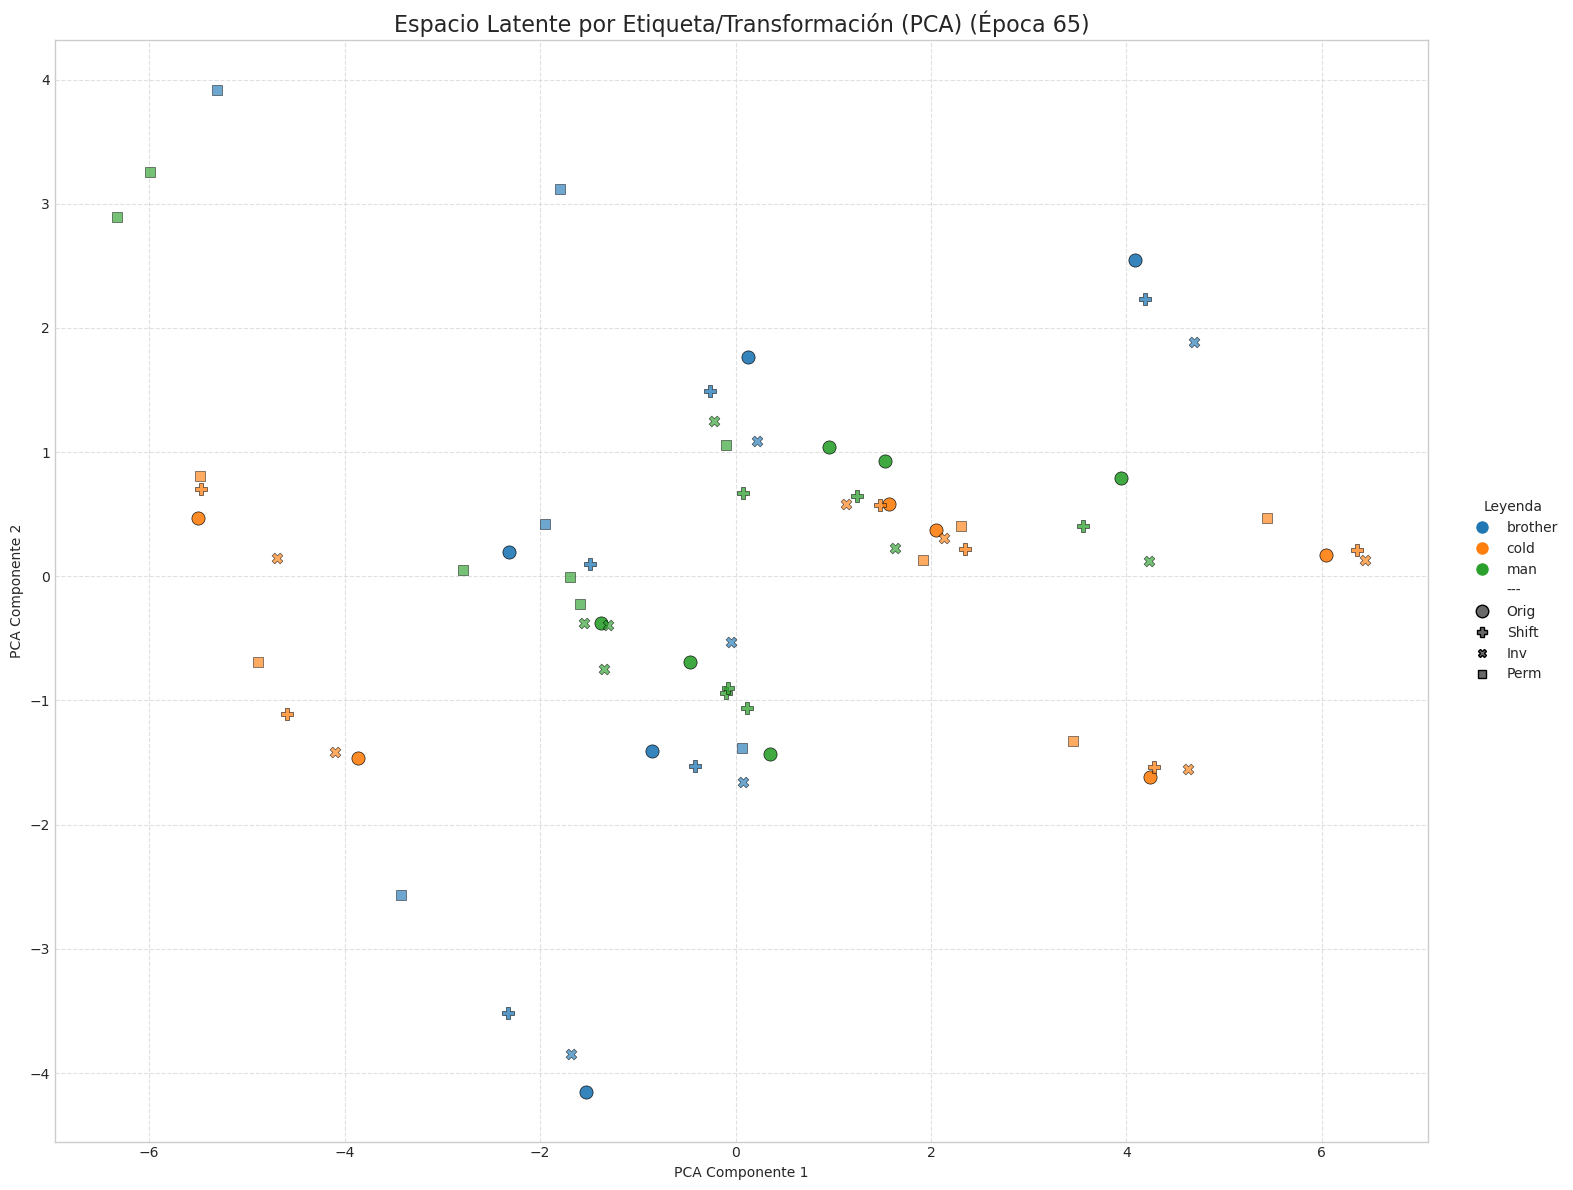

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_65/latent_space_by_language_pca.png


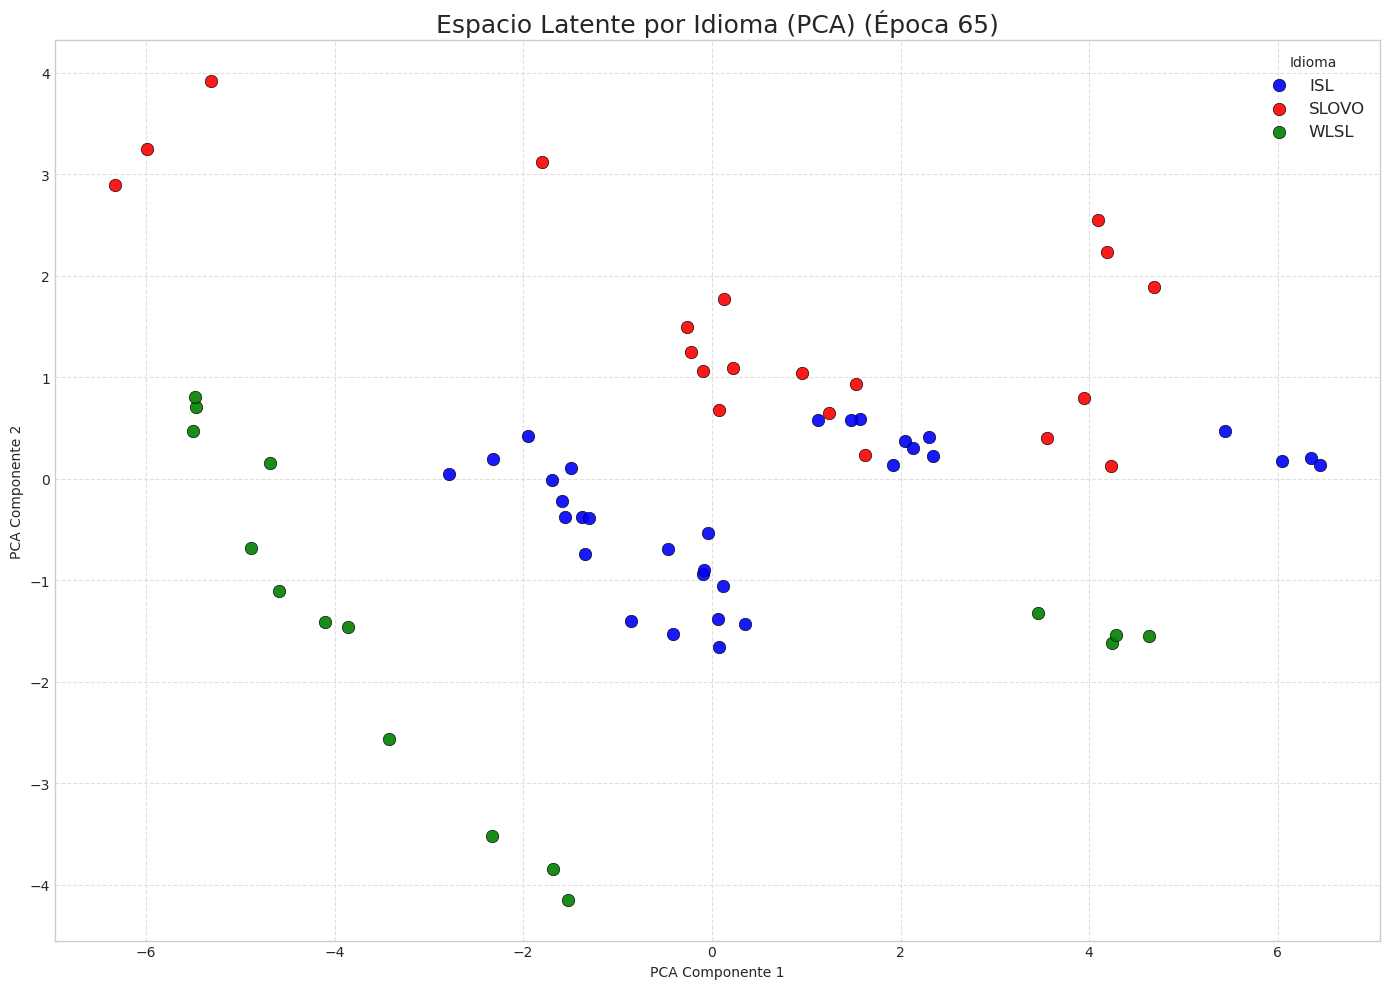

Reduciendo dimensionalidad con UMAP...
Generando gráfico por Etiqueta y Transformación...


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_65/latent_space_by_gloss_umap.png


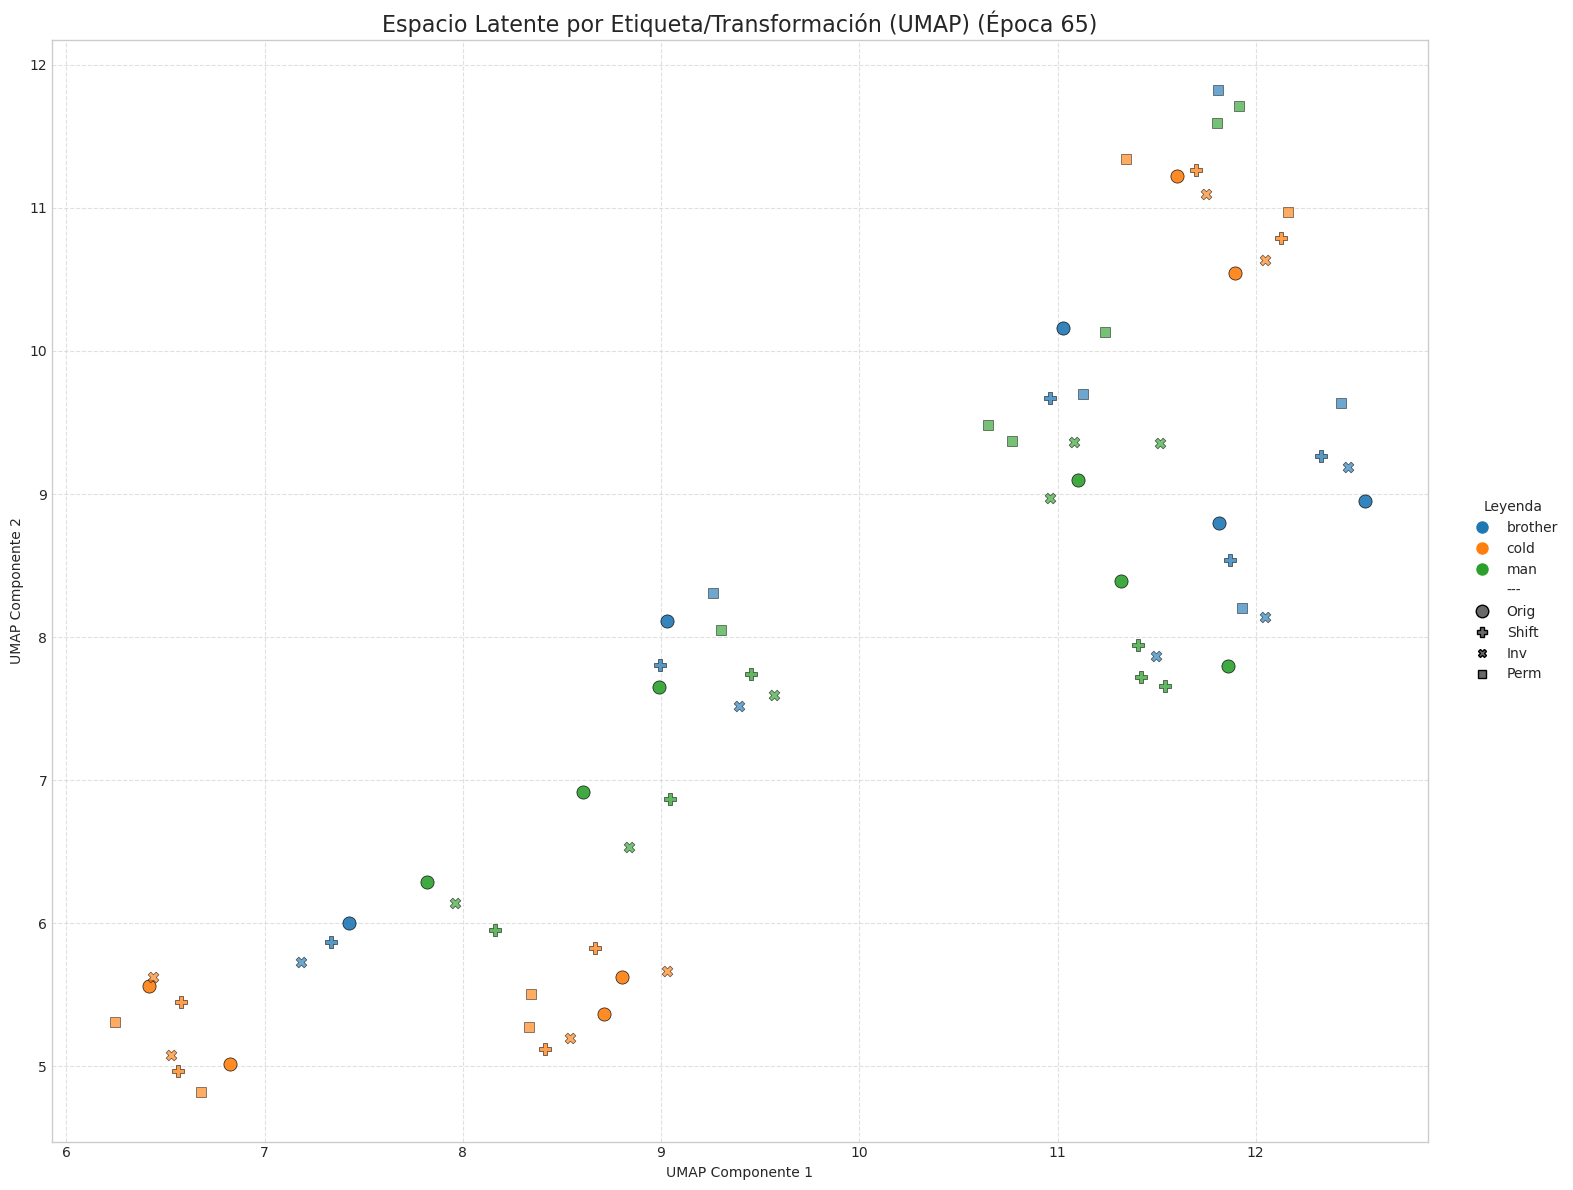

Generando gráfico por Idioma...
Visualización guardada en: visualizations_refactored_v2/epoch_65/latent_space_by_language_umap.png


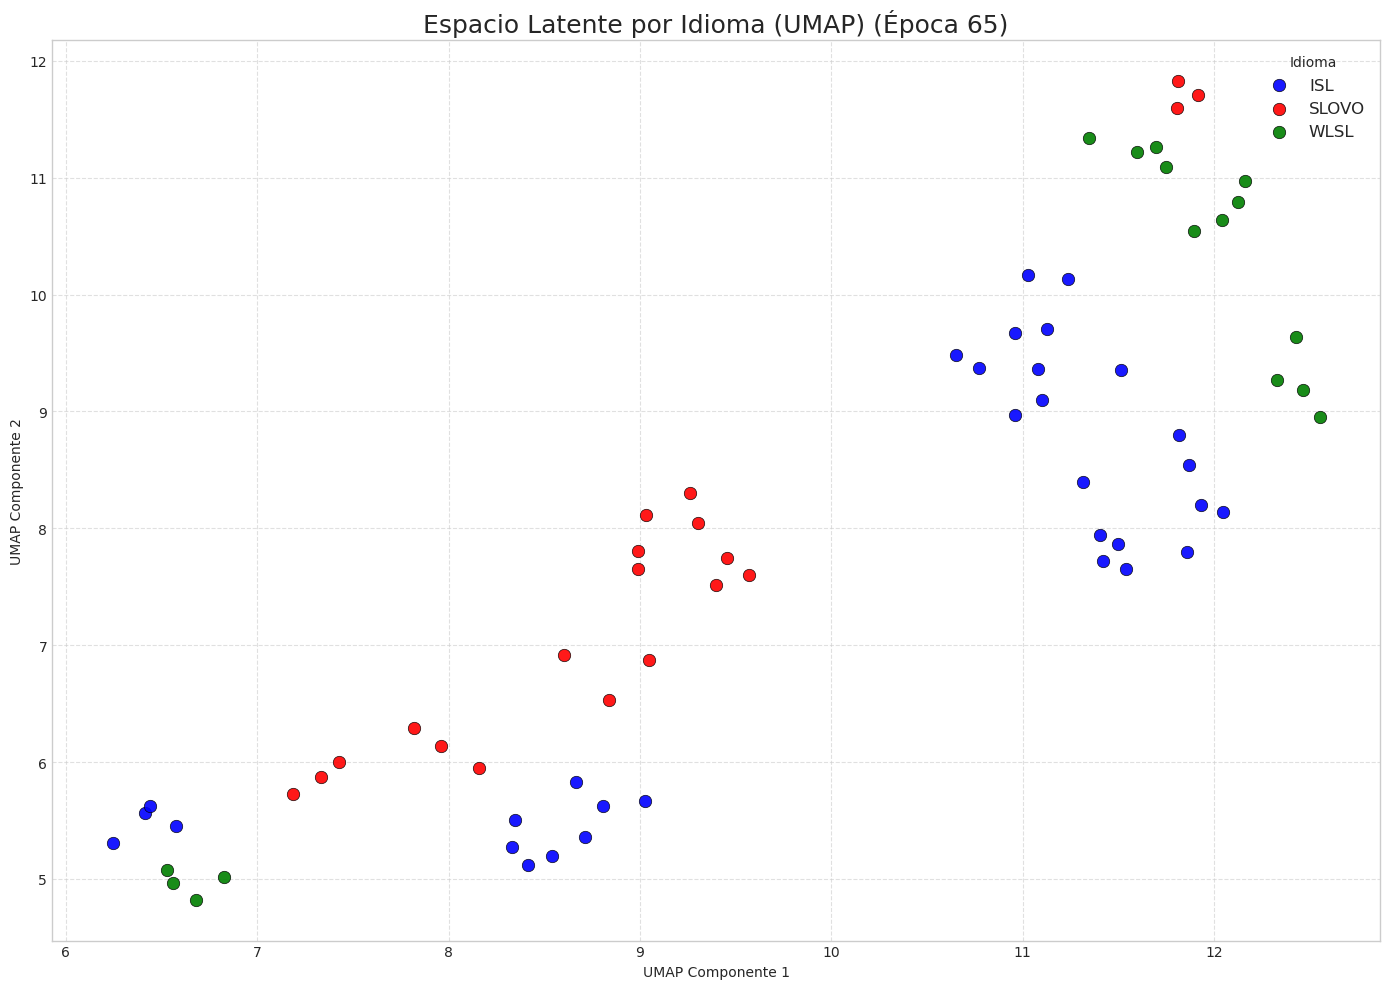


Procesando checkpoint de la época 85...

--- Visualizando Espacio Latente (Época 85) ---
Procesando 17 secuencias base para visualización...
Calculando vectores latentes...
Forma final de vectores latentes: (68, 256)
Reduciendo dimensionalidad con PCA...
Generando gráfico por Etiqueta y Transformación...


/tmp/ipykernel_27207/223509349.py:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap(cmap_name).colors


Visualización guardada en: visualizations_refactored_v2/epoch_85/latent_space_by_gloss_pca.png


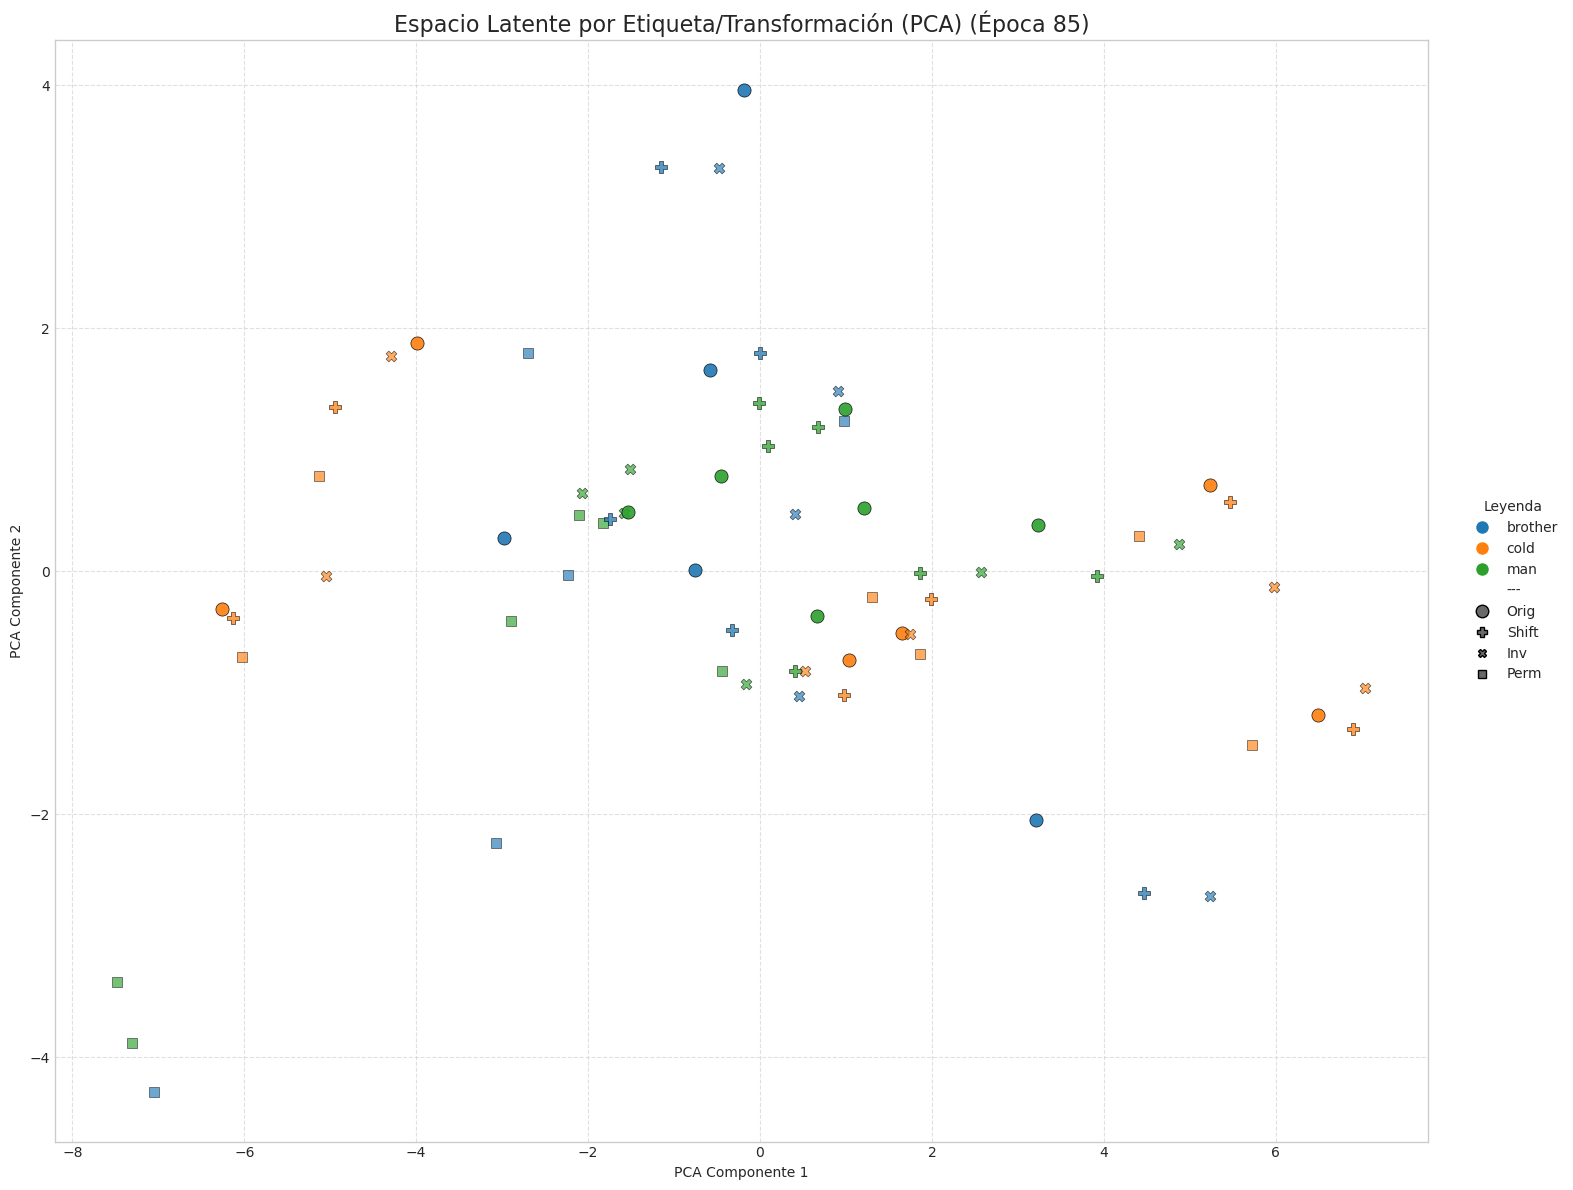

Generando gráfico por Idioma...


In [ ]:
# Asegúrate de que las variables globales como RANDOM_STATE y LANGUAGE_COLOR_MAP
# estén definidas como en tu cuaderno original.
RANDOM_STATE = 42
LANGUAGE_COLOR_MAP = {
    'SLOVO': 'red',
    'ISL': 'blue',
    'WLSL': 'green'
}

def visualize_latent_space_combined(wrapper_model, X_variants_vis, glosses_vis, lang_vis,
                                    lang_color_map, n_samples=None, use_pca=True, use_umap=True,
                                    output_dir='visualizations', title_suffix=''):
    """
    Visualiza el espacio latente generando dos gráficos por método (PCA/UMAP)
    a partir de las MISMAS coordenadas 2D:
    1. Coloreado por Glosa y con marcadores por Transformación (estilo original).
    2. Coloreado por Idioma.
    """
    print(f"\n--- Visualizando Espacio Latente {title_suffix} ---")

    # 1. PREPARACIÓN DE DATOS (Lógica de la Celda 1)
    if n_samples is None or n_samples <= 0:
        n_samples_to_vis = len(X_variants_vis)
    else:
        n_samples_to_vis = min(n_samples, len(X_variants_vis))

    if n_samples_to_vis == 0:
        print("No hay muestras para visualizar.")
        return

    print(f"Procesando {n_samples_to_vis} secuencias base para visualización...")
    X_variants_vis_subset = X_variants_vis[:n_samples_to_vis]
    glosses_vis_subset = glosses_vis[:n_samples_to_vis]
    lang_vis_subset = lang_vis[:n_samples_to_vis]

    latent_vectors_final = []
    gloss_labels_list = []
    transform_labels = []
    lang_labels_list = []

    X_variants_vis_tf = tf.cast(X_variants_vis_subset, dtype=tf.float32)

    # Extraer las 4 variantes relevantes
    anchor_input = X_variants_vis_tf[:, 0, ...]
    shifted_input = X_variants_vis_tf[:, 1, ...]
    inverted_input = X_variants_vis_tf[:, 3, ...]
    permuted_input = X_variants_vis_tf[:, 4, ...]

    print("Calculando vectores latentes...")
    latent_orig = wrapper_model.get_final_latent(anchor_input, training=False).numpy()
    latent_shifted = wrapper_model.get_final_latent(shifted_input, training=False).numpy()
    latent_inv = wrapper_model.get_final_latent(inverted_input, training=False).numpy()
    latent_perm = wrapper_model.get_final_latent(permuted_input, training=False).numpy()

    # Poblar listas (4 puntos por cada muestra original)
    for i in range(n_samples_to_vis):
        gloss = glosses_vis_subset[i]
        lang = lang_vis_subset[i]
        for j, (latent, transform_name) in enumerate(zip(
            [latent_orig, latent_shifted, latent_inv, latent_perm],
            ["Orig", "Shift", "Inv", "Perm"]
        )):
            latent_vectors_final.append(latent[i])
            gloss_labels_list.append(gloss)
            transform_labels.append(transform_name)
            lang_labels_list.append(lang)

    latent_vectors_final = np.array(latent_vectors_final)
    print(f"Forma final de vectores latentes: {latent_vectors_final.shape}")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 2. REDUCCIÓN DE DIMENSIÓN
    reducers = {}
    if use_pca: reducers['PCA'] = PCA(n_components=2, random_state=RANDOM_STATE)
    if use_umap:
        n_neighbors_val = min(15, max(5, latent_vectors_final.shape[0] - 1))
        reducers['UMAP'] = umap.UMAP(n_components=2, n_neighbors=n_neighbors_val,
                                     min_dist=0.1, random_state=RANDOM_STATE)

    for method_name, reducer in reducers.items():
        print(f"Reduciendo dimensionalidad con {method_name}...")
        try:
            if not np.all(np.isfinite(latent_vectors_final)):
                print("Advertencia: Vectores latentes contienen NaNs o Infs. Reemplazando con ceros.")
                latent_vectors_final = np.nan_to_num(latent_vectors_final)

            latent_2d = reducer.fit_transform(latent_vectors_final)

            # --- GRÁFICO 1: Por Etiqueta y Transformación ---
            print("Generando gráfico por Etiqueta y Transformación...")
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(18, 12))

            unique_glosses = sorted(list(set(gloss_labels_list)))
            cmap_name = 'tab20' if len(unique_glosses) > 10 else 'tab10'
            base_colors = plt.cm.get_cmap(cmap_name).colors
            color_map_gloss = {g: base_colors[i % len(base_colors)] for i, g in enumerate(unique_glosses)}

            markers = {'Orig': 'o', 'Shift': 'P', 'Inv': 'X', 'Perm': 's'}
            marker_size = {'Orig': 90, 'Shift': 70, 'Inv': 60, 'Perm': 60}
            alphas = {'Orig': 0.9, 'Shift': 0.75, 'Inv': 0.65, 'Perm': 0.65}

            for i in range(latent_2d.shape[0]):
                plt.scatter(latent_2d[i, 0], latent_2d[i, 1],
                            c=[color_map_gloss.get(gloss_labels_list[i], 'grey')],
                            marker=markers.get(transform_labels[i], '*'),
                            s=marker_size.get(transform_labels[i], 50),
                            alpha=alphas.get(transform_labels[i], 0.7),
                            edgecolors='k', linewidth=0.5)

            handles, labels = [], []
            for gloss in unique_glosses:
                handles.append(plt.Line2D([0], [0], marker='o', color='w', label=gloss,
                                       markerfacecolor=color_map_gloss.get(gloss, 'grey'), markersize=10))
                labels.append(gloss)
            handles.append(plt.Line2D([0], [0], linestyle='None', marker='None', label=''))
            labels.append('---')
            for transform, marker in markers.items():
                handles.append(plt.Line2D([0], [0], marker=marker, color='w', label=transform,
                                       markerfacecolor='dimgray', markeredgecolor='k',
                                       markersize=marker_size[transform]/10))
                labels.append(transform)

            plt.legend(handles, labels, title="Leyenda", loc='center left', bbox_to_anchor=(1.02, 0.5))
            plt.title(f"Espacio Latente por Etiqueta/Transformación ({method_name}) {title_suffix}".strip(), fontsize=16)
            plt.xlabel(f"{method_name} Componente 1")
            plt.ylabel(f"{method_name} Componente 2")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout(rect=[0, 0, 0.88, 1])
            save_path = os.path.join(output_dir, f"latent_space_by_gloss_{method_name.lower()}.png")
            plt.savefig(save_path, dpi=150)
            print(f"Visualización guardada en: {save_path}")
            plt.show()
            plt.close()

            # --- GRÁFICO 2: Por Idioma ---
            print("Generando gráfico por Idioma...")
            plt.style.use('seaborn-v0_8-whitegrid')
            plt.figure(figsize=(14, 10))
            unique_languages = sorted(list(set(lang_labels_list)))
            for lang in unique_languages:
                indices = [i for i, l in enumerate(lang_labels_list) if l == lang]
                plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1],
                            c=[lang_color_map.get(lang, 'grey')],
                            label=lang, s=80, alpha=0.9, edgecolors='k', linewidth=0.5)
            plt.legend(title="Idioma", fontsize='large')
            plt.title(f"Espacio Latente por Idioma ({method_name}) {title_suffix}".strip(), fontsize=18)
            plt.xlabel(f"{method_name} Componente 1")
            plt.ylabel(f"{method_name} Componente 2")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            save_path = os.path.join(output_dir, f"latent_space_by_language_{method_name.lower()}.png")
            plt.savefig(save_path, dpi=150)
            print(f"Visualización guardada en: {save_path}")
            plt.show()
            plt.close()

        except Exception as e:
            print(f"Error inesperado durante visualización con {method_name}: {e}")
            traceback.print_exc()


# --- [Paso Final] Bucle de Visualización para Épocas Específicas ---
print("\n[Paso Final] Visualización del Espacio Latente en Diferentes Épocas")

if 'X_val_variants' in locals() and 'glosses_val' in locals() and 'lang_val' in locals():
    n_vis_samples = len(X_val_variants)
    epochs_to_visualize = {5, 15, 25, 45, 65, 85}
    print(f"Se visualizarán las épocas: {sorted(list(epochs_to_visualize))}")

    # --- Visualizando el MEJOR modelo ---
    print("\n--- Visualizando el MEJOR modelo (restaurado por EarlyStopping) ---")
    best_model_dir = os.path.join(OUTPUT_VIZ_DIR, 'best_model_restored')
    visualize_latent_space_combined(
        wrapper_model=temporal_ae_wrapper,
        X_variants_vis=X_val_variants,
        glosses_vis=glosses_val,
        lang_vis=lang_val,
        lang_color_map=LANGUAGE_COLOR_MAP,
        n_samples=n_vis_samples,
        use_pca=True,
        use_umap=True,
        output_dir=best_model_dir,
        title_suffix="(Mejor Modelo)"
    )

    # --- Visualizando checkpoints intermedios ---
    print("\n--- Visualizando checkpoints intermedios ---")
    checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, 'epoch_*.weights.h5')))
    
    if not checkpoint_files:
        print("No se encontraron checkpoints intermedios.")
    else:
        try:
            # Recrear la arquitectura del modelo para poder cargar los pesos
            input_shape_viz = temporal_ae_wrapper.autoencoder.input_shape[1:]
            
            # Asegurarse de construir el modelo base con los mismos parámetros
            base_ae_viz = build_temporal_autoencoder(
                input_shape_viz, 
                target_h=(TARGET_H if RESIZE_INPUT else None), 
                target_w=(TARGET_W if RESIZE_INPUT else None)
            )
            
            # ######## INICIO DE LA CORRECCIÓN ########
            # Al instanciar el wrapper, debemos pasarle TODOS los argumentos
            # que requiere su constructor, no solo el autoencoder base.
            wrapper_viz = TemporalTripletAutoencoder(
                autoencoder=base_ae_viz,
                w_recon=W_RECON,
                w_inter=W_INTER_GLOSS,
                w_tempo_struct=W_TEMPORAL_STRUCTURE,
                w_kl=W_KL,
                margin_inter=MARGIN_INTER_GLOSS,
                margin_tempo_struct=MARGIN_TEMPORAL_STRUCTURE,
                latent_dim=LATENT_DIM
            )
            # ######## FIN DE LA CORRECCIÓN ########

            # Construir el modelo con una pasada dummy antes de cargar pesos
            dummy_input = tf.zeros((1, *input_shape_viz), dtype=tf.float32)
            _ = wrapper_viz.get_final_latent(dummy_input)

            for chkpt_path in checkpoint_files:
                epoch_num = int(os.path.basename(chkpt_path).split('_')[1].split('.')[0])
                
                if epoch_num in epochs_to_visualize:
                    print(f"\nProcesando checkpoint de la época {epoch_num}...")
                    wrapper_viz.load_weights(chkpt_path)
                    
                    output_dir_epoch = os.path.join(OUTPUT_VIZ_DIR, f'epoch_{epoch_num:02d}')
                    
                    visualize_latent_space_combined(
                        wrapper_model=wrapper_viz,
                        X_variants_vis=X_val_variants,
                        glosses_vis=glosses_val,
                        lang_vis=lang_val,
                        lang_color_map=LANGUAGE_COLOR_MAP,
                        n_samples=n_vis_samples,
                        use_pca=True,
                        use_umap=True,
                        output_dir=output_dir_epoch,
                        title_suffix=f"(Época {epoch_num})"
                    )
        except Exception as e:
            print(f"ERROR FATAL al procesar checkpoints: {e}")
            traceback.print_exc()
else:
    print("\nNo se realizará visualización (faltan datos de validación).")